In [1]:
import numpy as np
import pandas as pd
import math, itertools
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
import seaborn as sns

import sklearn
from sklearn import preprocessing
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.model_selection import ShuffleSplit, KFold, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, LeaveOneOut
from adjustText import adjust_text
import shap

import sys, os
sys.dont_write_bytecode = True
import conditions, analysis

import random
random.seed(1107)
np.random.seed(1107)

import warnings
warnings.filterwarnings('ignore')

PATH = 'Figures'
os.makedirs(PATH, exist_ok=True)

PATH2 = 'CSV_files'
os.makedirs(PATH2, exist_ok=True)

In [3]:
condition = conditions.calc_condition()
Reaction, data_sheet_name = condition['Reaction'], condition['data_sheet_name']
add_model = condition['add_model']
add_num = condition['add_num']
target_name = condition['target_name']
converted = analysis.analysis_data_convert(condition, data_sheet_name, use_models=[add_model], idx=None)
data, feat, target = converted['data'], converted['feat'], converted['target']
feat_cols = feat.columns

data_cols = conditions.data_columns(condition)
elem_cols = data_cols['elem']
wt_cols = data_cols['wt']
data[wt_cols] = data[wt_cols].astype('float')
#pd.options.display.float_format = '{:.4g}'.format
data = data.drop(['No.', 'CO Yield_%', 'CO formation rate_mmol min-1 gcat-1', 'Iteration', 'Catal prep', 'Reaction', 'Note'], axis=1)

data_sort = pd.DataFrame(index=np.arange(0, len(data), 1), columns=np.arange(0, len(data.columns), 1))
for i in range(len(data)):
    data_sort_elem = data.loc[i][[data.loc[i][wt_cols].sort_values(ascending=False).index[Adi].replace('_wt%', '') for Adi in range(add_num)]].reset_index().T.drop('index', axis=0)
    data_sort_wt = data.loc[i][wt_cols].sort_values(ascending=False).reset_index().T.drop('index', axis=0)
    data_sort.iloc[i] = pd.concat([data_sort_elem, data_sort_wt], axis=1)
data_sort = data_sort.rename(columns={
    0: f'{elem_cols[0]}', 1: f'{elem_cols[1]}', 2: f'{elem_cols[2]}', 3: f'{elem_cols[3]}', 4: f'{elem_cols[4]}',
    5: f'{wt_cols[0]}', 6: f'{wt_cols[1]}', 7: f'{wt_cols[2]}', 8: f'{wt_cols[3]}', 9: f'{wt_cols[4]}'
    }).reindex(columns=data.columns)
data_sort['Catalyst'] = 'Pt(3)/'

for i in range(len(data)):
    for j in range(add_num):
        if data_sort[elem_cols[j]][i] != 'H' and j == 0:
            data_sort['Catalyst'][i] += data_sort[elem_cols[j]][i]
        elif data_sort[elem_cols[j]][i] != 'H' and j != 0:
            data_sort['Catalyst'][i] += '-' + data_sort[elem_cols[j]][i]
        else:
            pass
        if data_sort[wt_cols[j]][i] >= 1:
            data_sort[wt_cols[j]][i] = data_sort[wt_cols[j]][i].astype(int)
            data_sort['Catalyst'][i] += '(' + data_sort[wt_cols[j]][i].astype(str) + ')'
        elif data_sort[wt_cols[j]][i] < 1 and data_sort[wt_cols[j]][i] > 0:
            data_sort['Catalyst'][i] += '(' + data_sort[wt_cols[j]][i].astype(str) + ')'
        else:
            pass
data_sort['Catalyst'] += '/$TiO_{2}$'

Table_S3 = converted['data']
Table_S3 = Table_S3.drop(elem_cols, axis=1).drop(wt_cols, axis=1).drop(['Catal prep', 'Reaction', 'Note'], axis=1).rename(columns = {'No.':'ID'})
Table_S3.loc[:, ['CO Yield_%', 	'CO formation rate_mmol min-1 gcat-1']] = Table_S3.loc[:, ['CO Yield_%', 	'CO formation rate_mmol min-1 gcat-1']].round(2)
Table_S3.insert(loc = 1, column= 'Catalyst', value= data_sort['Catalyst'])
Table_S3.insert(loc = 3, column= 'CO selectivity_%', value= 100)
Table_S3.to_csv(f'{PATH2}/Table_S3.csv')
Table_S3.to_excel(f'{PATH2}/Table_S3.xlsx')
Table_S3

20220318 rwgs_250 all data


ID                                           Catalyst  CO Yield_%  \
0      1                             Pt(3)/Mo(10)/$TiO_{2}$        3.07   
1      2                              Pt(3)/V(10)/$TiO_{2}$        2.48   
2      3                             Pt(3)/Ce(10)/$TiO_{2}$        2.45   
3      4                             Pt(3)/La(10)/$TiO_{2}$        1.78   
4      5                              Pt(3)/Y(10)/$TiO_{2}$        1.71   
..   ...                                                ...         ...   
295  296         Pt(3)/Ba(2)-Re(1)-Mo(0.6)-W(0.2)/$TiO_{2}$        3.94   
296  297  Pt(3)/Rb(1)-Ba(1)-Mo(0.5)-Nb(0.2)-Hf(0.2)/$TiO...        3.83   
297  298      Pt(3)/Mo(0.7)-K(0.7)-Ba(0.5)-W(0.2)/$TiO_{2}$        3.44   
298  299  Pt(3)/Rb(1)-Mo(0.7)-Ce(0.2)-Nb(0.2)-Na(0.2)/$T...        3.98   
299  300  Pt(3)/Ba(1)-Rb(1)-Mo(0.5)-Nb(0.2)-Yb(0.2)/$TiO...        3.34   

     CO selectivity_%  CO formation rate_mmol min-1 gcat-1  Iteration  
0                 100                                 2.55          0  
1                 100                                 2.06          0  
2                 100                                 2.04          0  
3                 100                                 1.48          0  
4                 100                                 1.42          0  
..                ...                                  ...        ...  
295               100                                 3.29         44  
296               100                                 3.19         44  
297               100                                 2.87         44  
298               100                                 3.31         44  
299               100                                 2.78         44  

[300 rows x 6 columns]

In [5]:
data = converted['data']
data_cols = conditions.data_columns(condition)
elem_cols = data_cols['elem']
wt_cols = data_cols['wt']
data[wt_cols] = data[wt_cols].astype('float')

data = data.drop(['Catal prep', 'Reaction', 'Note'], axis=1)
data[elem_cols] = data[elem_cols].replace('H', '')
data[wt_cols] = data[wt_cols].replace(0.0, '')
data[wt_cols] = data[wt_cols].replace(10.0, 10)
data.loc[:, ['CO Yield_%', 'CO formation rate_mmol min-1 gcat-1']] = round(data.loc[:, ['CO Yield_%', 'CO formation rate_mmol min-1 gcat-1']], 2)
data.to_csv(f'{PATH2}/dataset.csv')
data.to_excel(f'{PATH2}/dataset.xlsx')

In [8]:
condition = conditions.calc_condition()
Reaction, data_sheet_name = condition['Reaction'], condition['data_sheet_name']

add_model = condition['add_model']

converted = analysis.analysis_data_convert(condition, data_sheet_name, use_models=[add_model], idx=None)
feat, target = converted['feat'], converted['target']
feat_cols = feat.columns
model  = ExtraTreesRegressor(n_estimators=100, random_state=1107, n_jobs=-1)
feat

20220318 rwgs_250 all data


Group  EN_Allred        m.p.   d_fus_H   Density  BG_Oxide  \
0    0.625261   0.135473  301.792414  3.905794  1.062943  0.210296   
1    0.981518   0.284640  428.530766  4.220527  1.177822  0.460136   
2    0.214108   0.077079   76.222558  0.389677  0.483171  0.134175   
3    0.215974   0.077751   85.885728  0.446347  0.442747  0.279111   
4    0.337435   0.124851  202.348776  1.282255  0.502779  0.461837   
..        ...        ...         ...       ...       ...       ...   
295  0.118282   0.033187   58.982444  0.784387  0.271538  0.064415   
296  0.072773   0.028276   34.755327  0.367819  0.130761  0.050597   
297  0.075481   0.030830   34.811309  0.397953  0.124517  0.055467   
298  0.081554   0.034955   36.183300  0.399147  0.132438  0.057364   
299  0.074671   0.029536   34.671516  0.356564  0.129104  0.049325   

     Ox Num_Oxide  Eads_CO2  
0        0.625261 -0.160447  
1        0.981518 -0.777734  
2        0.285478 -0.224331  
3        0.215974 -0.296902  
4        0.337435 -0.366521  
..            ...       ...  
295      0.118282 -0.064061  
296      0.072773 -0.071000  
297      0.075481 -0.068810  
298      0.082981 -0.061518  
299      0.074671 -0.076203  

[300 rows x 8 columns]

SHAP_summary_plot ETR prop2 was finished.
10-fold One-shot plot ETR prop2 was finished.
Feature_importance plot ETR prop2 was finished.
LeaveOneOut plot ETR prop2 was finished.


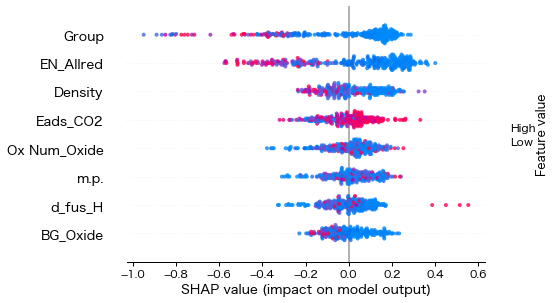

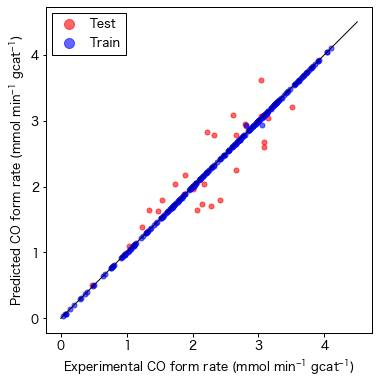

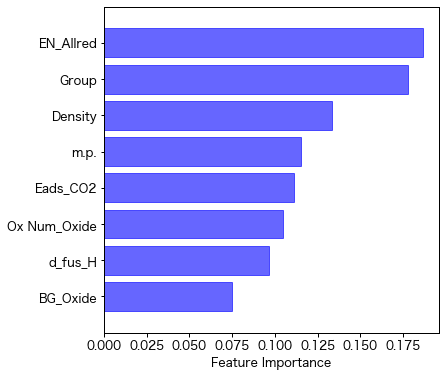

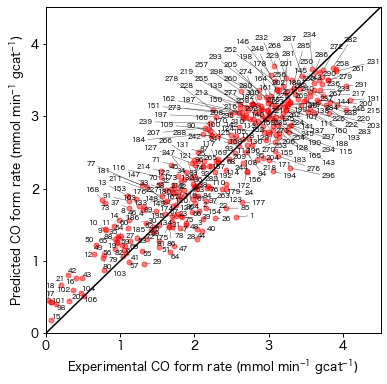

In [9]:
analysis.shap_summary_plot(condition, model, feat, target, save=True)
analysis.one_shot_plot(condition, feat, target, model, Reaction, test_size=0.1, random_state=1107, save=True)
analysis.plot_importance(condition, model, labels=feat_cols, topk=20, save=True)
analysis.loo_plot(condition, feat, target, feat_cols, model, save=True)

LeaveOneOut plot ETR prop111 was finished.


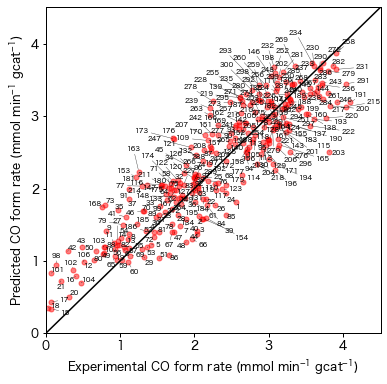

In [4]:
analysis.loo_plot(condition, feat, target, feat_cols, model, save=True)

In [ ]:
os.makedirs(f'{PATH}/SHAP/waterfall/prop{add_model}', exist_ok=True)
data = converted['data']
data['CO formation rate_mmol min-1 gcat-1']=Table_S3['CO formation rate_mmol min-1 gcat-1']
target_name, ML_model = condition['target_name'], condition['ML_model']
model = ExtraTreesRegressor(n_estimators=100, random_state=1107, n_jobs=4)
model.fit(feat, target)

explainer = shap.Explainer(model, feat)
shap_values = explainer(feat)
shap_values.values = np.round(shap_values.values, 2)
shap_values.base_values = np.round(shap_values.base_values, 2)
shap_values.data = np.round(shap_values.data, 2)

plt.figure(facecolor='white', figsize =(8,6))

for i in range(len(data)):
    plt.figure(facecolor='white', figsize =(8,6))
    Cat_No = data['No.'][i]
    print('No.', data['No.'][i], Table_S3['Catalyst'][i], 'CO form rate:', round(data[target_name][i], 2))
    save_file_name = f'{PATH}/SHAP/waterfall/prop{add_model}/Cat_No_{Cat_No}_shap_waterfall_prop{add_model}.png'
    shap.plots.waterfall(shap_values[i], max_display=9, show=True, filename=save_file_name)

In [7]:
from matplotlib.ticker import FuncFormatter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as lines

def waterfall_plot(
    index, data, Title="", x_lab="", y_lab="",
    formatting = "{:,.2f}", positive_color='deeppink', negative_color='dodgerblue', total_color='grey',
    sorted_value = False, threshold=None, other_label='other features', net_label='SHAP total value', rotation_value=90,
    save='waterfall.png'
    ):

    index=np.array(index)
    data=np.array(data)

    #sorted by absolute value
    if sorted_value:
        abs_data = abs(data)
        data_order = np.argsort(abs_data)[::-1]
        data = data[data_order]
        index = index[data_order]

    #group contributors less than the threshold into 'other'

    if threshold:
        
        abs_data = abs(data)
        threshold_v = abs_data.max()*threshold
        
        if threshold_v > abs_data.min():
            index = np.append(index[abs_data>=threshold_v],other_label)
            data = np.append(data[abs_data>=threshold_v],sum(data[abs_data<threshold_v]))

    changes = {'amount' : data}

    #define format formatter
    def money(x, pos):
        'The two args are the value and tick position'
        return formatting.format(x)
    formatter = FuncFormatter(money)


    fig, ax = plt.subplots(facecolor='white', figsize =(8,6))
    ax.yaxis.set_major_formatter(formatter)

    #Store data and create a blank series to use for the waterfall
    trans = pd.DataFrame(data=changes,index=index)
    blank = trans.amount.cumsum().shift(1).fillna(0)

    trans['positive'] = trans['amount'] > 0

    #Get the net total number for the final element in the waterfall
    total = trans.sum().amount
    trans.loc[net_label]= total
    blank.loc[net_label] = total

    #The steps graphically show the levels as well as used for label placement
    step = blank.reset_index(drop=True).repeat(3).shift(-1)
    step[1::3] = np.nan

    #When plotting the last element, we want to show the full bar,
    #Set the blank to 0
    blank.loc[net_label] = 0

    #define bar colors for net bar
    trans.loc[trans['positive'] > 1, 'positive'] = 99
    trans.loc[trans['positive'] < 0, 'positive'] = 99
    trans.loc[(trans['positive'] > 0) & (trans['positive'] < 1), 'positive'] = 99

    trans['color'] = trans['positive']

    trans.loc[trans['positive'] == 1, 'color'] = positive_color
    trans.loc[trans['positive'] == 0, 'color'] = negative_color
    trans.loc[trans['positive'] == 99, 'color'] = total_color

    my_colors = list(trans.color)

    for i in range(len(trans.amount)):
        if trans.amount[i] >= 0 and i < len(trans.amount)-1:
            arrow_dict = dict(width=24, headwidth=24, headlength=8, shrink=0, color=positive_color, alpha=0.8)
            #plt.annotate("", xy=(i, trans.amount[i]+blank[i]), xytext=(i, blank[i]), size=15, color='k', arrowprops=arrow_dict)
        elif trans.amount[i] < 0 and i < len(trans.amount)-1:
            arrow_dict = dict(width=24, headwidth=24, headlength=8, shrink=0, color=negative_color, alpha=0.8)
            #plt.annotate("", xy=(i, trans.amount[i]+blank[i]), xytext=(i, blank[i]), size=15, color='k', arrowprops=arrow_dict)
        elif i == len(trans.amount)-1:
            arrow_dict = dict(width=24, headwidth=24, headlength=8, shrink=0, color=total_color, alpha=0.8)
        plt.annotate("", xy=(i, trans.amount[i]+blank[i]), xytext=(i, blank[i]), size=15, color='k', arrowprops=arrow_dict)


    #axis labels
    plt.xlabel("\n" + x_lab)
    plt.ylabel(y_lab + "\n", fontsize=16)

    #Get the y-axis position for the labels
    y_height = trans.amount.cumsum().shift(1).fillna(0)

    temp = list(trans.amount)

    # create dynamic chart range
    for i in range(len(temp)):
        if (i > 0) & (i < (len(temp) - 1)):
            temp[i] = temp[i] + temp[i-1]

    trans['temp'] = temp

    plot_max = trans['temp'].max()
    plot_min = trans['temp'].min()

    #Make sure the plot doesn't accidentally focus only on the changes in the data
    if all(i >= 0 for i in temp):
        plot_min = 0
    if all(i < 0 for i in temp):
        plot_max = 0

    if abs(plot_max) >= abs(plot_min):
        maxmax = abs(plot_max)
    else:
        maxmax = abs(plot_min)
        
    pos_offset = maxmax / 40

    plot_offset = maxmax / 15 ## needs to me cumulative sum dynamic

    #Start label loop
    loop = 0
    for index, row in trans.iterrows():
        # For the last item in the list, we don't want to double count
        if row['amount'] == total:
            y = y_height[loop]
        else:
            y = y_height[loop] + row['amount']
        # Determine if we want a neg or pos offset
        if row['amount'] > 0:
            y += (pos_offset*2)
            plt.annotate(formatting.format(row['amount']),(loop,y),ha="center", color='k', fontsize=12)
        else:
            y -= (pos_offset*4)
            plt.annotate(formatting.format(row['amount']),(loop,y),ha="center", color='k', fontsize=12)
        loop+=1

    #Scale up the y axis so there is room for the labels
    plt.xlim(-0.5, len(trans.index)-0.5)
    plt.ylim(plot_min-round(3.6*plot_offset, 7), plot_max+round(3.6*plot_offset, 7))

    #Rotate the labels
    plt.xticks(range(0,len(trans)), trans.index, rotation=rotation_value)

    #add zero line and title
    plt.axhline(0, color='black', linewidth = 0.6, linestyle="dashed")
    plt.title(Title)
    plt.tight_layout()
    plt.savefig(f'{PATH}'+'/'+'prop2'+'/'+str(save)+'_waterfall.png', dpi=600, bbox_inches='tight')
    
    return plt

In [ ]:
data = converted['data']
target_name, ML_model = condition['target_name'], condition['ML_model']
model = ExtraTreesRegressor(n_estimators=100, random_state=1107, n_jobs=4)
model.fit(feat, target)

explainer = shap.Explainer(model, feat)
shap_values = explainer(feat)

for Cat_No in range(len(data)):
    waterfall_plot(
        feat.columns, shap_values[Cat_No].values,
        rotation_value=90, sorted_value=True, threshold=0.05, formatting='{:,.2f}', net_label='SHAP total value', other_label='other features',
        Title=Table_S3['Catalyst'][Cat_No], x_lab = '', y_lab = 'SHAP value', positive_color='deeppink', negative_color='dodgerblue', total_color='grey',
        save=Cat_No+1
        )

In [5]:
def extract_max_min_target_cat(condition, converted):
    date, Reaction, target_name, target_temp = condition['date'], condition['Reaction'], condition['target_name'], condition['target_temp']
    data = converted['data']
    pgm_num, add_num, supp_num, CalT_num = condition['pgm_num'], condition['add_num'], condition['supp_num'], condition['CalT_num']
    print('pgm_num =', pgm_num, 'add_num =', add_num, 'supp_num =', supp_num, 'CalT_num =', CalT_num)
    
    if Reaction == 'rwgs_250':
        drop_data_list = ['CO Yield_%', 'Catal prep', 'Reaction', 'Note']
    elif Reaction == 'rwgs_300':
        drop_data_list = ['Calc. temp. (℃)', 'CO Yield_%','CO selec', 'Catal prep', 'Reaction', 'Note', 'Experimantal condition']
        if CalT_num == 1:
            drop_data_list.remove('Calc. temp. (℃)')
        else:
            pass
    elif Reaction == 'CH3OH':
        if target_name == 'CH3OH rate (mmol g-1 h-1)':
            drop_data_list = [
                'Calc. temp. (℃)', 'Cat amount/g', 'CH3OH yield (%)', 'CH3OH selec (%)', 'CH3OH rate x selec',
                'CO rate (mmol g-1 h-1)', 'CO yield (%)', 'CO selec (%)','CH4 rate (mmol g-1 h-1)',
                'CH4 yield (%)', 'CH4 selec (%)', 'CH3OH-CH4', 'Experimenter', 'CH3OH (mmol)',
                'CO (mmol)', 'CH4 (mmol)', 'Date', 'Preparation', 'Reaction', 'Note'
                ]
        elif target_name == 'CH4 rate (mmol g-1 h-1)':
            drop_data_list = [
                'Calc. temp. (℃)', 'Cat amount/g', 'CH3OH rate (mmol g-1 h-1)', 'CH3OH yield (%)', 'CH3OH selec (%)', 'CH3OH rate x selec',
                'CO rate (mmol g-1 h-1)', 'CO yield (%)', 'CO selec (%)','CH4 yield (%)', 'CH4 selec (%)', 'CH3OH-CH4',
                'Experimenter', 'CH3OH (mmol)', 'CO (mmol)', 'CH4 (mmol)', 'Date', 'Preparation', 'Reaction', 'Note'
                ]
        elif target_name == 'CH3OH-CH4':
            drop_data_list = [
                'Calc. temp. (℃)', 'Cat amount/g', 'CH3OH rate (mmol g-1 h-1)', 'CH3OH yield (%)', 'CH3OH selec (%)', 'CH3OH rate x selec',
                'CO rate (mmol g-1 h-1)', 'CO yield (%)', 'CO selec (%)','CH4 rate (mmol g-1 h-1)', 'CH4 yield (%)',
                'CH4 selec (%)','Experimenter', 'CH3OH (mmol)', 'CO (mmol)', 'CH4 (mmol)', 'Date', 'Preparation', 'Reaction', 'Note'
                ]
        if CalT_num == 1:
            drop_data_list.remove('Calc. temp. (℃)')
        else:
            pass
    elif Reaction == 'N2O':
        if target_temp == 20:
            drop_data_list = [
                'Calc. temp. (℃)', 'T30 (℃)', 'T50 (℃)', 'Conv at 500℃ (during pretreatment)', 'Cat. amount (mg)',
                'Prep.', 'Reaction', 'Comment', 'Date'
                ]
            target_name = f'T{target_temp} (℃)'
        elif target_temp == 30:
            drop_data_list = [
                'Calc. temp. (℃)', 'T20 (℃)', 'T50 (℃)', 'Conv at 500℃ (during pretreatment)', 'Cat. amount (mg)',
                'Prep.', 'Reaction', 'Comment', 'Date'
                ]
            target_name = f'T{target_temp} (℃)'
        elif target_temp == 50:
            drop_data_list = [
                'Calc. temp. (℃)', 'T20 (℃)', 'T30 (℃)', 'Conv at 500℃ (during pretreatment)', 'Cat. amount (mg)',
                'Prep.', 'Reaction', 'Comment', 'Date'
                ]
            target_name = f'T{target_temp} (℃)'

        if CalT_num == 1:
            drop_data_list.remove('Calc. temp. (℃)')
        else:
            pass
    elif Reaction == 'H2SCR':
        if target_temp == 10:
            drop_data_list =[
                'Calc. temp. (℃)', 'N2 yield_T15', 'N2 yield_T20', 'N2 yield_T30', 'N2 yield_T50', 'N2 yield_T80', # target_cols
                'NO conv_T50', 'H2 conv_T50', 'NO conv_T80', 'H2 conv_T80'
                'NO conv [300℃] (%)','H2 conv [300℃] (%)', 'N2O yield [300℃] (%)',
                'N2 yield [300℃] (%)','NH3 yield [300℃] (%)', 'NO2 yield [300℃] (%)', 'N2 selec [300℃] (%)',
                'Cat. amount (mg)', 'Preparation', 'Reaction', 'Date'
                ]
            target_name = f'N2 yield_T{target_temp}'
        elif target_temp == 15:
            drop_data_list =[
                'Calc. temp. (℃)', 'N2 yield_T10', 'N2 yield_T20', 'N2 yield_T30', 'N2 yield_T50', 'N2 yield_T80', # target_cols
                'NO conv_T50', 'H2 conv_T50', 'NO conv_T80', 'H2 conv_T80'
                'NO conv [300℃] (%)','H2 conv [300℃] (%)', 'N2O yield [300℃] (%)',
                'N2 yield [300℃] (%)','NH3 yield [300℃] (%)', 'NO2 yield [300℃] (%)', 'N2 selec [300℃] (%)',
                'Cat. amount (mg)', 'Preparation', 'Reaction', 'Date'
                ]
            target_name = f'N2 yield_T{target_temp}'
        elif target_temp == 20:
            drop_data_list =[
                'Calc. temp. (℃)', 'N2 yield_T10', 'N2 yield_T15', 'N2 yield_T30', 'N2 yield_T50', 'N2 yield_T80', # target_cols
                'NO conv_T50', 'H2 conv_T50', 'NO conv_T80', 'H2 conv_T80'
                'NO conv [300℃] (%)','H2 conv [300℃] (%)', 'N2O yield [300℃] (%)',
                'N2 yield [300℃] (%)','NH3 yield [300℃] (%)', 'NO2 yield [300℃] (%)', 'N2 selec [300℃] (%)',
                'Cat. amount (mg)', 'Preparation', 'Reaction', 'Date'
                ]
            target_name = f'N2 yield_T{target_temp}'
        elif target_temp == 30:
            drop_data_list =[
                'Calc. temp. (℃)', 'N2 yield_T10', 'N2 yield_T15', 'N2 yield_T20', 'N2 yield_T50', 'N2 yield_T80', # target_cols
                'NO conv_T50', 'H2 conv_T50', 'NO conv_T80', 'H2 conv_T80'
                'NO conv [300℃] (%)','H2 conv [300℃] (%)', 'N2O yield [300℃] (%)',
                'N2 yield [300℃] (%)','NH3 yield [300℃] (%)', 'NO2 yield [300℃] (%)', 'N2 selec [300℃] (%)',
                'Cat. amount (mg)', 'Preparation', 'Reaction', 'Date'
                ]
            target_name = f'N2 yield_T{target_temp}'
        elif target_temp == 50:
            drop_data_list =[
                'Calc. temp. (℃)', 'N2 yield_T10', 'N2 yield_T15', 'N2 yield_T20', 'N2 yield_T30', 'N2 yield_T80', # target_cols
                'NO conv_T50', 'H2 conv_T50', 'NO conv_T80', 'H2 conv_T80'
                'NO conv [300℃] (%)','H2 conv [300℃] (%)', 'N2O yield [300℃] (%)',
                'N2 yield [300℃] (%)','NH3 yield [300℃] (%)', 'NO2 yield [300℃] (%)', 'N2 selec [300℃] (%)',
                'Cat. amount (mg)', 'Preparation', 'Reaction', 'Date'
                ]
            target_name = f'N2 yield_T{target_temp}'
        elif target_temp == 80:
            drop_data_list =[
                'Calc. temp. (℃)', 'N2 yield_T10', 'N2 yield_T15', 'N2 yield_T20', 'N2 yield_T30', 'N2 yield_T50', # target_cols
                'NO conv_T50', 'H2 conv_T50', 'NO conv_T80', 'H2 conv_T80'
                'NO conv [300℃] (%)','H2 conv [300℃] (%)', 'N2O yield [300℃] (%)',
                'N2 yield [300℃] (%)','NH3 yield [300℃] (%)', 'NO2 yield [300℃] (%)', 'N2 selec [300℃] (%)',
                'Cat. amount (mg)', 'Preparation', 'Reaction', 'Date'
                ]
            target_name = f'N2 yield_T{target_temp}'
        if CalT_num == 1:
            drop_data_list.remove('Calc. temp. (℃)')
        else:
            pass
    elif Reaction == 'NH3SCR':
        if target_temp == 20:
            drop_data_list = [
                'Calc. temp. (℃)', 'T20_NO conv', 'T30_NO conv', 'T50_NO conv', 'T30_N2 yield', 'T50_N2 yield',
                'T20_NH3 conv', 'T30_NH3 conv', 'T50_NH3 conv', 'T20_N2 yield_2','T30_N2 yield_2', 'T50_N2 yield_2',
                'Cat. amount (mg)', 'B acid 200 C', 'L acid 200 C', 'Preparation', 'Reaction', 'Date'
                ]
            target_name = f'T{target_temp}_N2 yield'
        elif target_temp == 30:
            drop_data_list = [
                'Calc. temp. (℃)', 'T20_NO conv', 'T30_NO conv', 'T50_NO conv', 'T20_N2 yield', 'T50_N2 yield',
                'T20_NH3 conv', 'T30_NH3 conv', 'T50_NH3 conv', 'T20_N2 yield_2','T30_N2 yield_2', 'T50_N2 yield_2',
                'Cat. amount (mg)', 'B acid 200 C', 'L acid 200 C', 'Preparation', 'Reaction', 'Date'
                ]
            target_name = f'T{target_temp}_N2 yield'
        elif target_temp == 50:
            drop_data_list = [
                'Calc. temp. (℃)', 'T20_NO conv', 'T30_NO conv', 'T50_NO conv', 'T20_N2 yield', 'T30_N2 yield',
                'T20_NH3 conv', 'T30_NH3 conv', 'T50_NH3 conv', 'T20_N2 yield_2','T30_N2 yield_2', 'T50_N2 yield_2',
                'Cat. amount (mg)', 'B acid 200 C', 'L acid 200 C', 'Preparation', 'Reaction', 'Date'
                ]
            target_name = f'T{target_temp}_N2 yield'
        if CalT_num == 1:
            drop_data_list.remove('Calc. temp. (℃)')
        else:
            pass
    elif Reaction == 'CH4':
        if target_temp == 20:
            drop_data_list = [
                'Calc. temp. (℃)', 'T30 (℃)', 'T50 (℃)',
                'Cat. amount (mg)', 'Preparation','Reaction', 'Date'
                ]
            target_name = f'T{target_temp} (℃)'
        elif target_temp == 30:
            drop_data_list = [
                'Calc. temp. (℃)', 'T20 (℃)', 'T50 (℃)',
                'Cat. amount (mg)', 'Preparation','Reaction', 'Date'
                ]
            target_name = f'T{target_temp} (℃)'
        elif target_temp == 50:
            drop_data_list = [
                'Calc. temp. (℃)', 'T20 (℃)', 'T30 (℃)',
                'Cat. amount (mg)', 'Preparation','Reaction', 'Date'
                ]
            target_name = f'T{target_temp} (℃)'
        if CalT_num == 1:
            drop_data_list.remove('Calc. temp. (℃)')
        else:
            pass
    elif Reaction == 'EtOH_CO2' or Reaction == 'EtOH_CO':
        print('Now under constructing...')
    
    data = data.drop(drop_data_list, axis=1)
    
    if Reaction == 'rwgs_250' or Reaction == 'rwgs_300' or Reaction == 'CH3OH':
        max_target = pd.DataFrame(columns=data.columns, dtype='float64')
        num_loop = {}
        idx = data['Iteration']==0
        num_loop[0] = data[idx]
        max_target = max_target.append(num_loop[0].loc[num_loop[0][target_name].idxmax()], ignore_index=True)
        max_loop_num = data['Iteration'].max()

        for i in range(max_loop_num):
            idx = data['Iteration']== i+1
            num_loop[i+1] = data[idx]
            if num_loop[i+1][target_name].max() >= max_target[target_name].max():
                max_target = max_target.append(num_loop[i+1].loc[num_loop[i+1][target_name].idxmax()], ignore_index=True)
            else:
                max_target = max_target.append(max_target.loc[max_target[target_name].idxmax()], ignore_index=True)

        if pgm_num == 0 and add_num == 5 and supp_num == 0 and CalT_num == 0: # rwgs_250
            max_target_Ad1 = max_target['Ad1'].str.cat([max_target['Ad1_wt%'].astype(str)], sep=' ')
            max_target_Ad2 = max_target['Ad2'].str.cat([max_target['Ad2_wt%'].astype(str)], sep=' ')
            max_target_Ad3 = max_target['Ad3'].str.cat([max_target['Ad3_wt%'].astype(str)], sep=' ')
            max_target_Ad4 = max_target['Ad4'].str.cat([max_target['Ad4_wt%'].astype(str)], sep=' ')
            max_target_Ad5 = max_target['Ad5'].str.cat([max_target['Ad5_wt%'].astype(str)], sep=' ')

            max_target['Top catal.'] = max_target_Ad1.str.cat([max_target_Ad2, max_target_Ad3, max_target_Ad4,max_target_Ad5],  sep=', ').str.rstrip(' H 0.0, H 0.0')
            max_target_out = max_target.drop_duplicates()
            
        elif pgm_num == 3 and add_num == 3 and supp_num == 1: # rwgs_300
            max_target_PGM1 = max_target['PGM1'].str.cat([max_target['PGM1_wt%'].astype(str)], sep=' ')
            max_target_PGM2 = max_target['PGM2'].str.cat([max_target['PGM2_wt%'].astype(str)], sep=' ')
            max_target_PGM3 = max_target['PGM3'].str.cat([max_target['PGM3_wt%'].astype(str)], sep=' ')
            max_target_Ad1 = max_target['Ad1'].str.cat([max_target['Ad1_wt%'].astype(str)], sep=' ')
            max_target_Ad2 = max_target['Ad2'].str.cat([max_target['Ad2_wt%'].astype(str)], sep=' ')
            max_target_Ad3 = max_target['Ad3'].str.cat([max_target['Ad3_wt%'].astype(str)], sep=' ')
            if CalT_num == 0:
                    max_target_supp = max_target.loc[:, 'Support_name']
                    max_target['Top catal.'] = max_target_PGM1.str.cat([max_target_PGM2, max_target_PGM3, max_target_Ad1, max_target_Ad2, max_target_Ad3, max_target_supp],  sep=', ').str.rstrip(' H 0.0, H 0.0')
            elif CalT_num == 1:
                    max_target_supp = max_target.loc[:, 'Support_name'].str.rstrip(',')
                    max_target_CalT = max_target['Calc. temp. (℃)']
                    max_target['Top catal.'] = max_target_PGM1.str.cat([max_target_PGM2, max_target_PGM3, max_target_Ad1, max_target_Ad2, max_target_Ad3, max_target_supp, max_target_CalT],  sep=', ').str.rstrip(' H 0.0, H 0.0')
            max_target_out = max_target.drop_duplicates()

        elif pgm_num == 3 and add_num == 4 and supp_num == 1: # rwgs_300
            max_target_PGM1 = max_target['PGM1'].str.cat([max_target['PGM1_wt%'].astype(str)], sep=' ')
            max_target_PGM2 = max_target['PGM2'].str.cat([max_target['PGM2_wt%'].astype(str)], sep=' ')
            max_target_PGM3 = max_target['PGM3'].str.cat([max_target['PGM3_wt%'].astype(str)], sep=' ')
            max_target_Ad1 = max_target['Ad1'].str.cat([max_target['Ad1_wt%'].astype(str)], sep=' ')
            max_target_Ad2 = max_target['Ad2'].str.cat([max_target['Ad2_wt%'].astype(str)], sep=' ')
            max_target_Ad3 = max_target['Ad3'].str.cat([max_target['Ad3_wt%'].astype(str)], sep=' ')
            max_target_Ad4 = max_target['Ad4'].str.cat([max_target['Ad4_wt%'].astype(str)], sep=' ')
            if CalT_num == 0:
                    max_target_supp = max_target.loc[:, 'Support_name']
                    max_target['Top catal.'] = max_target_PGM1.str.cat([max_target_PGM2, max_target_PGM3, max_target_Ad1, max_target_Ad2, max_target_Ad3, max_target_Ad4, max_target_supp],  sep=', ').str.rstrip(' H 0.0, H 0.0')
            elif CalT_num == 1:
                    max_target_supp = max_target.loc[:, 'Support_name'].str.rstrip(',')
                    max_target_CalT = max_target['Calc. temp. (℃)']
                    max_target['Top catal.'] = max_target_PGM1.str.cat([max_target_PGM2, max_target_PGM3, max_target_Ad1, max_target_Ad2, max_target_Ad3, max_target_Ad4, max_target_supp, max_target_CalT],  sep=', ').str.rstrip(' H 0.0, H 0.0')
            max_target_out = max_target.drop_duplicates()

        max_target_out.to_csv(f'{PATH2}/{date}_{Reaction}_best_catalysts_loop{max_loop_num+1}.csv')
        return max_target_out, max_target
    
    elif Reaction == 'N2O' or Reaction == 'H2SCR' or Reaction == 'NH3SCR' or Reaction == 'EtOH':
        min_target = pd.DataFrame(columns=data.columns, dtype='float64')
        num_loop = {}
        idx = data['Iteration']==0
        num_loop[0] = data[idx]
        min_target = min_target.append(num_loop[0].loc[num_loop[0][target_name].idxmin()], ignore_index=True)
        max_loop_num = data['Iteration'].max()

        for i in range(max_loop_num):
            idx = data['Iteration']== i+1
            num_loop[i+1] = data[idx]
            if num_loop[i+1][target_name].min() <= min_target[target_name].min():
                min_target = min_target.append(num_loop[i+1].loc[num_loop[i+1][target_name].idxmin()], ignore_index=True)
            else:
                min_target = min_target.append(min_target.loc[min_target[target_name].idxmin()], ignore_index=True)
        
        if pgm_num == 3 and add_num == 3 and supp_num == 1: # N2O or H2SCR or EtOH
            min_target_PGM1 = min_target['PGM1'].str.cat([min_target['PGM1_wt%'].astype(str)], sep=' ')
            min_target_PGM2 = min_target['PGM2'].str.cat([min_target['PGM2_wt%'].astype(str)], sep=' ')
            min_target_PGM3 = min_target['PGM3'].str.cat([min_target['PGM3_wt%'].astype(str)], sep=' ')
            min_target_Ad1 = min_target['Ad1'].str.cat([min_target['Ad1_wt%'].astype(str)], sep=' ')
            min_target_Ad2 = min_target['Ad2'].str.cat([min_target['Ad2_wt%'].astype(str)], sep=' ')
            min_target_Ad3 = min_target['Ad3'].str.cat([min_target['Ad3_wt%'].astype(str)], sep=' ')
            if CalT_num == 0:
                    min_target_supp = min_target.loc[:, 'Support_name']
                    min_target['Top catal.'] = min_target_PGM1.str.cat([min_target_PGM2, min_target_PGM3, min_target_Ad1, min_target_Ad2, min_target_Ad3, min_target_supp],  sep=', ').str.rstrip(' H 0.0,')
            elif CalT_num == 1:
                    min_target_supp = min_target.loc[:, 'Support_name'].str.rstrip(',')
                    min_target_CalT = min_target['Calc. temp. (℃)']
                    min_target['Top catal.'] = min_target_PGM1.str.cat([min_target_PGM2, min_target_PGM3, min_target_Ad1, min_target_Ad2, min_target_Ad3, min_target_supp, min_target_CalT],  sep=', ').str.rstrip(' H 0.0,')
            min_target_out = min_target.drop_duplicates()
        
        elif pgm_num == 0 and add_num == 4 and supp_num == 1: # N2O or H2SCR or EtOH
            min_target_Ad1 = min_target['Ad1'].str.cat([min_target['Ad1_wt%'].astype(str)], sep=' ')
            min_target_Ad2 = min_target['Ad2'].str.cat([min_target['Ad2_wt%'].astype(str)], sep=' ')
            min_target_Ad3 = min_target['Ad3'].str.cat([min_target['Ad3_wt%'].astype(str)], sep=' ')
            min_target_Ad4 = min_target['Ad4'].str.cat([min_target['Ad4_wt%'].astype(str)], sep=' ')
            if CalT_num == 0:
                    min_target_supp = min_target.loc[:, 'Support_name']
                    min_target['Top catal.'] = min_target_Ad1.str.cat([min_target_Ad2, min_target_Ad3, min_target_Ad4, min_target_supp],  sep=', ').str.rstrip(' H 0.0,')
            elif CalT_num == 1:
                    min_target_supp = min_target.loc[:, 'Support_name'].str.rstrip(',')
                    min_target_CalT = min_target['Calc. temp. (℃)']
                    min_target['Top catal.'] = min_target_Ad1.str.cat([min_target_Ad2, min_target_Ad3, min_target_Ad4, min_target_supp, min_target_CalT],  sep=', ').str.rstrip(' H 0.0,')
            min_target_out = min_target.drop_duplicates()
        min_target_out.to_csv(f'{PATH2}/{date}_{Reaction}_best_catalysts_loop{max_loop_num+1}.csv')
        return min_target_out, max_target
    

In [6]:
condition = conditions.calc_condition()
Reaction, data_sheet_name = condition['Reaction'], condition['data_sheet_name']
pgm_model, add_model, supp_model = condition['pgm_model'], condition['add_model'], condition['supp_model']
target_name = condition['target_name']
converted = analysis.analysis_data_convert(condition, data_sheet_name, use_models=[pgm_model, add_model, supp_model], idx=None)

max_target_out, max_target = extract_max_min_target_cat(condition, converted)
max_target_out
max_target

20220318 rwgs_250 all data
pgm_num = 0 add_num = 5 supp_num = 0 CalT_num = 0


No. Ad1  Ad1_wt% Ad2  Ad2_wt% Ad3  Ad3_wt% Ad4  Ad4_wt% Ad5  Ad5_wt%  \
0     1.0  Mo     10.0   H      0.0   H      0.0   H      0.0   H      0.0   
1     1.0  Mo     10.0   H      0.0   H      0.0   H      0.0   H      0.0   
2     1.0  Mo     10.0   H      0.0   H      0.0   H      0.0   H      0.0   
3     1.0  Mo     10.0   H      0.0   H      0.0   H      0.0   H      0.0   
4     1.0  Mo     10.0   H      0.0   H      0.0   H      0.0   H      0.0   
5     1.0  Mo     10.0   H      0.0   H      0.0   H      0.0   H      0.0   
6     1.0  Mo     10.0   H      0.0   H      0.0   H      0.0   H      0.0   
7     1.0  Mo     10.0   H      0.0   H      0.0   H      0.0   H      0.0   
8     1.0  Mo     10.0   H      0.0   H      0.0   H      0.0   H      0.0   
9     1.0  Mo     10.0   H      0.0   H      0.0   H      0.0   H      0.0   
10    1.0  Mo     10.0   H      0.0   H      0.0   H      0.0   H      0.0   
11    1.0  Mo     10.0   H      0.0   H      0.0   H      0.0   H      0.0   
12    1.0  Mo     10.0   H      0.0   H      0.0   H      0.0   H      0.0   
13    1.0  Mo     10.0   H      0.0   H      0.0   H      0.0   H      0.0   
14    1.0  Mo     10.0   H      0.0   H      0.0   H      0.0   H      0.0   
15    1.0  Mo     10.0   H      0.0   H      0.0   H      0.0   H      0.0   
16   95.0  Mo      1.5  Ba      2.0  Eu      0.5  Dy      0.5  Tm      1.5   
17   95.0  Mo      1.5  Ba      2.0  Eu      0.5  Dy      0.5  Tm      1.5   
18  105.0  Mo      1.5  Cs      0.5  Ba      1.5  Nd      0.5  Ho      2.0   
19  107.0  Mo      1.5  Cs      0.5  Ba      1.5  Tb      1.5  Ho      1.0   
20  115.0  Rb      1.0  Nb      1.0  Mo      1.0  Gd      2.0   H      0.0   
21  115.0  Rb      1.0  Nb      1.0  Mo      1.0  Gd      2.0   H      0.0   
22  115.0  Rb      1.0  Nb      1.0  Mo      1.0  Gd      2.0   H      0.0   
23  115.0  Rb      1.0  Nb      1.0  Mo      1.0  Gd      2.0   H      0.0   
24  115.0  Rb      1.0  Nb      1.0  Mo      1.0  Gd      2.0   H      0.0   
25  115.0  Rb      1.0  Nb      1.0  Mo      1.0  Gd      2.0   H      0.0   
26  138.0   V      0.1  Sr      0.1  Nb      0.5  Mo      0.4  Re      0.1   
27  138.0   V      0.1  Sr      0.1  Nb      0.5  Mo      0.4  Re      0.1   
28  145.0  Al      0.1  Mo      0.6  Re      0.4   H      0.0   H      0.0   
29  145.0  Al      0.1  Mo      0.6  Re      0.4   H      0.0   H      0.0   
30  145.0  Al      0.1  Mo      0.6  Re      0.4   H      0.0   H      0.0   
31  145.0  Al      0.1  Mo      0.6  Re      0.4   H      0.0   H      0.0   
32  145.0  Al      0.1  Mo      0.6  Re      0.4   H      0.0   H      0.0   
33  145.0  Al      0.1  Mo      0.6  Re      0.4   H      0.0   H      0.0   
34  191.0  Rb      1.0  Nb      0.2  Mo      0.6  Ba      1.0   H      0.0   
35  191.0  Rb      1.0  Nb      0.2  Mo      0.6  Ba      1.0   H      0.0   
36  191.0  Rb      1.0  Nb      0.2  Mo      0.6  Ba      1.0   H      0.0   
37  191.0  Rb      1.0  Nb      0.2  Mo      0.6  Ba      1.0   H      0.0   
38  191.0  Rb      1.0  Nb      0.2  Mo      0.6  Ba      1.0   H      0.0   
39  191.0  Rb      1.0  Nb      0.2  Mo      0.6  Ba      1.0   H      0.0   
40  191.0  Rb      1.0  Nb      0.2  Mo      0.6  Ba      1.0   H      0.0   
41  191.0  Rb      1.0  Nb      0.2  Mo      0.6  Ba      1.0   H      0.0   
42  191.0  Rb      1.0  Nb      0.2  Mo      0.6  Ba      1.0   H      0.0   
43  191.0  Rb      1.0  Nb      0.2  Mo      0.6  Ba      1.0   H      0.0   
44  191.0  Rb      1.0  Nb      0.2  Mo      0.6  Ba      1.0   H      0.0   

    CO formation rate_mmol min-1 gcat-1  Iteration  \
0                              2.554000        0.0   
1                              2.554000        0.0   
2                              2.554000        0.0   
3                              2.554000        0.0   
4                              2.554000        0.0   
5                              2.554000        0.0   
6                              2.554000

In [7]:
def loop_CV(condition, converted):
    """_summary_
    Args:
        condition (_type_): _description_
        converted (_type_): _description_
    """
    PATH2 = 'CSV_files'
    os.makedirs(PATH2, exist_ok = True)

    method_list = [0, 1, 2]
    date, Reaction, data_sheet_name = condition['date'], condition['Reaction'], condition['data_sheet_name']
    pgm_num, add_num, supp_num = condition['pgm_num'], condition['add_num'], condition['supp_num']
    data = converted['data']
    num_loop_max = data['Iteration'].max()
    if pgm_num != 0 and add_num != 0 and supp_num != 0:
        prop_list = list(itertools.product(method_list, repeat=3))
        for i in range(len(prop_list)):
            CV_data = pd.DataFrame()
            for j in range(num_loop_max+1):
                converted = analysis.analysis_data_convert(condition, data_sheet_name, use_models=[prop_list[i][0], prop_list[i][1], prop_list[i][2]], idx=j)
                data, feat, target = converted['data'], converted['feat'], converted['target']
                model = ExtraTreesRegressor(n_estimators=100, random_state=1107, n_jobs=4)
                model.fit(feat, target)
                cvf = ShuffleSplit(n_splits = 100, random_state = 1107, test_size = 0.2)
                print(f'prop={prop_list[i][0]}{prop_list[i][1]}{prop_list[i][2]}', 'data_length=',len(data))
                output = analysis.crossvalid(feat, target, model, cvf)
                CV_data = CV_data.append(output, ignore_index=True)
            CV_data.to_csv(f'{PATH2}/{date}_{Reaction}_CV_prop{prop_list[i][0]}{prop_list[i][1]}{prop_list[i][2]}_loop{num_loop_max}.csv')

    elif pgm_num == 0 and add_num != 0 and supp_num != 0:
        prop_list = list(itertools.product(method_list, repeat=2))
        for i in range(len(prop_list)):
            CV_data = pd.DataFrame()
            for j in range(num_loop_max+1):
                converted = analysis.analysis_data_convert(condition, data_sheet_name, use_models=[2, prop_list[i][0], prop_list[i][1]], idx=j)
                data, feat, target = converted['data'], converted['feat'], converted['target']
                model = ExtraTreesRegressor(n_estimators=100, random_state=1107, n_jobs=4)
                model.fit(feat, target)
                cvf = ShuffleSplit(n_splits = 100, random_state = 1107, test_size = 0.2)
                print(f'prop=__{prop_list[i][0]}{prop_list[i][1]}', 'data_length=',len(data))
                output = analysis.crossvalid(feat, target, model, cvf)
                CV_data = CV_data.append(output, ignore_index=True)
            CV_data.to_csv(f'{PATH2}/{date}_{Reaction}_CV_prop__{prop_list[i][0]}{prop_list[i][1]}_loop{num_loop_max}.csv')

    elif pgm_num != 0 and add_num == 0 and supp_num != 0:
        prop_list = list(itertools.product(method_list, repeat=2))
        for i in range(len(prop_list)):
            CV_data = pd.DataFrame()
            for j in range(num_loop_max+1):
                converted = analysis.analysis_data_convert(condition, data_sheet_name, use_models=[prop_list[i][0], 2, prop_list[i][1]], idx=j)
                data, feat, target = converted['data'], converted['feat'], converted['target']
                model = ExtraTreesRegressor(n_estimators=100, random_state=1107, n_jobs=4)
                model.fit(feat, target)
                cvf = ShuffleSplit(n_splits = 100, random_state = 1107, test_size = 0.2)
                print(f'prop={prop_list[i][0]}__{prop_list[i][1]}', 'data_length=',len(data))
                output = analysis.crossvalid(feat, target, model, cvf)
                CV_data = CV_data.append(output, ignore_index=True)
            CV_data.to_csv(f'{PATH2}/{date}_{Reaction}_CV_prop{prop_list[i][0]}__{prop_list[i][1]}_loop{num_loop_max}.csv')

    elif pgm_num != 0 and add_num != 0 and supp_num == 0:
        prop_list = list(itertools.product(method_list, repeat=2))
        for i in range(len(prop_list)):
            CV_data = pd.DataFrame()
            for j in range(num_loop_max+1):
                converted = analysis.analysis_data_convert(condition, data_sheet_name, use_models=[prop_list[i][0], prop_list[i][1], 2], idx=j)
                data, feat, target = converted['data'], converted['feat'], converted['target']
                model = ExtraTreesRegressor(n_estimators=100, random_state=1107, n_jobs=4)
                model.fit(feat, target)
                cvf = ShuffleSplit(n_splits = 100, random_state = 1107, test_size = 0.2)
                print(f'prop={prop_list[i][0]}{prop_list[i][1]}__', 'data_length=',len(data))
                output = analysis.crossvalid(feat, target, model, cvf)
                CV_data = CV_data.append(output, ignore_index=True)
            CV_data.to_csv(f'{PATH2}/{date}_{Reaction}_CV_prop{prop_list[i][0]}{prop_list[i][1]}__loop{num_loop_max}.csv')

    elif pgm_num == 0 and add_num != 0 and supp_num == 0:
        prop_list = list(itertools.product(method_list, repeat=1))
        for i in range(len(prop_list)):
            CV_data = pd.DataFrame()
            for j in range(num_loop_max+1):
                converted = analysis.analysis_data_convert(condition, data_sheet_name, use_models=[2, prop_list[i][0], 2], idx=j)
                data, feat, target = converted['data'], converted['feat'], converted['target']
                model = ExtraTreesRegressor(n_estimators=100, random_state=1107, n_jobs=4)
                model.fit(feat, target)
                cvf = ShuffleSplit(n_splits = 100, random_state = 1107, test_size = 0.2)
                print(f'prop={prop_list[i][0]}', 'data_length=',len(data))
                output = analysis.crossvalid(feat, target, model, cvf)
                CV_data = CV_data.append(output, ignore_index=True)
            CV_data.to_csv(f'{PATH2}/{date}_{Reaction}_CV_prop{prop_list[i][0]}_loop{num_loop_max}.csv')

In [9]:
loop_CV(condition, converted)

rwgs_250 Iteration = 0
prop=0 data_length= 45
Train ... RMSE: 0.000, MSE: 0.000, MAE: 0.000, R2: 1.000, RMSE detail (sd: 0.000, min:0.000, max:0.000)
Test ... RMSE: 0.568, MSE: 0.340, MAE: 0.444, R2: 0.225, RMSE detail (sd: 0.133, min:0.224, max:0.862)
rwgs_250 Iteration = 1
prop=0 data_length= 50
Train ... RMSE: 0.000, MSE: 0.000, MAE: 0.000, R2: 1.000, RMSE detail (sd: 0.000, min:0.000, max:0.000)
Test ... RMSE: 0.600, MSE: 0.378, MAE: 0.475, R2: 0.118, RMSE detail (sd: 0.133, min:0.280, max:0.866)
rwgs_250 Iteration = 2
prop=0 data_length= 58
Train ... RMSE: 0.000, MSE: 0.000, MAE: 0.000, R2: 1.000, RMSE detail (sd: 0.000, min:0.000, max:0.000)
Test ... RMSE: 0.530, MSE: 0.294, MAE: 0.415, R2: 0.203, RMSE detail (sd: 0.118, min:0.239, max:0.774)
rwgs_250 Iteration = 3
prop=0 data_length= 65
Train ... RMSE: 0.000, MSE: 0.000, MAE: 0.000, R2: 1.000, RMSE detail (sd: 0.000, min:0.000, max:0.000)
Test ... RMSE: 0.504, MSE: 0.267, MAE: 0.387, R2: 0.248, RMSE detail (sd: 0.114, min:0.246,

In [61]:
def plot_loop_CV(condition, converted):
    # Basic setups.
    plt.rcParams["mathtext.fontset"] = "stixsans"
    date, Reaction = condition['date'], condition['Reaction']
    pgm_num, add_num, supp_num = condition['pgm_num'], condition['add_num'], condition['supp_num']
    data = converted['data']
    num_loop_max = data['Iteration'].max()
    fig, ax = plt.subplots(4,1, facecolor='white', figsize = (15, 30))
    plt.subplots_adjust(wspace=0.2, hspace=0.12)
    # Read csv files.
    if pgm_num != 0 and add_num != 0 and supp_num != 0:
        CV_prop000 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop000_loop{num_loop_max}.csv')
        CV_prop001 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop001_loop{num_loop_max}.csv')
        CV_prop002 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop002_loop{num_loop_max}.csv')
        CV_prop010 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop010_loop{num_loop_max}.csv')
        CV_prop011 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop011_loop{num_loop_max}.csv')
        CV_prop012 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop012_loop{num_loop_max}.csv')
        CV_prop020 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop020_loop{num_loop_max}.csv')
        CV_prop021 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop021_loop{num_loop_max}.csv')
        CV_prop022 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop022_loop{num_loop_max}.csv')
        CV_prop100 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop100_loop{num_loop_max}.csv')
        CV_prop101 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop101_loop{num_loop_max}.csv')
        CV_prop102 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop102_loop{num_loop_max}.csv')
        CV_prop110 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop110_loop{num_loop_max}.csv')
        CV_prop111 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop111_loop{num_loop_max}.csv')
        CV_prop112 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop112_loop{num_loop_max}.csv')
        CV_prop120 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop120_loop{num_loop_max}.csv')
        CV_prop121 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop121_loop{num_loop_max}.csv')
        CV_prop122 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop122_loop{num_loop_max}.csv')
        CV_prop200 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop200_loop{num_loop_max}.csv')
        CV_prop201 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop201_loop{num_loop_max}.csv')
        CV_prop202 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop202_loop{num_loop_max}.csv')
        CV_prop210 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop210_loop{num_loop_max}.csv')
        CV_prop211 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop211_loop{num_loop_max}.csv')
        CV_prop212 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop212_loop{num_loop_max}.csv')
        CV_prop220 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop220_loop{num_loop_max}.csv')
        CV_prop221 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop221_loop{num_loop_max}.csv')
        CV_prop222 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop222_loop{num_loop_max}.csv')
        
        ax[0].plot(CV_prop000['tes_rmse'], marker="s", markersize=3, color='green', linestyle='solid', linewidth=1, alpha=1.0, zorder=1, label='RMSE: ML method 000')
        ax[0].plot(CV_prop111['tes_rmse'], marker="s", markersize=3, color='blue', linestyle='solid', linewidth=1, alpha=1.0, zorder=1, label='RMSE: ML method 111')
        ax[0].plot(CV_prop222['tes_rmse'], marker="s", markersize=3, color='red', linestyle='solid', linewidth=1, alpha=1.0, zorder=1, label='RMSE: ML method 222')
        
        ax[0].plot(CV_prop022['tes_rmse'], marker="D", markersize=2, color='pink', linestyle='solid', linewidth=0.7, alpha=0.7, label='RMSE: ML method 022')
        ax[0].plot(CV_prop202['tes_rmse'], marker="D", markersize=2, color='pink', linestyle='solid', linewidth=0.7, alpha=0.7, label='RMSE: ML method 202')
        ax[0].plot(CV_prop220['tes_rmse'], marker="D", markersize=2, color='pink', linestyle='solid', linewidth=0.7, alpha=0.7, label='RMSE: ML method 220')
        ax[0].plot(CV_prop122['tes_rmse'], marker="D", markersize=2, color='magenta', linestyle='solid', linewidth=0.7, alpha=0.7, label='RMSE: ML method 122')
        ax[0].plot(CV_prop212['tes_rmse'], marker="D", markersize=2, color='magenta', linestyle='solid', linewidth=0.7, alpha=0.7, label='RMSE: ML method 212')
        ax[0].plot(CV_prop221['tes_rmse'], marker="D", markersize=2, color='magenta', linestyle='solid', linewidth=0.7, alpha=0.7, label='RMSE: ML method 221')
        
        ax[0].plot(CV_prop011['tes_rmse'], marker="o", markersize=3, color='aqua', linestyle='dashed', linewidth=1, alpha=1.0, label='RMSE: ML method 011')
        ax[0].plot(CV_prop101['tes_rmse'], marker="o", markersize=3, color='aqua', linestyle='dashed', linewidth=1, alpha=1.0, label='RMSE: ML method 101')
        ax[0].plot(CV_prop110['tes_rmse'], marker="o", markersize=3, color='aqua', linestyle='dashed', linewidth=1, alpha=1.0, label='RMSE: ML method 110')
        ax[0].plot(CV_prop112['tes_rmse'], marker="o", markersize=3, color='dodgerblue', linestyle='dashed', linewidth=1, alpha=1.0, label='RMSE: ML method 112')
        ax[0].plot(CV_prop121['tes_rmse'], marker="o", markersize=3, color='dodgerblue', linestyle='dashed', linewidth=1, alpha=1.0, label='RMSE: ML method 121')
        ax[0].plot(CV_prop211['tes_rmse'], marker="o", markersize=3, color='dodgerblue', linestyle='dashed', linewidth=1, alpha=1.0, label='RMSE: ML method 211')
        
        ax[0].plot(CV_prop001['tes_rmse'], marker="v", markersize=3, color='greenyellow', linestyle='dashdot', linewidth=1, alpha=1.0, label='RMSE: ML method 001')
        ax[0].plot(CV_prop010['tes_rmse'], marker="v", markersize=3, color='greenyellow', linestyle='dashdot', linewidth=1, alpha=1.0, label='RMSE: ML method 010')
        ax[0].plot(CV_prop100['tes_rmse'], marker="v", markersize=3, color='greenyellow', linestyle='dashdot', linewidth=1, alpha=1.0, label='RMSE: ML method 100')
        ax[0].plot(CV_prop002['tes_rmse'], marker="v", markersize=3, color='limegreen', linestyle='dashdot', linewidth=1, alpha=1.0, label='RMSE: ML method 002')
        ax[0].plot(CV_prop020['tes_rmse'], marker="v", markersize=3, color='limegreen', linestyle='dashdot', linewidth=1, alpha=1.0, label='RMSE: ML method 020')
        ax[0].plot(CV_prop200['tes_rmse'], marker="v", markersize=3, color='limegreen', linestyle='dashdot', linewidth=1, alpha=1.0, label='RMSE: ML method 200')
        
        ax[0].plot(CV_prop012['tes_rmse'], marker="^", markersize=4, color='grey', linestyle='dotted', linewidth=1, alpha=1.0, label='RMSE: ML method 012')
        ax[0].plot(CV_prop021['tes_rmse'], marker="^", markersize=4, color='grey', linestyle='dotted', linewidth=1, alpha=1.0, label='RMSE: ML method 021')
        ax[0].plot(CV_prop102['tes_rmse'], marker="^", markersize=4, color='grey', linestyle='dotted', linewidth=1, alpha=1.0, label='RMSE: ML method 102')
        ax[0].plot(CV_prop120['tes_rmse'], marker="^", markersize=4, color='grey', linestyle='dotted', linewidth=1, alpha=1.0, label='RMSE: ML method 120')
        ax[0].plot(CV_prop201['tes_rmse'], marker="^", markersize=4, color='grey', linestyle='dotted', linewidth=1, alpha=1.0, label='RMSE: ML method 201')
        ax[0].plot(CV_prop210['tes_rmse'], marker="^", markersize=4, color='grey', linestyle='dotted', linewidth=1, alpha=1.0, label='RMSE: ML method 210')

        ax[1].plot(CV_prop000['tes_mse'], marker="s", markersize=3, color='green', linestyle='solid', linewidth=1, alpha=1.0, label='MSE: ML method 000')
        ax[1].plot(CV_prop111['tes_mse'], marker="s", markersize=3, color='blue', linestyle='solid', linewidth=1, alpha=1.0, label='MSE: ML method 111')
        ax[1].plot(CV_prop222['tes_mse'], marker="s", markersize=3, color='red', linestyle='solid', linewidth=1, alpha=1.0, label='MSE: ML method 222')
        
        ax[1].plot(CV_prop022['tes_mse'], marker="D", markersize=2, color='pink', linestyle='solid', linewidth=0.7, alpha=0.7, label='MSE: ML method 022')
        ax[1].plot(CV_prop202['tes_mse'], marker="D", markersize=2, color='pink', linestyle='solid', linewidth=0.7, alpha=0.7, label='MSE: ML method 202')
        ax[1].plot(CV_prop220['tes_mse'], marker="D", markersize=2, color='pink', linestyle='solid', linewidth=0.7, alpha=0.7, label='MSE: ML method 220')
        ax[1].plot(CV_prop122['tes_mse'], marker="D", markersize=2, color='magenta', linestyle='solid', linewidth=0.7, alpha=0.7, label='MSE: ML method 122')
        ax[1].plot(CV_prop212['tes_mse'], marker="D", markersize=2, color='magenta', linestyle='solid', linewidth=0.7, alpha=0.7, label='MSE: ML method 212')
        ax[1].plot(CV_prop221['tes_mse'], marker="D", markersize=2, color='magenta', linestyle='solid', linewidth=0.7, alpha=0.7, label='MSE: ML method 221')
        
        ax[1].plot(CV_prop011['tes_mse'], marker="o", markersize=3, color='aqua', linestyle='dashed', linewidth=1, alpha=1.0, label='MSE: ML method 011')
        ax[1].plot(CV_prop101['tes_mse'], marker="o", markersize=3, color='aqua', linestyle='dashed', linewidth=1, alpha=1.0, label='MSE: ML method 101')
        ax[1].plot(CV_prop110['tes_mse'], marker="o", markersize=3, color='aqua', linestyle='dashed', linewidth=1, alpha=1.0, label='MSE: ML method 110')
        ax[1].plot(CV_prop112['tes_mse'], marker="o", markersize=3, color='dodgerblue', linestyle='dashed', linewidth=1, alpha=1.0, label='MSE: ML method 112')
        ax[1].plot(CV_prop121['tes_mse'], marker="o", markersize=3, color='dodgerblue', linestyle='dashed', linewidth=1, alpha=1.0, label='MSE: ML method 121')
        ax[1].plot(CV_prop211['tes_mse'], marker="o", markersize=3, color='dodgerblue', linestyle='dashed', linewidth=1, alpha=1.0, label='MSE: ML method 211')
        
        ax[1].plot(CV_prop001['tes_mse'], marker="v", markersize=3, color='greenyellow', linestyle='dashdot', linewidth=1, alpha=1.0, label='MSE: ML method 001')
        ax[1].plot(CV_prop010['tes_mse'], marker="v", markersize=3, color='greenyellow', linestyle='dashdot', linewidth=1, alpha=1.0, label='MSE: ML method 010')
        ax[1].plot(CV_prop100['tes_mse'], marker="v", markersize=3, color='greenyellow', linestyle='dashdot', linewidth=1, alpha=1.0, label='MSE: ML method 100')
        ax[1].plot(CV_prop002['tes_mse'], marker="v", markersize=3, color='limegreen', linestyle='dashdot', linewidth=1, alpha=1.0, label='MSE: ML method 002')
        ax[1].plot(CV_prop020['tes_mse'], marker="v", markersize=3, color='limegreen', linestyle='dashdot', linewidth=1, alpha=1.0, label='MSE: ML method 020')
        ax[1].plot(CV_prop200['tes_mse'], marker="v", markersize=3, color='limegreen', linestyle='dashdot', linewidth=1, alpha=1.0, label='MSE: ML method 200')
        
        ax[1].plot(CV_prop012['tes_mse'], marker="^", markersize=4, color='grey', linestyle='dotted', linewidth=1, alpha=1.0, label='MSE: ML method 012')
        ax[1].plot(CV_prop021['tes_mse'], marker="^", markersize=4, color='grey', linestyle='dotted', linewidth=1, alpha=1.0, label='MSE: ML method 021')
        ax[1].plot(CV_prop102['tes_mse'], marker="^", markersize=4, color='grey', linestyle='dotted', linewidth=1, alpha=1.0, label='MSE: ML method 102')
        ax[1].plot(CV_prop120['tes_mse'], marker="^", markersize=4, color='grey', linestyle='dotted', linewidth=1, alpha=1.0, label='MSE: ML method 120')
        ax[1].plot(CV_prop201['tes_mse'], marker="^", markersize=4, color='grey', linestyle='dotted', linewidth=1, alpha=1.0, label='MSE: ML method 201')
        ax[1].plot(CV_prop210['tes_mse'], marker="^", markersize=4, color='grey', linestyle='dotted', linewidth=1, alpha=1.0, label='MSE: ML method 210')

        ax[2].plot(CV_prop000['tes_mae'], marker="s", markersize=3, color='green', linestyle='solid', linewidth=1, alpha=1.0, label='MAE: ML method 000')
        ax[2].plot(CV_prop111['tes_mae'], marker="s", markersize=3, color='blue', linestyle='solid', linewidth=1, alpha=1.0, label='MAE: ML method 111')
        ax[2].plot(CV_prop222['tes_mae'], marker="s", markersize=3, color='red', linestyle='solid', linewidth=1, alpha=1.0, label='MAE: ML method 222')
        
        ax[2].plot(CV_prop022['tes_mae'], marker="D", markersize=2, color='pink', linestyle='solid', linewidth=0.7, alpha=0.7, label='MAE: ML method 022')
        ax[2].plot(CV_prop202['tes_mae'], marker="D", markersize=2, color='pink', linestyle='solid', linewidth=0.7, alpha=0.7, label='MAE: ML method 202')
        ax[2].plot(CV_prop220['tes_mae'], marker="D", markersize=2, color='pink', linestyle='solid', linewidth=0.7, alpha=0.7, label='MAE: ML method 220')
        ax[2].plot(CV_prop122['tes_mae'], marker="D", markersize=2, color='magenta', linestyle='solid', linewidth=0.7, alpha=0.7, label='MAE: ML method 122')
        ax[2].plot(CV_prop212['tes_mae'], marker="D", markersize=2, color='magenta', linestyle='solid', linewidth=0.7, alpha=0.7, label='MAE: ML method 212')
        ax[2].plot(CV_prop221['tes_mae'], marker="D", markersize=2, color='magenta', linestyle='solid', linewidth=0.7, alpha=0.7, label='MAE: ML method 221')
        
        ax[2].plot(CV_prop011['tes_mae'], marker="o", markersize=3, color='aqua', linestyle='dashed', linewidth=1, alpha=1.0, label='MAE: ML method 011')
        ax[2].plot(CV_prop101['tes_mae'], marker="o", markersize=3, color='aqua', linestyle='dashed', linewidth=1, alpha=1.0, label='MAE: ML method 101')
        ax[2].plot(CV_prop110['tes_mae'], marker="o", markersize=3, color='aqua', linestyle='dashed', linewidth=1, alpha=1.0, label='MAE: ML method 110')
        ax[2].plot(CV_prop112['tes_mae'], marker="o", markersize=3, color='dodgerblue', linestyle='dashed', linewidth=1, alpha=1.0, label='MAE: ML method 112')
        ax[2].plot(CV_prop121['tes_mae'], marker="o", markersize=3, color='dodgerblue', linestyle='dashed', linewidth=1, alpha=1.0, label='MAE: ML method 121')
        ax[2].plot(CV_prop211['tes_mae'], marker="o", markersize=3, color='dodgerblue', linestyle='dashed', linewidth=1, alpha=1.0, label='MAE: ML method 211')
        
        ax[2].plot(CV_prop100['tes_mae'], marker="v", markersize=3, color='greenyellow', linestyle='dashdot', linewidth=1, alpha=1.0, label='MAE: ML method 100')
        ax[2].plot(CV_prop001['tes_mae'], marker="v", markersize=3, color='greenyellow', linestyle='dashdot', linewidth=1, alpha=1.0, label='MAE: ML method 001')
        ax[2].plot(CV_prop010['tes_mae'], marker="v", markersize=3, color='greenyellow', linestyle='dashdot', linewidth=1, alpha=1.0, label='MAE: ML method 010')
        ax[2].plot(CV_prop002['tes_mae'], marker="v", markersize=3, color='limegreen', linestyle='dashdot', linewidth=1, alpha=1.0, label='MAE: ML method 002')
        ax[2].plot(CV_prop020['tes_mae'], marker="v", markersize=3, color='limegreen', linestyle='dashdot', linewidth=1, alpha=1.0, label='MAE: ML method 020')
        ax[2].plot(CV_prop200['tes_mae'], marker="v", markersize=3, color='limegreen', linestyle='dashdot', linewidth=1, alpha=1.0, label='MAE: ML method 200')
        
        ax[2].plot(CV_prop012['tes_mae'], marker="^", markersize=4, color='grey', linestyle='dotted', linewidth=1, alpha=1.0, label='MAE: ML method 012')
        ax[2].plot(CV_prop021['tes_mae'], marker="^", markersize=4, color='grey', linestyle='dotted', linewidth=1, alpha=1.0, label='MAE: ML method 021')
        ax[2].plot(CV_prop102['tes_mae'], marker="^", markersize=4, color='grey', linestyle='dotted', linewidth=1, alpha=1.0, label='MAE: ML method 102')
        ax[2].plot(CV_prop120['tes_mae'], marker="^", markersize=4, color='grey', linestyle='dotted', linewidth=1, alpha=1.0, label='MAE: ML method 120')
        ax[2].plot(CV_prop201['tes_mae'], marker="^", markersize=4, color='grey', linestyle='dotted', linewidth=1, alpha=1.0, label='MAE: ML method 201')
        ax[2].plot(CV_prop210['tes_mae'], marker="^", markersize=4, color='grey', linestyle='dotted', linewidth=1, alpha=1.0, label='MAE: ML method 210')

        ax[3].plot(CV_prop000['tes_r2'], marker="s", markersize=3, color='green', linestyle='solid', linewidth=1, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 000')
        ax[3].plot(CV_prop111['tes_r2'], marker="s", markersize=3, color='blue', linestyle='solid', linewidth=1, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 111')
        ax[3].plot(CV_prop222['tes_r2'], marker="s", markersize=3, color='red', linestyle='solid', linewidth=1, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 222')
        
        ax[3].plot(CV_prop022['tes_r2'], marker="D", markersize=2, color='pink', linestyle='solid', linewidth=0.7, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 022')
        ax[3].plot(CV_prop202['tes_r2'], marker="D", markersize=2, color='pink', linestyle='solid', linewidth=0.7, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 202')
        ax[3].plot(CV_prop220['tes_r2'], marker="D", markersize=2, color='pink', linestyle='solid', linewidth=0.7, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 220')
        ax[3].plot(CV_prop122['tes_r2'], marker="D", markersize=2, color='magenta', linestyle='solid', linewidth=0.7, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 122')
        ax[3].plot(CV_prop212['tes_r2'], marker="D", markersize=2, color='magenta', linestyle='solid', linewidth=0.7, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 212')
        ax[3].plot(CV_prop221['tes_r2'], marker="D", markersize=2, color='magenta', linestyle='solid', linewidth=0.7, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 221')
        
        ax[3].plot(CV_prop011['tes_r2'], marker="o", markersize=3, color='aqua', linestyle='dashed', linewidth=1, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 011')
        ax[3].plot(CV_prop101['tes_r2'], marker="o", markersize=3, color='aqua', linestyle='dashed', linewidth=1, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 101')
        ax[3].plot(CV_prop110['tes_r2'], marker="o", markersize=3, color='aqua', linestyle='dashed', linewidth=1, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 110')
        ax[3].plot(CV_prop112['tes_r2'], marker="o", markersize=3, color='dodgerblue', linestyle='dashed', linewidth=1, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 112')
        ax[3].plot(CV_prop121['tes_r2'], marker="o", markersize=3, color='dodgerblue', linestyle='dashed', linewidth=1, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 121')
        ax[3].plot(CV_prop211['tes_r2'], marker="o", markersize=3, color='dodgerblue', linestyle='dashed', linewidth=1, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 211')
        
        ax[3].plot(CV_prop001['tes_r2'], marker="v", markersize=3, color='greenyellow', linestyle='dashdot', linewidth=1, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 001')
        ax[3].plot(CV_prop010['tes_r2'], marker="v", markersize=3, color='greenyellow', linestyle='dashdot', linewidth=1, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 010')
        ax[3].plot(CV_prop100['tes_r2'], marker="v", markersize=3, color='greenyellow', linestyle='dashdot', linewidth=1, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 100')
        ax[3].plot(CV_prop002['tes_r2'], marker="v", markersize=3, color='limegreen', linestyle='dashdot', linewidth=1, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 002')
        ax[3].plot(CV_prop020['tes_r2'], marker="v", markersize=3, color='limegreen', linestyle='dashdot', linewidth=1, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 020')
        ax[3].plot(CV_prop200['tes_r2'], marker="v", markersize=3, color='limegreen', linestyle='dashdot', linewidth=1, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 200')
        
        ax[3].plot(CV_prop012['tes_r2'], marker="^", markersize=4, color='grey', linestyle='dotted', linewidth=1, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 012')
        ax[3].plot(CV_prop021['tes_r2'], marker="^", markersize=4, color='grey', linestyle='dotted', linewidth=1, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 021')
        ax[3].plot(CV_prop102['tes_r2'], marker="^", markersize=4, color='grey', linestyle='dotted', linewidth=1, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 102')
        ax[3].plot(CV_prop120['tes_r2'], marker="^", markersize=4, color='grey', linestyle='dotted', linewidth=1, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 120')
        ax[3].plot(CV_prop201['tes_r2'], marker="^", markersize=4, color='grey', linestyle='dotted', linewidth=1, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 201')
        ax[3].plot(CV_prop210['tes_r2'], marker="^", markersize=4, color='grey', linestyle='dotted', linewidth=1, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 210')

    elif pgm_num == 0 and add_num != 0 and supp_num != 0:
        CV_prop_00 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop__00_loop{num_loop_max}.csv')
        CV_prop_01 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop__01_loop{num_loop_max}.csv')
        CV_prop_02 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop__02_loop{num_loop_max}.csv')
        CV_prop_10 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop__10_loop{num_loop_max}.csv')
        CV_prop_11 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop__11_loop{num_loop_max}.csv')
        CV_prop_12 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop__12_loop{num_loop_max}.csv')
        CV_prop_20 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop__20_loop{num_loop_max}.csv')
        CV_prop_21 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop__21_loop{num_loop_max}.csv')
        CV_prop_22 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop__22_loop{num_loop_max}.csv')

        ax[0].plot(CV_prop_00['tes_rmse'], marker="o", markersize=3, color='green', linestyle='solid', linewidth=2, alpha=1.0, label='RMSE: ML method 00')
        ax[0].plot(CV_prop_11['tes_rmse'], marker="o", markersize=3, color='blue', linestyle='solid', linewidth=2, alpha=1.0, label='RMSE: ML method 11')
        ax[0].plot(CV_prop_22['tes_rmse'], marker="o", markersize=3, color='red', linestyle='solid', linewidth=2, alpha=1.0, label='RMSE: ML method 22')
        ax[0].plot(CV_prop_01['tes_rmse'], marker="o", markersize=2, color='dodgerblue', linestyle='dashed', linewidth=1, alpha=0.7, label='RMSE: ML method 01')
        ax[0].plot(CV_prop_02['tes_rmse'], marker="o", markersize=2, color='magenta', linestyle='dashed', linewidth=1, alpha=0.7, label='RMSE: ML method 02')
        ax[0].plot(CV_prop_10['tes_rmse'], marker="o", markersize=2, color='lightseagreen', linestyle='dashed', linewidth=1, alpha=0.7, label='RMSE: ML method 10')
        ax[0].plot(CV_prop_12['tes_rmse'], marker="o", markersize=2, color='orangered', linestyle='dashed', linewidth=1, alpha=0.7, label='RMSE: ML method 12')
        ax[0].plot(CV_prop_20['tes_rmse'], marker="o", markersize=2, color='blueviolet', linestyle='dashed', linewidth=1, alpha=0.7, label='RMSE: ML method 20')
        ax[0].plot(CV_prop_21['tes_rmse'], marker="o", markersize=2, color='orange', linestyle='dashed', linewidth=1, alpha=0.7, label='RMSE: ML method 21')

        ax[1].plot(CV_prop_00['tes_mse'], marker="o", markersize=3, color='green', linestyle='solid', linewidth=2, alpha=1.0, label='MSE: ML method 00')
        ax[1].plot(CV_prop_11['tes_mse'], marker="o", markersize=3, color='blue', linestyle='solid', linewidth=2, alpha=1.0, label='MSE: ML method 11')
        ax[1].plot(CV_prop_22['tes_mse'], marker="o", markersize=3, color='red', linestyle='solid', linewidth=2, alpha=1.0, label='MSE: ML method 22')
        ax[1].plot(CV_prop_01['tes_mse'], marker="o", markersize=2, color='dodgerblue', linestyle='dashed', linewidth=1, alpha=0.7, label='MSE: ML method 01')
        ax[1].plot(CV_prop_02['tes_mse'], marker="o", markersize=2, color='magenta', linestyle='dashed', linewidth=1, alpha=0.7, label='MSE: ML method 02')
        ax[1].plot(CV_prop_10['tes_mse'], marker="o", markersize=2, color='lightseagreen', linestyle='dashed', linewidth=1, alpha=0.7, label='MSE: ML method 10')
        ax[1].plot(CV_prop_12['tes_mse'], marker="o", markersize=2, color='orangered', linestyle='dashed', linewidth=1, alpha=0.7, label='MSE: ML method 12')
        ax[1].plot(CV_prop_20['tes_mse'], marker="o", markersize=2, color='blueviolet', linestyle='dashed', linewidth=1, alpha=0.7, label='MSE: ML method 20')
        ax[1].plot(CV_prop_21['tes_mse'], marker="o", markersize=2, color='orange', linestyle='dashed', linewidth=1, alpha=0.7, label='MSE: ML method 21')

        ax[2].plot(CV_prop_00['tes_mae'], marker="o", markersize=3, color='green', linestyle='solid', linewidth=2, alpha=1.0, label='MAE: ML method 00')
        ax[2].plot(CV_prop_11['tes_mae'], marker="o", markersize=3, color='blue', linestyle='solid', linewidth=2, alpha=1.0, label='MAE: ML method 11')
        ax[2].plot(CV_prop_22['tes_mae'], marker="o", markersize=3, color='red', linestyle='solid', linewidth=2, alpha=1.0, label='MAE: ML method 22')
        ax[2].plot(CV_prop_01['tes_mae'], marker="o", markersize=2, color='dodgerblue', linestyle='dashed', linewidth=1, alpha=0.7, label='MAE: ML method 01')
        ax[2].plot(CV_prop_02['tes_mae'], marker="o", markersize=2, color='magenta', linestyle='dashed', linewidth=1, alpha=0.7, label='MAE: ML method 02')
        ax[2].plot(CV_prop_10['tes_mae'], marker="o", markersize=2, color='lightseagreen', linestyle='dashed', linewidth=1, alpha=0.7, label='MAE: ML method 10')
        ax[2].plot(CV_prop_12['tes_mae'], marker="o", markersize=2, color='orangered', linestyle='dashed', linewidth=1, alpha=0.7, label='MAE: ML method 12')
        ax[2].plot(CV_prop_20['tes_mae'], marker="o", markersize=2, color='blueviolet', linestyle='dashed', linewidth=1, alpha=0.7, label='MAE: ML method 20')
        ax[2].plot(CV_prop_21['tes_mae'], marker="o", markersize=2, color='orange', linestyle='dashed', linewidth=1, alpha=0.7, label='MAE: ML method 21')

        ax[3].plot(CV_prop_00['tes_r2'], marker="o", markersize=3, color='green', linestyle='solid', linewidth=2, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 00')
        ax[3].plot(CV_prop_11['tes_r2'], marker="o", markersize=3, color='blue', linestyle='solid', linewidth=2, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 11')
        ax[3].plot(CV_prop_22['tes_r2'], marker="o", markersize=3, color='red', linestyle='solid', linewidth=2, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 22')
        ax[3].plot(CV_prop_01['tes_r2'], marker="o", markersize=2, color='dodgerblue', linestyle='dashed', linewidth=1, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 01')
        ax[3].plot(CV_prop_02['tes_r2'], marker="o", markersize=2, color='magenta', linestyle='dashed', linewidth=1, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 02')
        ax[3].plot(CV_prop_10['tes_r2'], marker="o", markersize=2, color='lightseagreen', linestyle='dashed', linewidth=1, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 10')
        ax[3].plot(CV_prop_12['tes_r2'], marker="o", markersize=2, color='orangered', linestyle='dashed', linewidth=1, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 12')
        ax[3].plot(CV_prop_20['tes_r2'], marker="o", markersize=2, color='blueviolet', linestyle='dashed', linewidth=1, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 20')
        ax[3].plot(CV_prop_21['tes_r2'], marker="o", markersize=2, color='orange', linestyle='dashed', linewidth=1, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 21')
        
    elif pgm_num != 0 and add_num == 0 and supp_num != 0:
        CV_prop0_0 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop0__0_loop{num_loop_max}.csv')
        CV_prop0_1 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop0__1_loop{num_loop_max}.csv')
        CV_prop0_2 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop0__2_loop{num_loop_max}.csv')
        CV_prop1_0 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop1__0_loop{num_loop_max}.csv')
        CV_prop1_1 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop1__1_loop{num_loop_max}.csv')
        CV_prop1_2 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop1__2_loop{num_loop_max}.csv')
        CV_prop2_0 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop2__0_loop{num_loop_max}.csv')
        CV_prop2_1 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop2__1_loop{num_loop_max}.csv')
        CV_prop2_2 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop2__2_loop{num_loop_max}.csv')

        ax[0].plot(CV_prop0_0['tes_rmse'], marker="o", markersize=3, color='green', linestyle='solid', linewidth=2, alpha=1.0, label='RMSE: ML method 00')
        ax[0].plot(CV_prop1_1['tes_rmse'], marker="o", markersize=3, color='blue', linestyle='solid', linewidth=2, alpha=1.0, label='RMSE: ML method 11')
        ax[0].plot(CV_prop2_2['tes_rmse'], marker="o", markersize=3, color='red', linestyle='solid', linewidth=2, alpha=1.0, label='RMSE: ML method 22')
        ax[0].plot(CV_prop0_1['tes_rmse'], marker="o", markersize=2, color='dodgerblue', linestyle='dashed', linewidth=1, alpha=0.7, label='RMSE: ML method 01')
        ax[0].plot(CV_prop0_2['tes_rmse'], marker="o", markersize=2, color='magenta', linestyle='dashed', linewidth=1, alpha=0.7, label='RMSE: ML method 02')
        ax[0].plot(CV_prop1_0['tes_rmse'], marker="o", markersize=2, color='lightseagreen', linestyle='dashed', linewidth=1, alpha=0.7, label='RMSE: ML method 10')
        ax[0].plot(CV_prop1_2['tes_rmse'], marker="o", markersize=2, color='orangered', linestyle='dashed', linewidth=1, alpha=0.7, label='RMSE: ML method 12')
        ax[0].plot(CV_prop2_0['tes_rmse'], marker="o", markersize=2, color='blueviolet', linestyle='dashed', linewidth=1, alpha=0.7, label='RMSE: ML method 20')
        ax[0].plot(CV_prop2_1['tes_rmse'], marker="o", markersize=2, color='orange', linestyle='dashed', linewidth=1, alpha=0.7, label='RMSE: ML method 21')

        ax[1].plot(CV_prop0_0['tes_mse'], marker="o", markersize=3, color='green', linestyle='solid', linewidth=2, alpha=1.0, label='MSE: ML method 00')
        ax[1].plot(CV_prop1_1['tes_mse'], marker="o", markersize=3, color='blue', linestyle='solid', linewidth=2, alpha=1.0, label='MSE: ML method 11')
        ax[1].plot(CV_prop2_2['tes_mse'], marker="o", markersize=3, color='red', linestyle='solid', linewidth=2, alpha=1.0, label='MSE: ML method 22')
        ax[1].plot(CV_prop0_1['tes_mse'], marker="o", markersize=2, color='dodgerblue', linestyle='dashed', linewidth=1, alpha=0.7, label='MSE: ML method 01')
        ax[1].plot(CV_prop0_2['tes_mse'], marker="o", markersize=2, color='magenta', linestyle='dashed', linewidth=1, alpha=0.7, label='MSE: ML method 02')
        ax[1].plot(CV_prop1_0['tes_mse'], marker="o", markersize=2, color='lightseagreen', linestyle='dashed', linewidth=1, alpha=0.7, label='MSE: ML method 10')
        ax[1].plot(CV_prop1_2['tes_mse'], marker="o", markersize=2, color='orangered', linestyle='dashed', linewidth=1, alpha=0.7, label='MSE: ML method 12')
        ax[1].plot(CV_prop2_0['tes_mse'], marker="o", markersize=2, color='blueviolet', linestyle='dashed', linewidth=1, alpha=0.7, label='MSE: ML method 20')
        ax[1].plot(CV_prop2_1['tes_mse'], marker="o", markersize=2, color='orange', linestyle='dashed', linewidth=1, alpha=0.7, label='MSE: ML method 21')

        ax[2].plot(CV_prop0_0['tes_mae'], marker="o", markersize=3, color='green', linestyle='solid', linewidth=2, alpha=1.0, label='MAE: ML method 00')
        ax[2].plot(CV_prop1_1['tes_mae'], marker="o", markersize=3, color='blue', linestyle='solid', linewidth=2, alpha=1.0, label='MAE: ML method 11')
        ax[2].plot(CV_prop2_2['tes_mae'], marker="o", markersize=3, color='red', linestyle='solid', linewidth=2, alpha=1.0, label='MAE: ML method 22')
        ax[2].plot(CV_prop0_1['tes_mae'], marker="o", markersize=2, color='dodgerblue', linestyle='dashed', linewidth=1, alpha=0.7, label='MAE: ML method 01')
        ax[2].plot(CV_prop0_2['tes_mae'], marker="o", markersize=2, color='magenta', linestyle='dashed', linewidth=1, alpha=0.7, label='MAE: ML method 02')
        ax[2].plot(CV_prop1_0['tes_mae'], marker="o", markersize=2, color='lightseagreen', linestyle='dashed', linewidth=1, alpha=0.7, label='MAE: ML method 10')
        ax[2].plot(CV_prop1_2['tes_mae'], marker="o", markersize=2, color='orangered', linestyle='dashed', linewidth=1, alpha=0.7, label='MAE: ML method 12')
        ax[2].plot(CV_prop2_0['tes_mae'], marker="o", markersize=2, color='blueviolet', linestyle='dashed', linewidth=1, alpha=0.7, label='MAE: ML method 20')
        ax[2].plot(CV_prop2_1['tes_mae'], marker="o", markersize=2, color='orange', linestyle='dashed', linewidth=1, alpha=0.7, label='MAE: ML method 21')

        ax[3].plot(CV_prop0_0['tes_r2'], marker="o", markersize=3, color='green', linestyle='solid', linewidth=2, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 00')
        ax[3].plot(CV_prop1_1['tes_r2'], marker="o", markersize=3, color='blue', linestyle='solid', linewidth=2, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 11')
        ax[3].plot(CV_prop2_2['tes_r2'], marker="o", markersize=3, color='red', linestyle='solid', linewidth=2, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 22')
        ax[3].plot(CV_prop0_1['tes_r2'], marker="o", markersize=2, color='dodgerblue', linestyle='dashed', linewidth=1, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 01')
        ax[3].plot(CV_prop0_2['tes_r2'], marker="o", markersize=2, color='magenta', linestyle='dashed', linewidth=1, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 02')
        ax[3].plot(CV_prop1_0['tes_r2'], marker="o", markersize=2, color='lightseagreen', linestyle='dashed', linewidth=1, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 10')
        ax[3].plot(CV_prop1_2['tes_r2'], marker="o", markersize=2, color='orangered', linestyle='dashed', linewidth=1, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 12')
        ax[3].plot(CV_prop2_0['tes_r2'], marker="o", markersize=2, color='blueviolet', linestyle='dashed', linewidth=1, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 20')
        ax[3].plot(CV_prop2_1['tes_r2'], marker="o", markersize=2, color='orange', linestyle='dashed', linewidth=1, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 21')

    elif pgm_num != 0 and add_num != 0 and supp_num == 0:
        CV_prop00_ = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop00__loop{num_loop_max}.csv')
        CV_prop01_ = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop01__loop{num_loop_max}.csv')
        CV_prop02_ = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop02__loop{num_loop_max}.csv')
        CV_prop10_ = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop10__loop{num_loop_max}.csv')
        CV_prop11_ = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop11__loop{num_loop_max}.csv')
        CV_prop12_ = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop12__loop{num_loop_max}.csv')
        CV_prop20_ = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop20__loop{num_loop_max}.csv')
        CV_prop21_ = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop21__loop{num_loop_max}.csv')
        CV_prop22_ = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop22__loop{num_loop_max}.csv')

        ax[0].plot(CV_prop00_['tes_rmse'], marker="o", markersize=3, color='green', linestyle='solid', linewidth=2, alpha=1.0, label='RMSE: ML method 00')
        ax[0].plot(CV_prop11_['tes_rmse'], marker="o", markersize=3, color='blue', linestyle='solid', linewidth=2, alpha=1.0, label='RMSE: ML method 11')
        ax[0].plot(CV_prop22_['tes_rmse'], marker="o", markersize=3, color='red', linestyle='solid', linewidth=2, alpha=1.0, label='RMSE: ML method 22')
        ax[0].plot(CV_prop01_['tes_rmse'], marker="o", markersize=2, color='dodgerblue', linestyle='dashed', linewidth=1, alpha=0.7, label='RMSE: ML method 01')
        ax[0].plot(CV_prop02_['tes_rmse'], marker="o", markersize=2, color='magenta', linestyle='dashed', linewidth=1, alpha=0.7, label='RMSE: ML method 02')
        ax[0].plot(CV_prop10_['tes_rmse'], marker="o", markersize=2, color='lightseagreen', linestyle='dashed', linewidth=1, alpha=0.7, label='RMSE: ML method 10')
        ax[0].plot(CV_prop12_['tes_rmse'], marker="o", markersize=2, color='orangered', linestyle='dashed', linewidth=1, alpha=0.7, label='RMSE: ML method 12')
        ax[0].plot(CV_prop20_['tes_rmse'], marker="o", markersize=2, color='blueviolet', linestyle='dashed', linewidth=1, alpha=0.7, label='RMSE: ML method 20')
        ax[0].plot(CV_prop21_['tes_rmse'], marker="o", markersize=2, color='orange', linestyle='dashed', linewidth=1, alpha=0.7, label='RMSE: ML method 21')

        ax[1].plot(CV_prop00_['tes_mse'], marker="o", markersize=3, color='green', linestyle='solid', linewidth=2, alpha=1.0, label='MSE: ML method 00')
        ax[1].plot(CV_prop11_['tes_mse'], marker="o", markersize=3, color='blue', linestyle='solid', linewidth=2, alpha=1.0, label='MSE: ML method 11')
        ax[1].plot(CV_prop22_['tes_mse'], marker="o", markersize=3, color='red', linestyle='solid', linewidth=2, alpha=1.0, label='MSE: ML method 22')
        ax[1].plot(CV_prop01_['tes_mse'], marker="o", markersize=2, color='dodgerblue', linestyle='dashed', linewidth=1, alpha=0.7, label='MSE: ML method 01')
        ax[1].plot(CV_prop02_['tes_mse'], marker="o", markersize=2, color='magenta', linestyle='dashed', linewidth=1, alpha=0.7, label='MSE: ML method 02')
        ax[1].plot(CV_prop10_['tes_mse'], marker="o", markersize=2, color='lightseagreen', linestyle='dashed', linewidth=1, alpha=0.7, label='MSE: ML method 10')
        ax[1].plot(CV_prop12_['tes_mse'], marker="o", markersize=2, color='orangered', linestyle='dashed', linewidth=1, alpha=0.7, label='MSE: ML method 12')
        ax[1].plot(CV_prop20_['tes_mse'], marker="o", markersize=2, color='blueviolet', linestyle='dashed', linewidth=1, alpha=0.7, label='MSE: ML method 20')
        ax[1].plot(CV_prop21_['tes_mse'], marker="o", markersize=2, color='orange', linestyle='dashed', linewidth=1, alpha=0.7, label='MSE: ML method 21')

        ax[2].plot(CV_prop00_['tes_mae'], marker="o", markersize=3, color='green', linestyle='solid', linewidth=2, alpha=1.0, label='MAE: ML method 00')
        ax[2].plot(CV_prop11_['tes_mae'], marker="o", markersize=3, color='blue', linestyle='solid', linewidth=2, alpha=1.0, label='MAE: ML method 11')
        ax[2].plot(CV_prop22_['tes_mae'], marker="o", markersize=3, color='red', linestyle='solid', linewidth=2, alpha=1.0, label='MAE: ML method 22')
        ax[2].plot(CV_prop01_['tes_mae'], marker="o", markersize=2, color='dodgerblue', linestyle='dashed', linewidth=1, alpha=0.7, label='MAE: ML method 01')
        ax[2].plot(CV_prop02_['tes_mae'], marker="o", markersize=2, color='magenta', linestyle='dashed', linewidth=1, alpha=0.7, label='MAE: ML method 02')
        ax[2].plot(CV_prop10_['tes_mae'], marker="o", markersize=2, color='lightseagreen', linestyle='dashed', linewidth=1, alpha=0.7, label='MAE: ML method 10')
        ax[2].plot(CV_prop12_['tes_mae'], marker="o", markersize=2, color='orangered', linestyle='dashed', linewidth=1, alpha=0.7, label='MAE: ML method 12')
        ax[2].plot(CV_prop20_['tes_mae'], marker="o", markersize=2, color='blueviolet', linestyle='dashed', linewidth=1, alpha=0.7, label='MAE: ML method 20')
        ax[2].plot(CV_prop21_['tes_mae'], marker="o", markersize=2, color='orange', linestyle='dashed', linewidth=1, alpha=0.7, label='MAE: ML method 21')

        ax[3].plot(CV_prop00_['tes_r2'], marker="o", markersize=3, color='green', linestyle='solid', linewidth=2, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 00')
        ax[3].plot(CV_prop11_['tes_r2'], marker="o", markersize=3, color='blue', linestyle='solid', linewidth=2, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 11')
        ax[3].plot(CV_prop22_['tes_r2'], marker="o", markersize=3, color='red', linestyle='solid', linewidth=2, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 22')
        ax[3].plot(CV_prop01_['tes_r2'], marker="o", markersize=2, color='dodgerblue', linestyle='dashed', linewidth=1, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 01')
        ax[3].plot(CV_prop02_['tes_r2'], marker="o", markersize=2, color='magenta', linestyle='dashed', linewidth=1, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 02')
        ax[3].plot(CV_prop10_['tes_r2'], marker="o", markersize=2, color='lightseagreen', linestyle='dashed', linewidth=1, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 10')
        ax[3].plot(CV_prop12_['tes_r2'], marker="o", markersize=2, color='orangered', linestyle='dashed', linewidth=1, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 12')
        ax[3].plot(CV_prop20_['tes_r2'], marker="o", markersize=2, color='blueviolet', linestyle='dashed', linewidth=1, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 20')
        ax[3].plot(CV_prop21_['tes_r2'], marker="o", markersize=2, color='orange', linestyle='dashed', linewidth=1, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 21')

    elif pgm_num == 0 and add_num != 0 and supp_num == 0:
        CV_prop0 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop0_loop{num_loop_max}.csv')
        CV_prop1 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop1_loop{num_loop_max}.csv')
        CV_prop2 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop2_loop{num_loop_max}.csv')

        ax[0].plot(CV_prop0['tes_rmse'], marker="o", markersize=5, color='limegreen', linestyle='solid', linewidth=1, alpha=0.8, label='Direct input representation')
        ax[0].plot(CV_prop1['tes_rmse'], marker="o", markersize=5, color='dodgerblue', linestyle='solid', linewidth=1, alpha=0.8, label='Exploitative elemental descriptor representation')
        ax[0].plot(CV_prop2['tes_rmse'], marker="o", markersize=5, color='tomato', linestyle='solid', linewidth=1, alpha=0.8, label='Explorative elemental descriptor representation')
        ax[1].plot(CV_prop0['tes_mse'], marker="o", markersize=5, color='limegreen', linestyle='solid', linewidth=1, alpha=0.8, label='Direct input representation')
        ax[1].plot(CV_prop1['tes_mse'], marker="o", markersize=5, color='dodgerblue', linestyle='solid', linewidth=1, alpha=0.8, label='Exploitative elemental descriptor representation')
        ax[1].plot(CV_prop2['tes_mse'], marker="o", markersize=5, color='tomato', linestyle='solid', linewidth=1, alpha=0.8, label='Explorative elemental descriptor representation')
        ax[2].plot(CV_prop0['tes_mae'], marker="o", markersize=5, color='limegreen', linestyle='solid', linewidth=1, alpha=0.8, label='Direct input representation')
        ax[2].plot(CV_prop1['tes_mae'], marker="o", markersize=5, color='dodgerblue', linestyle='solid', linewidth=1, alpha=0.8, label='Exploitative elemental descriptor representation')
        ax[2].plot(CV_prop2['tes_mae'], marker="o", markersize=5, color='tomato', linestyle='solid', linewidth=1, alpha=0.8, label='Explorative elemental descriptor representation')
        ax[3].plot(CV_prop0['tes_r2'], marker="o", markersize=5, color='limegreen', linestyle='solid', linewidth=1, alpha=0.8, label='Direct input representation')
        ax[3].plot(CV_prop1['tes_r2'], marker="o", markersize=5, color='dodgerblue', linestyle='solid', linewidth=1, alpha=0.8, label='Exploitative elemental descriptor representation')
        ax[3].plot(CV_prop2['tes_r2'], marker="o", markersize=5, color='tomato', linestyle='solid', linewidth=1, alpha=0.8, label='Explorative elemental descriptor representation')
    
    if num_loop_max <= 10:
        x_notch_num = 1
    elif num_loop_max > 10 and num_loop_max <= 20:
        x_notch_num = 2
    elif num_loop_max > 20 and num_loop_max <= 30:
        x_notch_num = 3
    elif num_loop_max > 30 and num_loop_max <= 50:
        x_notch_num = 5
    elif num_loop_max > 50:
        x_notch_num = 10
    
    if pgm_num != 0 and add_num != 0 and supp_num != 0:
        ncols = 2
    else:
        ncols = 1

    ax[0].set_xticks(np.arange(0, num_loop_max+2, x_notch_num))
    ax[0].tick_params(direction="out", length=5, colors="black")

    if pgm_num == 0 and add_num != 0 and supp_num == 0:
        ax[0].legend(fontsize=13, markerscale=1, labelspacing=1E-15, frameon=False)
    else:
        ax[0].legend(fontsize=13, markerscale=1, bbox_to_anchor=(1.01, 1.00), loc='upper left', ncol=ncols, frameon=False)

    ax[0].set_ylim(auto=True)
    ax[0].set_xlabel('Iteration', fontsize=14)
    if Reaction == 'rwgs_250' or Reaction == 'rwgs_300' or Reaction == 'rwgs_250_1wt':
        ax[0].set_ylabel('RMSE (mmol $min^{{-}1}$ $gcat^{{-}1}$)', fontsize=14)
    elif Reaction == 'CH3OH':
        ax[0].set_ylabel('RMSE (mmol $g^{{-}1}$ $h^{{-}1}$)', fontsize=14)
    else:
        ax[0].set_ylabel('RMSE (℃)', fontsize=14)
    
    ax[1].set_xticks(np.arange(0, num_loop_max+2, x_notch_num))
    ax[1].tick_params(direction="out", length=5, colors="black")

    if pgm_num == 0 and add_num != 0 and supp_num == 0:
        ax[1].legend(fontsize=13, markerscale=1, labelspacing=1E-15, frameon=False)
    else:
        ax[1].legend(fontsize=13, markerscale=1, bbox_to_anchor=(1.01, 1.00), loc='upper left', ncol=ncols, frameon=False)

    ax[1].set_ylim(auto=True)
    ax[1].set_xlabel('Iteration', fontsize=14)
    if Reaction == 'rwgs_250' or Reaction == 'rwgs_300':
        ax[1].set_ylabel('MSE (mmol $min^{{-}1}$ $gcat^{{-}1})^{2}$', fontsize=14)
    elif Reaction == 'CH3OH':
        ax[1].set_ylabel('MSE (mmol $g^{{-}1}$ $h^{{-}1})^{2}$', fontsize=14)
    else:
        ax[1].set_ylabel('MSE $(℃^{2})$', fontsize=14)
    
    ax[2].set_xticks(np.arange(0, num_loop_max+2, x_notch_num))
    ax[2].tick_params(direction="out", length=5, colors="black")

    if pgm_num == 0 and add_num != 0 and supp_num == 0:
        ax[2].legend(fontsize=13, markerscale=1, labelspacing=1E-15, frameon=False)
    else:
        ax[2].legend(fontsize=13, markerscale=1, bbox_to_anchor=(1.01, 1.00), loc='upper left', ncol=ncols, frameon=False)

    ax[2].set_ylim(auto=True)
    ax[2].set_xlabel('Iteration', fontsize=14)
    if Reaction == 'rwgs_250' or Reaction == 'rwgs_300' or Reaction == 'rwgs_250_1wt':
        ax[2].set_ylabel('MAE (mmol $min^{{-}1}$ $gcat^{{-}1}$)', fontsize=14)
    elif Reaction == 'CH3OH':
        ax[2].set_ylabel('MAE (mmol $g^{{-}1}$ $h^{{-}1}$)', fontsize=14)
    else:
        ax[2].set_ylabel('MAE (℃)', fontsize=14)

    ax[3].set_xticks(np.arange(0, num_loop_max+2, x_notch_num))
    ax[3].tick_params(direction="out", length=5, colors="black")

    if pgm_num == 0 and add_num != 0 and supp_num == 0:
        ax[3].legend(fontsize=13, markerscale=1, labelspacing=1E-15, frameon=False)
    else:
        ax[3].legend(fontsize=13, markerscale=1, bbox_to_anchor=(1.01, 1.00), loc='upper left', ncol=ncols, frameon=False)

    ax[3].set_ylim(auto=True)
    ax[3].set_xlabel('Iteration', fontsize=14)
    ax[3].set_ylabel('$\it{R}$$^{2}$ value', fontsize=14)

    plt.savefig(f'{PATH}/{date}_{Reaction}_CV-plot_4-kinds_loop{num_loop_max}_fin.png', dpi=600, bbox_inches='tight')


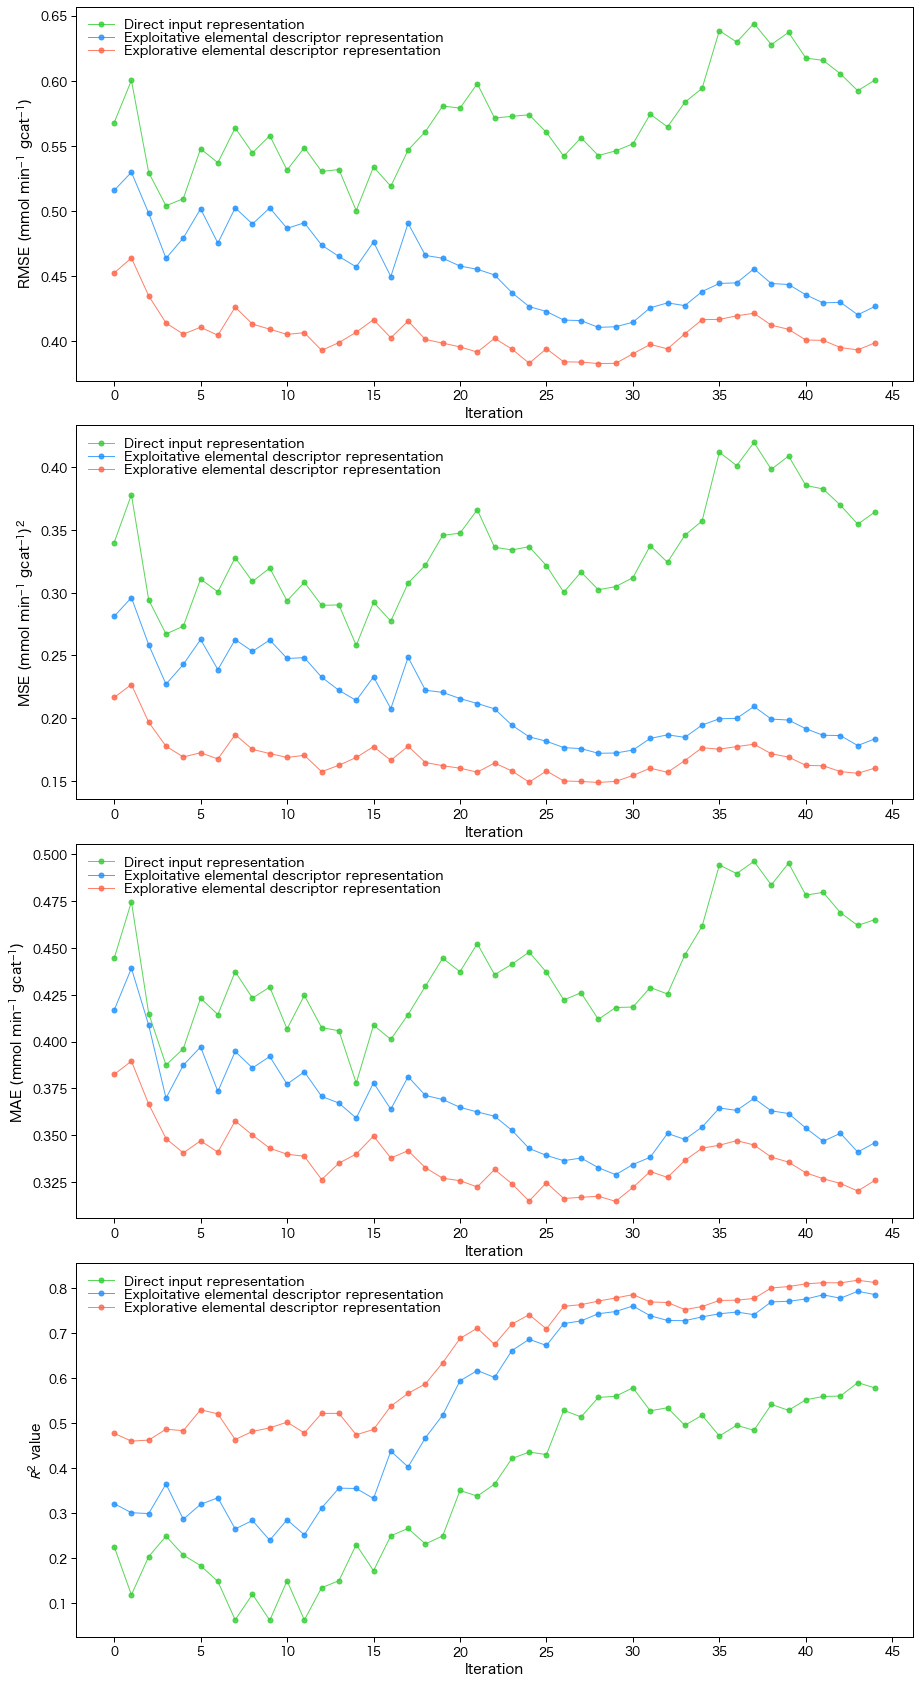

In [62]:
plot_loop_CV(condition, converted)

In [57]:
def plot_r2_and_target(condition, converted):
    # Basic setups.
    plt.rcParams["mathtext.fontset"] = "stixsans"
    date, Reaction = condition['date'], condition['Reaction']
    data, desc  = converted['data'], converted['desc']
    pgm_num, add_num, supp_num = condition['pgm_num'], condition['add_num'], condition['supp_num']

    num_loop_max = data['Iteration'].max()
    fig = plt.figure(facecolor='white', figsize=(15,18))
    # GridSpec Make objects
    gs = fig.add_gridspec(2, 3, width_ratios=[1,1,1], height_ratios=[1,2])
    plt.subplots_adjust(wspace=0.2, hspace=0.12)
    # Axes Make objects
    ax1 = fig.add_subplot(gs[0,:3])
    ax2 = fig.add_subplot(gs[1,:3])
    
    # Read csv files and plot R2 values.
    if pgm_num != 0 and add_num != 0 and supp_num != 0:
        CV_prop000 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop000_loop{num_loop_max}.csv')
        CV_prop001 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop001_loop{num_loop_max}.csv')
        CV_prop002 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop002_loop{num_loop_max}.csv')
        CV_prop010 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop010_loop{num_loop_max}.csv')
        CV_prop011 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop011_loop{num_loop_max}.csv')
        CV_prop012 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop012_loop{num_loop_max}.csv')
        CV_prop020 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop020_loop{num_loop_max}.csv')
        CV_prop021 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop021_loop{num_loop_max}.csv')
        CV_prop022 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop022_loop{num_loop_max}.csv')
        CV_prop100 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop100_loop{num_loop_max}.csv')
        CV_prop101 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop101_loop{num_loop_max}.csv')
        CV_prop102 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop102_loop{num_loop_max}.csv')
        CV_prop110 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop110_loop{num_loop_max}.csv')
        CV_prop111 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop111_loop{num_loop_max}.csv')
        CV_prop112 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop112_loop{num_loop_max}.csv')
        CV_prop120 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop120_loop{num_loop_max}.csv')
        CV_prop121 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop121_loop{num_loop_max}.csv')
        CV_prop122 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop122_loop{num_loop_max}.csv')
        CV_prop200 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop200_loop{num_loop_max}.csv')
        CV_prop201 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop201_loop{num_loop_max}.csv')
        CV_prop202 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop202_loop{num_loop_max}.csv')
        CV_prop210 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop210_loop{num_loop_max}.csv')
        CV_prop211 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop211_loop{num_loop_max}.csv')
        CV_prop212 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop212_loop{num_loop_max}.csv')
        CV_prop220 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop220_loop{num_loop_max}.csv')
        CV_prop221 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop221_loop{num_loop_max}.csv')
        CV_prop222 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop222_loop{num_loop_max}.csv')
        
        ax1.plot(CV_prop000['tes_r2'], marker="s", markersize=3, color='green', linestyle='solid', linewidth=1, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 000')
        ax1.plot(CV_prop111['tes_r2'], marker="s", markersize=3, color='blue', linestyle='solid', linewidth=1, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 111')
        ax1.plot(CV_prop222['tes_r2'], marker="s", markersize=3, color='red', linestyle='solid', linewidth=1, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 222')
        
        ax1.plot(CV_prop022['tes_r2'], marker="D", markersize=2, color='pink', linestyle='solid', linewidth=0.7, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 022')
        ax1.plot(CV_prop202['tes_r2'], marker="D", markersize=2, color='pink', linestyle='solid', linewidth=0.7, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 202')
        ax1.plot(CV_prop220['tes_r2'], marker="D", markersize=2, color='pink', linestyle='solid', linewidth=0.7, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 220')
        ax1.plot(CV_prop122['tes_r2'], marker="D", markersize=2, color='magenta', linestyle='solid', linewidth=0.7, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 122')
        ax1.plot(CV_prop212['tes_r2'], marker="D", markersize=2, color='magenta', linestyle='solid', linewidth=0.7, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 212')
        ax1.plot(CV_prop221['tes_r2'], marker="D", markersize=2, color='magenta', linestyle='solid', linewidth=0.7, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 221')
        
        ax1.plot(CV_prop011['tes_r2'], marker="o", markersize=3, color='aqua', linestyle='dashed', linewidth=1, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 011')
        ax1.plot(CV_prop101['tes_r2'], marker="o", markersize=3, color='aqua', linestyle='dashed', linewidth=1, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 101')
        ax1.plot(CV_prop110['tes_r2'], marker="o", markersize=3, color='aqua', linestyle='dashed', linewidth=1, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 110')
        ax1.plot(CV_prop112['tes_r2'], marker="o", markersize=3, color='dodgerblue', linestyle='dashed', linewidth=1, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 112')
        ax1.plot(CV_prop121['tes_r2'], marker="o", markersize=3, color='dodgerblue', linestyle='dashed', linewidth=1, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 121')
        ax1.plot(CV_prop211['tes_r2'], marker="o", markersize=3, color='dodgerblue', linestyle='dashed', linewidth=1, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 211')
        
        ax1.plot(CV_prop001['tes_r2'], marker="v", markersize=3, color='greenyellow', linestyle='dashdot', linewidth=1, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 001')
        ax1.plot(CV_prop010['tes_r2'], marker="v", markersize=3, color='greenyellow', linestyle='dashdot', linewidth=1, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 010')
        ax1.plot(CV_prop100['tes_r2'], marker="v", markersize=3, color='greenyellow', linestyle='dashdot', linewidth=1, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 100')
        ax1.plot(CV_prop002['tes_r2'], marker="v", markersize=3, color='limegreen', linestyle='dashdot', linewidth=1, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 002')
        ax1.plot(CV_prop020['tes_r2'], marker="v", markersize=3, color='limegreen', linestyle='dashdot', linewidth=1, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 020')
        ax1.plot(CV_prop200['tes_r2'], marker="v", markersize=3, color='limegreen', linestyle='dashdot', linewidth=1, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 200')
        
        ax1.plot(CV_prop012['tes_r2'], marker="^", markersize=4, color='grey', linestyle='dotted', linewidth=1, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 012')
        ax1.plot(CV_prop021['tes_r2'], marker="^", markersize=4, color='grey', linestyle='dotted', linewidth=1, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 021')
        ax1.plot(CV_prop102['tes_r2'], marker="^", markersize=4, color='grey', linestyle='dotted', linewidth=1, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 102')
        ax1.plot(CV_prop120['tes_r2'], marker="^", markersize=4, color='grey', linestyle='dotted', linewidth=1, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 120')
        ax1.plot(CV_prop201['tes_r2'], marker="^", markersize=4, color='grey', linestyle='dotted', linewidth=1, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 201')
        ax1.plot(CV_prop210['tes_r2'], marker="^", markersize=4, color='grey', linestyle='dotted', linewidth=1, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 210')
    
    elif pgm_num == 0 and add_num != 0 and supp_num != 0:
        CV_prop_00 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop__00_loop{num_loop_max}.csv')
        CV_prop_01 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop__01_loop{num_loop_max}.csv')
        CV_prop_02 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop__02_loop{num_loop_max}.csv')
        CV_prop_10 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop__10_loop{num_loop_max}.csv')
        CV_prop_11 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop__11_loop{num_loop_max}.csv')
        CV_prop_12 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop__12_loop{num_loop_max}.csv')
        CV_prop_20 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop__20_loop{num_loop_max}.csv')
        CV_prop_21 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop__21_loop{num_loop_max}.csv')
        CV_prop_22 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop__22_loop{num_loop_max}.csv')

        ax1.plot(CV_prop_00['tes_r2'], marker="o", markersize=3, color='green', linestyle='solid', linewidth=2, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 00')
        ax1.plot(CV_prop_11['tes_r2'], marker="o", markersize=3, color='blue', linestyle='solid', linewidth=2, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 11')
        ax1.plot(CV_prop_22['tes_r2'], marker="o", markersize=3, color='red', linestyle='solid', linewidth=2, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 22')
        ax1.plot(CV_prop_01['tes_r2'], marker="o", markersize=2, color='dodgerblue', linestyle='dashed', linewidth=1, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 01')
        ax1.plot(CV_prop_02['tes_r2'], marker="o", markersize=2, color='magenta', linestyle='dashed', linewidth=1, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 02')
        ax1.plot(CV_prop_10['tes_r2'], marker="o", markersize=2, color='lightseagreen', linestyle='dashed', linewidth=1, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 10')
        ax1.plot(CV_prop_12['tes_r2'], marker="o", markersize=2, color='orangered', linestyle='dashed', linewidth=1, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 12')
        ax1.plot(CV_prop_20['tes_r2'], marker="o", markersize=2, color='blueviolet', linestyle='dashed', linewidth=1, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 20')
        ax1.plot(CV_prop_21['tes_r2'], marker="o", markersize=2, color='orange', linestyle='dashed', linewidth=1, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 21')
    
    elif pgm_num != 0 and add_num == 0 and supp_num != 0:
        CV_prop0_0 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop0__0_loop{num_loop_max}.csv')
        CV_prop0_1 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop0__1_loop{num_loop_max}.csv')
        CV_prop0_2 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop0__2_loop{num_loop_max}.csv')
        CV_prop1_0 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop1__0_loop{num_loop_max}.csv')
        CV_prop1_1 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop1__1_loop{num_loop_max}.csv')
        CV_prop1_2 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop1__2_loop{num_loop_max}.csv')
        CV_prop2_0 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop2__0_loop{num_loop_max}.csv')
        CV_prop2_1 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop2__1_loop{num_loop_max}.csv')
        CV_prop2_2 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop2__2_loop{num_loop_max}.csv')

        ax1.plot(CV_prop0_0['tes_r2'], marker="o", markersize=3, color='green', linestyle='solid', linewidth=2, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 00')
        ax1.plot(CV_prop1_1['tes_r2'], marker="o", markersize=3, color='blue', linestyle='solid', linewidth=2, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 11')
        ax1.plot(CV_prop2_2['tes_r2'], marker="o", markersize=3, color='red', linestyle='solid', linewidth=2, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 22')
        ax1.plot(CV_prop0_1['tes_r2'], marker="o", markersize=2, color='dodgerblue', linestyle='dashed', linewidth=1, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 01')
        ax1.plot(CV_prop0_2['tes_r2'], marker="o", markersize=2, color='magenta', linestyle='dashed', linewidth=1, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 02')
        ax1.plot(CV_prop1_0['tes_r2'], marker="o", markersize=2, color='lightseagreen', linestyle='dashed', linewidth=1, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 10')
        ax1.plot(CV_prop1_2['tes_r2'], marker="o", markersize=2, color='orangered', linestyle='dashed', linewidth=1, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 12')
        ax1.plot(CV_prop2_0['tes_r2'], marker="o", markersize=2, color='blueviolet', linestyle='dashed', linewidth=1, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 20')
        ax1.plot(CV_prop2_1['tes_r2'], marker="o", markersize=2, color='orange', linestyle='dashed', linewidth=1, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 21')

    elif pgm_num != 0 and add_num != 0 and supp_num == 0:
        CV_prop00_ = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop00__loop{num_loop_max}.csv')
        CV_prop01_ = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop01__loop{num_loop_max}.csv')
        CV_prop02_ = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop02__loop{num_loop_max}.csv')
        CV_prop10_ = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop10__loop{num_loop_max}.csv')
        CV_prop11_ = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop11__loop{num_loop_max}.csv')
        CV_prop12_ = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop12__loop{num_loop_max}.csv')
        CV_prop20_ = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop20__loop{num_loop_max}.csv')
        CV_prop21_ = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop21__loop{num_loop_max}.csv')
        CV_prop22_ = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop22__loop{num_loop_max}.csv')

        ax1.plot(CV_prop00_['tes_r2'], marker="o", markersize=3, color='green', linestyle='solid', linewidth=2, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 00')
        ax1.plot(CV_prop11_['tes_r2'], marker="o", markersize=3, color='blue', linestyle='solid', linewidth=2, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 11')
        ax1.plot(CV_prop22_['tes_r2'], marker="o", markersize=3, color='red', linestyle='solid', linewidth=2, alpha=1.0, label='$\it{R}$$^{2}$ value: ML method 22')
        ax1.plot(CV_prop01_['tes_r2'], marker="o", markersize=2, color='dodgerblue', linestyle='dashed', linewidth=1, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 01')
        ax1.plot(CV_prop02_['tes_r2'], marker="o", markersize=2, color='magenta', linestyle='dashed', linewidth=1, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 02')
        ax1.plot(CV_prop10_['tes_r2'], marker="o", markersize=2, color='lightseagreen', linestyle='dashed', linewidth=1, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 10')
        ax1.plot(CV_prop12_['tes_r2'], marker="o", markersize=2, color='orangered', linestyle='dashed', linewidth=1, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 12')
        ax1.plot(CV_prop20_['tes_r2'], marker="o", markersize=2, color='blueviolet', linestyle='dashed', linewidth=1, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 20')
        ax1.plot(CV_prop21_['tes_r2'], marker="o", markersize=2, color='orange', linestyle='dashed', linewidth=1, alpha=0.7, label='$\it{R}$$^{2}$ value: ML method 21')

    elif pgm_num == 0 and add_num != 0 and supp_num == 0:
        CV_prop0 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop0_loop{num_loop_max}.csv')
        CV_prop1 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop1_loop{num_loop_max}.csv')
        CV_prop2 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop2_loop{num_loop_max}.csv')
        
        ax1.plot(CV_prop0['tes_r2'], marker="o", markersize=5, color='limegreen', linestyle='solid', linewidth=1, alpha=0.8, label='Direct input representation')
        ax1.plot(CV_prop1['tes_r2'], marker="o", markersize=5, color='dodgerblue', linestyle='solid', linewidth=1, alpha=0.8, label='Exploitative elemental descriptor representation')
        ax1.plot(CV_prop2['tes_r2'], marker="o", markersize=5, color='tomato', linestyle='solid', linewidth=1, alpha=0.8, label='Explorative elemental descriptor representation')

    Iteration = {}
    idx = data['Iteration']==0
    Iteration[0] = data[idx]
    Iteration[0] = Iteration[0].drop(['No.', 'CO Yield_%', 'CO formation rate_mmol min-1 gcat-1','Catal prep', 'Reaction', 'Note', 'Iteration'], axis=1)
    max_iteration = data['Iteration'].max()
    data_count = data.drop(['No.', 'CO Yield_%', 'CO formation rate_mmol min-1 gcat-1','Catal prep', 'Reaction', 'Note', 'Iteration'], axis=1)
    data_elem_num_0 = pd.DataFrame(index=desc.index, columns=['Num_elem']).fillna(0)

    for i in range(len(Iteration[0])):
        for j in range(pgm_num):
            if Iteration[0].loc[i, f'PGM{j+1}_wt%'] > 0:
                data_elem_num_0.loc[Iteration[0].loc[i, f'PGM{j+1}']] += 1
            elif Iteration[0].loc[i, f'PGM{j+1}_wt%'] == 0:
                data_elem_num_0.loc[Iteration[0].loc[i, f'PGM{j+1}']] += 0
        for j in range(add_num):
            if Iteration[0].loc[i, f'Ad{j+1}_wt%'] > 0:
                data_elem_num_0.loc[Iteration[0].loc[i, f'Ad{j+1}']] += 1
            elif Iteration[0].loc[i, f'Ad{j+1}_wt%'] == 0:
                data_elem_num_0.loc[Iteration[0].loc[i, f'Ad{j+1}']] += 0

    data_elem_num_0 = data_elem_num_0[data_elem_num_0['Num_elem'] != 0]
    data_elem_num_0.to_csv(f'{PATH2}/data_elem_num_0.csv', header=None)
    elem_list_original = list(data_elem_num_0.index)

    data_elem_num_now = pd.DataFrame(index=desc.index, columns=['Num_elem']).fillna(0)
    for i in range(len(data)):
        for j in range(pgm_num):
            if data_count.loc[i, f'PGM{j+1}_wt%'] > 0:
                data_elem_num_now.loc[data_count.loc[i, f'PGM{j+1}']] += 1
            elif data_count.loc[i, f'PGM{j+1}_wt%'] == 0:
                data_elem_num_now.loc[data_count.loc[i, f'PGM{j+1}']] += 0
        for j in range(add_num):
            if data_count.loc[i, f'Ad{j+1}_wt%'] > 0:
                data_elem_num_now.loc[data_count.loc[i, f'Ad{j+1}']] += 1
            elif data_count.loc[i, f'Ad{j+1}_wt%'] == 0:
                data_elem_num_now.loc[data_count.loc[i, f'Ad{j+1}']] += 0

    data_elem_num_now = data_elem_num_now[data_elem_num_now['Num_elem'] != 0]
    data_elem_num_now.to_csv(f'{PATH2}/data_elem_num_{max_iteration}.csv', header=None)
    elem_list_now = list(data_elem_num_now.index)
    new_elem_list = list(set(elem_list_now) - set(elem_list_original))

    if num_loop_max <= 10:
        x_notch_num = 1
    elif num_loop_max > 10 and num_loop_max <= 20:
        x_notch_num = 2
    elif num_loop_max > 20 and num_loop_max <= 30:
        x_notch_num = 3
    elif num_loop_max > 30 and num_loop_max <= 50:
        x_notch_num = 5
    elif num_loop_max > 50:
        x_notch_num = 10
    
    if pgm_num != 0 and add_num != 0 and supp_num != 0:
        ncols = 2
    else:
        ncols = 1
        
    ax1.set_xticks(np.arange(0, num_loop_max+2, x_notch_num))
    ax1.tick_params(direction="out", length=6, colors="black", labelsize=16)

    if pgm_num == 0 and add_num != 0 and supp_num == 0:
        ax1.legend(fontsize=18, markerscale=1, labelspacing=1E-15, frameon=False)
    else:
        ax1.legend(fontsize=18, markerscale=1, bbox_to_anchor=(1.01, 1.00), loc='upper left', ncol=ncols, frameon=False)

    ax1.set_ylim(auto=True)
    ax1.set_xlabel('Iteration', fontsize=18)
    ax1.set_ylabel('$\it{R}$$^{2}$ value', fontsize=18)
    ax1.legend(bbox_to_anchor=(1, 0), loc='lower right', borderaxespad=0.5, markerscale=1.2, fontsize=16, frameon=False)
    
    Top_catal = data[data[target_name] == data[target_name].max()]
    data = data.drop(Top_catal.index, axis=0)

    data_Mo = pd.concat([data[data['Ad1'] == 'Mo'], data[data['Ad2'] == 'Mo'], data[data['Ad3'] == 'Mo'], data[data['Ad4'] == 'Mo'], data[data['Ad5'] == 'Mo']], axis=0).drop_duplicates()
    data_MoRb = pd.concat([data_Mo[data_Mo['Ad1'] == 'Rb'], data_Mo[data_Mo['Ad2'] == 'Rb'], data_Mo[data_Mo['Ad3'] == 'Rb'], data_Mo[data_Mo['Ad4'] == 'Rb'], data_Mo[data_Mo['Ad5'] == 'Rb']], axis=0).drop_duplicates()
    data_MoNb = pd.concat([data_Mo[data_Mo['Ad1'] == 'Nb'], data_Mo[data_Mo['Ad2'] == 'Nb'], data_Mo[data_Mo['Ad3'] == 'Nb'], data_Mo[data_Mo['Ad4'] == 'Nb'], data_Mo[data_Mo['Ad5'] == 'Nb']], axis=0).drop_duplicates()
    data_MoRbNb = pd.concat([data_MoRb[data_MoRb['Ad1'] == 'Nb'], data_MoRb[data_MoRb['Ad2'] == 'Nb'], data_MoRb[data_MoRb['Ad3'] == 'Nb'], data_MoRb[data_MoRb['Ad4'] == 'Nb'], data_MoRb[data_MoRb['Ad5'] == 'Nb']], axis=0).drop_duplicates()
    for i in range(add_num):
        drop_catal = data_MoRbNb[data_MoRbNb[f'Ad{i+1}'] == 'Ba']
        data_MoRbNb = data_MoRbNb.drop(drop_catal.index, axis=0)
    data_MoRbNb = data_MoRbNb.drop_duplicates(keep=False)
    
    data_MoBa = pd.concat([data_Mo[data_Mo['Ad1'] == 'Ba'], data_Mo[data_Mo['Ad2'] == 'Ba'], data_Mo[data_Mo['Ad3'] == 'Ba'], data_Mo[data_Mo['Ad4'] == 'Ba'], data_Mo[data_Mo['Ad5'] == 'Ba']], axis=0).drop_duplicates()
    data_MoBaNb = pd.concat([data_MoBa[data_MoBa['Ad1'] == 'Nb'], data_MoBa[data_MoBa['Ad2'] == 'Nb'], data_MoBa[data_MoBa['Ad3'] == 'Nb'], data_MoBa[data_MoBa['Ad4'] == 'Nb'], data_MoBa[data_MoBa['Ad5'] == 'Nb']], axis=0).drop_duplicates()
    for i in range(add_num):
        drop_catal = data_MoBaNb[data_MoBaNb[f'Ad{i+1}'] == 'Rb']
        data_MoBaNb = data_MoBaNb.drop(drop_catal.index, axis=0)
    data_MoBaNb = data_MoBaNb.drop_duplicates(keep=False)

    data_MoBaRb = pd.concat([data_MoBa[data_MoBa['Ad1'] == 'Rb'], data_MoBa[data_MoBa['Ad2'] == 'Rb'], data_MoBa[data_MoBa['Ad3'] == 'Rb'], data_MoBa[data_MoBa['Ad4'] == 'Rb'], data_MoBa[data_MoBa['Ad5'] == 'Rb']], axis=0).drop_duplicates()
    for i in range(add_num):
        drop_catal = data_MoBaRb[data_MoBaRb[f'Ad{i+1}'] == 'Nb']
        data_MoBaRb = data_MoBaRb.drop(drop_catal.index, axis=0)
    data_MoBaRb = data_MoBaRb.drop_duplicates(keep=False)
    
    data_Ba = pd.concat([data[data['Ad1'] == 'Ba'], data[data['Ad2'] == 'Ba'], data[data['Ad3'] == 'Ba'], data[data['Ad4'] == 'Ba'], data[data['Ad5'] == 'Ba']], axis=0).drop_duplicates()
    data_BaRb = pd.concat([data_Ba[data_Ba['Ad1'] == 'Rb'], data_Ba[data_Ba['Ad2'] == 'Rb'], data_Ba[data_Ba['Ad3'] == 'Rb'], data_Ba[data_Ba['Ad4'] == 'Rb'], data_Ba[data_Ba['Ad5'] == 'Rb']], axis=0).drop_duplicates()
    data_BaRbNb = pd.concat([data_BaRb[data_BaRb['Ad1'] == 'Nb'], data_BaRb[data_BaRb['Ad2'] == 'Nb'], data_BaRb[data_BaRb['Ad3'] == 'Nb'], data_BaRb[data_BaRb['Ad4'] == 'Nb'], data_BaRb[data_BaRb['Ad5'] == 'Nb']], axis=0).drop_duplicates()
    for i in range(add_num):
        drop_catal = data_BaRbNb[data_BaRbNb[f'Ad{i+1}'] == 'Mo']
        data_BaRbNb = data_BaRbNb.drop(drop_catal.index, axis=0)
    data_BaRbNb = data_BaRbNb.drop_duplicates(keep=False)

    drop_catal_list = list(data_BaRbNb.index) + list(data_MoBaNb.index) + list(data_MoBaRb.index) + list(data_MoRbNb.index)
    data = data.drop(drop_catal_list, axis=0)
    data_Mo = pd.concat([data[data['Ad1'] == 'Mo'], data[data['Ad2'] == 'Mo'], data[data['Ad3'] == 'Mo'], data[data['Ad4'] == 'Mo'], data[data['Ad5'] == 'Mo']], axis=0).drop_duplicates()
    data_MoBa = pd.concat([data_Mo[data_Mo['Ad1'] == 'Ba'], data_Mo[data_Mo['Ad2'] == 'Ba'], data_Mo[data_Mo['Ad3'] == 'Ba'], data_Mo[data_Mo['Ad4'] == 'Ba'], data_Mo[data_Mo['Ad5'] == 'Ba']], axis=0).drop_duplicates()
    data = data.drop(data_MoBa.index, axis=0)
    data_Mo = data_Mo.drop(data_MoBa.index, axis=0)
    data_MoRb = pd.concat([data_Mo[data_Mo['Ad1'] == 'Rb'], data_Mo[data_Mo['Ad2'] == 'Rb'], data_Mo[data_Mo['Ad3'] == 'Rb'], data_Mo[data_Mo['Ad4'] == 'Rb'], data_Mo[data_Mo['Ad5'] == 'Rb']], axis=0).drop_duplicates()
    data = data.drop(data_MoRb.index, axis=0)
    data_Mo = data_Mo.drop(data_MoRb.index, axis=0)
    data_MoNb = pd.concat([data_Mo[data_Mo['Ad1'] == 'Nb'], data_Mo[data_Mo['Ad2'] == 'Nb'], data_Mo[data_Mo['Ad3'] == 'Nb'], data_Mo[data_Mo['Ad4'] == 'Nb'], data_Mo[data_Mo['Ad5'] == 'Nb']], axis=0).drop_duplicates()
    data = data.drop(data_MoNb.index, axis=0)
    data_Mo = data_Mo.drop(data_MoNb.index, axis=0)
    data = data.drop(data_Mo.index, axis=0).reset_index()

    # Max Target value
    if Reaction == 'rwgs_250' or Reaction == 'rwgs_250_1wt':
        ax2.scatter(Top_catal['Iteration'], Top_catal[target_name], zorder=3, s=40, marker='D', alpha=1, color='red')
        ax2.scatter([], [], zorder=3, s=40, marker=',', alpha=1, color='red', label='Rb-Ba-Mo-Nb')
        
        for i in range(len(new_elem_list)):
            data_MoBaRb_new_elems = pd.concat([data_MoBaRb[data_MoBaRb['Ad1'] == new_elem_list[i]], data_MoBaRb[data_MoBaRb['Ad2'] == new_elem_list[i]], data_MoBaRb[data_MoBaRb['Ad3'] == new_elem_list[i]], data_MoBaRb[data_MoBaRb['Ad4'] == new_elem_list[i]], data_MoBaRb[data_MoBaRb['Ad5'] == new_elem_list[i]]], axis=0).drop_duplicates(keep=False)
            data_MoBaRb = data_MoBaRb.drop(data_MoBaRb_new_elems.index, axis=0)
            #data_conv_elems = data.drop(data_new_elems.index, axis=0)
            x_new, y_new = data_MoBaRb_new_elems['Iteration'], data_MoBaRb_new_elems[target_name]
            if i == 0:
                ax2.scatter(x_new, y_new, zorder=2, s=40, marker='D', alpha=0.4, color='blue')
                ax2.scatter([], [], zorder=2, s=40, marker=',', alpha=0.4, color='blue', label='Rb-Ba-Mo')
            elif i != 0 and len(x_new) != 0:
                ax2.scatter(x_new, y_new, zorder=2, s=40, marker='D', alpha=0.4, color='blue')
            elif i != 0 and len(x_new) == 0:
                pass

        for i in range(len(elem_list_original)):
            data_MoBaRb_conv_elems = pd.concat([data_MoBaRb[data_MoBaRb['Ad1'] == elem_list_original[i]], data_MoBaRb[data_MoBaRb['Ad2'] == elem_list_original[i]], data_MoBaRb[data_MoBaRb['Ad3'] == elem_list_original[i]], data_MoBaRb[data_MoBaRb['Ad4'] == elem_list_original[i]], data_MoBaRb[data_MoBaRb['Ad5'] == elem_list_original[i]]], axis=0).drop_duplicates(keep=False)
            data_MoBaRb = data_MoBaRb.drop(data_MoBaRb_conv_elems.index, axis=0)
            x_conv, y_conv = data_MoBaRb_conv_elems['Iteration'], data_MoBaRb_conv_elems[target_name]
            if i == 0 and len(x_conv) != 0:
                ax2.scatter(x_conv, y_conv, zorder=2, s=40, marker='o', alpha=0.4, color='blue')
            elif i != 0 and len(x_conv) != 0:
                ax2.scatter(x_conv, y_conv, zorder=2, s=40, marker='o', alpha=0.4, color='blue')
            elif i != 0 and len(x_conv) == 0:
                pass
        
        ax2.scatter(data_BaRbNb['Iteration'], data_BaRbNb[target_name], zorder=3, s=40, marker='D', alpha=0.4, color='blueviolet')
        ax2.scatter([], [], zorder=3, s=40, marker=',', alpha=0.4, color='blueviolet', label='Rb-Ba-Nb')
        ax2.scatter(data_MoRbNb['Iteration'], data_MoRbNb[target_name], zorder=3, s=40, marker='D', alpha=0.4, color='green')
        ax2.scatter([], [], zorder=3, s=40, marker=',', alpha=0.4, color='green', label='Rb-Mo-Nb')
        ax2.scatter(data_MoBaNb['Iteration'], data_MoBaNb[target_name], zorder=3, s=40, marker='D', alpha=0.4, color='orangered')
        ax2.scatter([], [], zorder=3, s=40, marker=',', alpha=0.4, color='orangered', label='Ba-Mo-Nb')
        #
        for i in range(len(new_elem_list)):
            data_MoRb_new_elems = pd.concat([data_MoRb[data_MoRb['Ad1'] == new_elem_list[i]], data_MoRb[data_MoRb['Ad2'] == new_elem_list[i]], data_MoRb[data_MoRb['Ad3'] == new_elem_list[i]], data_MoRb[data_MoRb['Ad4'] == new_elem_list[i]], data_MoRb[data_MoRb['Ad5'] == new_elem_list[i]]], axis=0).drop_duplicates(keep=False)
            data_MoRb = data_MoRb.drop(data_MoRb_new_elems.index, axis=0)
            #data_conv_elems = data.drop(data_new_elems.index, axis=0)
            x_new, y_new = data_MoRb_new_elems['Iteration'], data_MoRb_new_elems[target_name]
            if i == 0:
                ax2.scatter(x_new, y_new, zorder=2, s=40, marker='D', alpha=0.4, color='lime')
                ax2.scatter([], [], zorder=2, s=40, marker=',', alpha=0.4, color='lime', label='Rb-Mo')
            elif i != 0 and len(x_new) != 0:
                ax2.scatter(x_new, y_new, zorder=2, s=40, marker='D', alpha=0.4, color='lime')
            elif i != 0 and len(x_new) == 0:
                pass

        for i in range(len(elem_list_original)):
            data_MoRb_conv_elems = pd.concat([data_MoRb[data_MoRb['Ad1'] == elem_list_original[i]], data_MoRb[data_MoRb['Ad2'] == elem_list_original[i]], data_MoRb[data_MoRb['Ad3'] == elem_list_original[i]], data_MoRb[data_MoRb['Ad4'] == elem_list_original[i]], data_MoRb[data_MoRb['Ad5'] == elem_list_original[i]]], axis=0).drop_duplicates(keep=False)
            data_MoRb = data_MoRb.drop(data_MoRb_conv_elems.index, axis=0)
            x_conv, y_conv = data_MoRb_conv_elems['Iteration'], data_MoRb_conv_elems[target_name]
            if i == 0 and len(x_conv) != 0:
                ax2.scatter(x_conv, y_conv, zorder=2, s=40, marker='o', alpha=0.4, color='lime')
            elif i != 0 and len(x_conv) != 0:
                ax2.scatter(x_conv, y_conv, zorder=2, s=40, marker='o', alpha=0.4, color='lime')
            elif i != 0 and len(x_conv) == 0:
                pass
        
        #
        for i in range(len(new_elem_list)):
            data_MoBa_new_elems = pd.concat([data_MoBa[data_MoBa['Ad1'] == new_elem_list[i]], data_MoBa[data_MoBa['Ad2'] == new_elem_list[i]], data_MoBa[data_MoBa['Ad3'] == new_elem_list[i]], data_MoBa[data_MoBa['Ad4'] == new_elem_list[i]], data_MoBa[data_MoBa['Ad5'] == new_elem_list[i]]], axis=0).drop_duplicates(keep=False)
            data_MoBa = data_MoBa.drop(data_MoBa_new_elems.index, axis=0)
            #data_conv_elems = data.drop(data_new_elems.index, axis=0)
            x_new, y_new = data_MoBa_new_elems['Iteration'], data_MoBa_new_elems[target_name]
            if i == 0:
                ax2.scatter(x_new, y_new, zorder=4, s=40, marker='D', alpha=0.5, color='dodgerblue')
                ax2.scatter([], [], zorder=2, s=40, marker=',', alpha=0.5, color='dodgerblue', label='Ba-Mo')
            elif i != 0 and len(x_new) != 0:
                ax2.scatter(x_new, y_new, zorder=2, s=40, marker='D', alpha=0.5, color='dodgerblue')
            elif i != 0 and len(x_new) == 0:
                pass

        for i in range(len(elem_list_original)):
            data_MoBa_conv_elems = pd.concat([data_MoBa[data_MoBa['Ad1'] == elem_list_original[i]], data_MoBa[data_MoBa['Ad2'] == elem_list_original[i]], data_MoBa[data_MoBa['Ad3'] == elem_list_original[i]], data_MoBa[data_MoBa['Ad4'] == elem_list_original[i]], data_MoBa[data_MoBa['Ad5'] == elem_list_original[i]]], axis=0).drop_duplicates(keep=False)
            data_MoBa = data_MoBa.drop(data_MoBa_conv_elems.index, axis=0)
            x_conv, y_conv = data_MoBa_conv_elems['Iteration'], data_MoBa_conv_elems[target_name]
            if i == 0 and len(x_conv) != 0:
                ax2.scatter(x_conv, y_conv, zorder=2, s=40, marker='o', alpha=0.5, color='dodgerblue')
            elif i != 0 and len(x_conv) != 0:
                ax2.scatter(x_conv, y_conv, zorder=2, s=40, marker='o', alpha=0.5, color='dodgerblue')
            elif i != 0 and len(x_conv) == 0:
                pass
        
        ax2.scatter(data_MoNb['Iteration'], data_MoNb[target_name], zorder=3, s=40, marker='D', alpha=0.6, color='teal')
        ax2.scatter([], [], zorder=3, s=40, marker=',', alpha=0.6, color='teal', label='Mo-Nb')
        
        #
        for i in range(len(new_elem_list)):
            data_Mo_new_elems = pd.concat([data_Mo[data_Mo['Ad1'] == new_elem_list[i]], data_Mo[data_Mo['Ad2'] == new_elem_list[i]], data_Mo[data_Mo['Ad3'] == new_elem_list[i]], data_Mo[data_Mo['Ad4'] == new_elem_list[i]], data_Mo[data_Mo['Ad5'] == new_elem_list[i]]], axis=0).drop_duplicates(keep=False)
            data_Mo = data_Mo.drop(data_Mo_new_elems.index, axis=0)
            #data_conv_elems = data.drop(data_new_elems.index, axis=0)
            x_new, y_new = data_Mo_new_elems['Iteration'], data_Mo_new_elems[target_name]
            if i == 0:
                ax2.scatter(x_new, y_new, zorder=2, s=40, marker='D', alpha=0.4, color='hotpink')
                ax2.scatter([], [], zorder=2, s=40, marker=',', alpha=0.4, color='hotpink', label='Mo')
            elif i != 0 and len(x_new) != 0:
                ax2.scatter(x_new, y_new, zorder=2, s=40, marker='D', alpha=0.4, color='hotpink')
            elif i != 0 and len(x_new) == 0:
                pass

        for i in range(len(elem_list_original)):
            data_Mo_conv_elems = pd.concat([data_Mo[data_Mo['Ad1'] == elem_list_original[i]], data_Mo[data_Mo['Ad2'] == elem_list_original[i]], data_Mo[data_Mo['Ad3'] == elem_list_original[i]], data_Mo[data_Mo['Ad4'] == elem_list_original[i]], data_Mo[data_Mo['Ad5'] == elem_list_original[i]]], axis=0).drop_duplicates(keep=False)
            data_Mo = data_Mo.drop(data_Mo_conv_elems.index, axis=0)
            x_conv, y_conv = data_Mo_conv_elems['Iteration'], data_Mo_conv_elems[target_name]
            if i == 0 and len(x_conv) != 0:
                ax2.scatter(x_conv, y_conv, zorder=2, s=30, marker='o', alpha=0.4, color='hotpink')
            elif i != 0 and len(x_conv) != 0:
                ax2.scatter(x_conv, y_conv, zorder=2, s=30, marker='o', alpha=0.4, color='hotpink')
            elif i != 0 and len(x_conv) == 0:
                pass
        
        for i in range(len(new_elem_list)):
            data_new_elems = pd.concat([data[data['Ad1'] == new_elem_list[i]], data[data['Ad2'] == new_elem_list[i]], data[data['Ad3'] == new_elem_list[i]], data[data['Ad4'] == new_elem_list[i]], data[data['Ad5'] == new_elem_list[i]]], axis=0).drop_duplicates(keep=False)
            data = data.drop(data_new_elems.index, axis=0)
            #data_conv_elems = data.drop(data_new_elems.index, axis=0)
            x_new, y_new = data_new_elems['Iteration'], data_new_elems[target_name]
            if i == 0 and len(x_new) != 0:
                ax2.scatter(x_new, y_new, zorder=2, s=40, marker='o', alpha=0.4, color='grey')
            elif i != 0 and len(x_new) != 0:
                ax2.scatter(x_new, y_new, zorder=2, s=40, marker='o', alpha=0.4, color='grey')
            elif i != 0 and len(x_new) != 0:
                pass
            
        for i in range(len(elem_list_original)):
            data_conv_elems = pd.concat([data[data['Ad1'] == elem_list_original[i]], data[data['Ad2'] == elem_list_original[i]], data[data['Ad3'] == elem_list_original[i]], data[data['Ad4'] == elem_list_original[i]], data[data['Ad5'] == elem_list_original[i]]], axis=0).drop_duplicates(keep=False)
            data = data.drop(data_conv_elems.index, axis=0)
            x_conv, y_conv = data_conv_elems['Iteration'], data_conv_elems[target_name]
            if i == 0 and len(x_conv) != 0:
                ax2.scatter(x_conv, y_conv, zorder=2, s=40, marker='o', alpha=0.4, color='grey')
            elif i != 0 and len(x_conv) != 0:
                ax2.scatter(x_conv, y_conv, zorder=2, s=40, marker='o', alpha=0.4, color='grey')
            elif i != 0 and len(x_conv) != 0:
                pass

        #ax2.plot(max_target[target_name], zorder=2, color='k', alpha=1, linewidth=1, label='Max CO formation rate')
        ax2.step(np.arange(0, 45, 1), max_target[target_name], where='post', zorder=2, color='k', alpha=0.8, linewidth=1, label='Max CO formation rate')
        ax2.set_xticks(np.arange(0, num_loop_max+2, x_notch_num))
        ax2.tick_params(direction="out", length=6, colors="black", labelsize=16)
        ax2.set_xlabel('Iteration', fontsize=18)
        ax2.set_ylabel('Best CO form rate (mmol $min^{{-}1}$ $gcat^{{-}1}$)', fontsize=18)

        #plt.ylim(2.4, 4)
        ax2.set_ylim(0, 4.5)
        data, desc  = converted['data'], converted['desc']
        ax2.hlines(2.554, 0, data['Iteration'].max(), color='grey', linestyle='dashed', zorder=1, alpha=0.7)
        ax2.hlines(0.45, data['Iteration'].max()-10, data['Iteration'].max()-7.5, color='grey', linestyle='dashed')
        ax2.text(data['Iteration'].max()-7, 0.41, "$Pt(3)/Mo(10)/TiO_{2}$", fontsize=16)

        ax2.hlines(0.870, 0, data['Iteration'].max(), color='grey', linestyle='dashdot', zorder=1, alpha=0.7)
        ax2.hlines(0.25, data['Iteration'].max()-10, data['Iteration'].max()-7.5, color='grey', linestyle='dashdot')
        ax2.text(data['Iteration'].max()-7, 0.21, "$Cu/ZnO/Al_{2}O_{3}$", fontsize=16)

        ax2.set_xlabel('Iteration', fontsize=18)
        ax2.set_ylabel('CO formation rate (mmol $min^{{-}1}$ $gcat^{{-}1}$)', fontsize=18)
        ax2.legend(bbox_to_anchor=(0, 1), loc='upper left', borderaxespad=0.5, markerscale=1,  fontsize=16, frameon=False)
        plt.savefig(f'{PATH}/{date}_{Reaction}_R2_and_Stairs_plot_loop{num_loop_max}_fin.png', dpi=600, bbox_inches='tight')
        

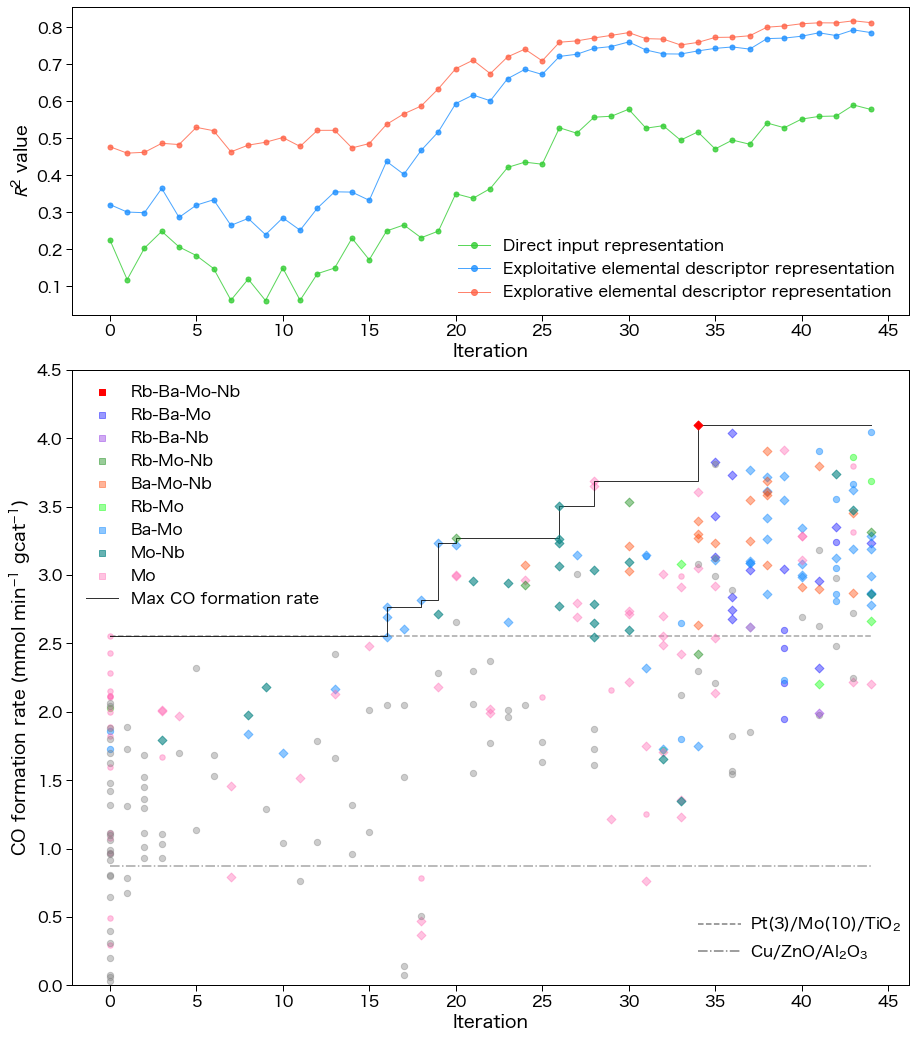

In [58]:
plot_r2_and_target(condition, converted)

pgm_num = 0 add_num = 5 supp_num = 0 CalT_num = 0


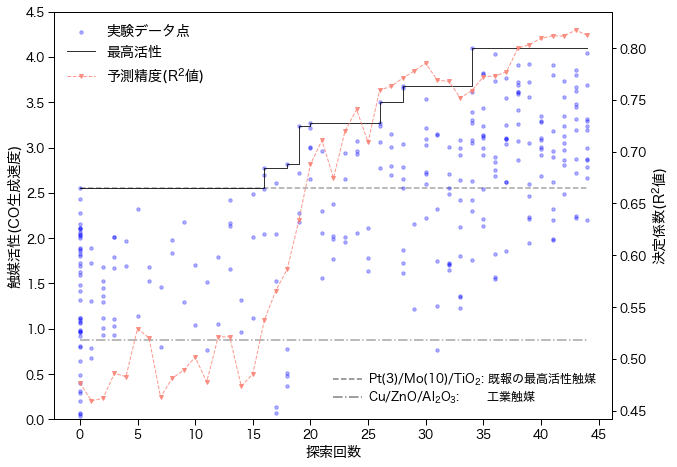

In [50]:
# Basic setups.
import japanize_matplotlib

plt.rcParams["mathtext.fontset"] = "stixsans"
date, Reaction = condition['date'], condition['Reaction']
data, desc  = converted['data'], converted['desc']
pgm_num, add_num, supp_num = condition['pgm_num'], condition['add_num'], condition['supp_num']

num_loop_max = data['Iteration'].max()
fig, ax1 = plt.subplots(facecolor='white', figsize=(10,7.5))
ax2 = ax1.twinx()

x, y = data['Iteration'], data[target_name]
ax1.scatter(x, y, zorder=2, s=12, marker='o', alpha=0.3, color='blue', label='実験データ点')

CV_prop2 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop2_loop{num_loop_max}.csv')
ax2.plot(CV_prop2['tes_r2'], marker="v", markersize=4, color='salmon', linestyle='dashed', linewidth=1, alpha=0.8, label='予測精度(R$^{2}$値)')

ax1.set_xlabel('Iteration', fontsize=14)
max_target_out, max_target = extract_max_min_target_cat(condition, converted)
ax1.step(np.arange(0, 45, 1), max_target[target_name], where='post', zorder=2, color='k', alpha=0.8, linewidth=1, label='最高活性')
ax1.set_xticks(np.arange(0, len(CV_prop2)+1, 5))
ax1.tick_params(direction='out', length=6, colors='k')
ax1.tick_params(direction="out", length=6, colors="black")

ax1.set_ylim(0, 4.5)
data, desc  = converted['data'], converted['desc']
ax1.hlines(2.554, 0, data['Iteration'].max(), color='grey', linestyle='dashed', zorder=1, alpha=0.7)
ax1.hlines(0.45, data['Iteration'].max()-22, data['Iteration'].max()-19.5, color='grey', linestyle='dashed')
ax1.text(data['Iteration'].max()-19, 0.41, "$Pt(3)/Mo(10)/TiO_{2}$: 既報の最高活性触媒", fontsize=12)

ax1.hlines(0.870, 0, data['Iteration'].max(), color='grey', linestyle='dashdot', zorder=1, alpha=0.7)
ax1.hlines(0.25, data['Iteration'].max()-22, data['Iteration'].max()-19.5, color='grey', linestyle='dashdot')
ax1.text(data['Iteration'].max()-19, 0.21, "$Cu/ZnO/Al_{2}O_{3}$:       工業触媒", fontsize=12)

ax1.set_xlabel('探索回数', fontsize=14)
ax1.set_ylabel('触媒活性(CO生成速度)', fontsize=14)
ax2.set_ylabel('決定係数(R$^{2}$値)', fontsize=14)

ax2.set_ylim(auto=True)

handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
ax1.legend(handler1 + handler2, label1 + label2, bbox_to_anchor=(0, 1), loc='upper left', borderaxespad=0.5, markerscale=1,  fontsize=14, frameon=False)
plt.savefig(f'{PATH}/{date}_{Reaction}_R2_and_Stairs_plot_loop{num_loop_max}_JSPS.png', dpi=600, bbox_inches='tight')

pgm_num = 0 add_num = 5 supp_num = 0 CalT_num = 0


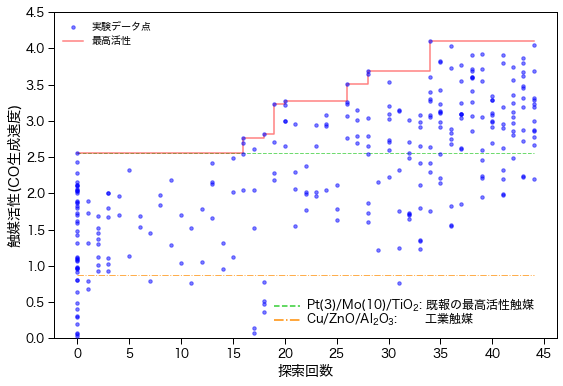

In [62]:
# Basic setups.
import japanize_matplotlib

plt.rcParams["mathtext.fontset"] = "stixsans"
date, Reaction = condition['date'], condition['Reaction']
data, desc  = converted['data'], converted['desc']
pgm_num, add_num, supp_num = condition['pgm_num'], condition['add_num'], condition['supp_num']

num_loop_max = data['Iteration'].max()
fig, ax1 = plt.subplots(facecolor='white', figsize=(9,6))


x, y = data['Iteration'], data[target_name]
ax1.scatter(x, y, zorder=3, s=12, marker='o', alpha=0.5, color='blue', label='実験データ点')

ax1.set_xlabel('Iteration', fontsize=14)
max_target_out, max_target = extract_max_min_target_cat(condition, converted)
ax1.step(np.arange(0, 45, 1), max_target[target_name], where='post', zorder=2, color='red', alpha=0.5, linewidth=1.5, label='最高活性')
ax1.set_xticks(np.arange(0, len(CV_prop2)+1, 5))
ax1.tick_params(direction='out', length=6, colors='k')
ax1.tick_params(direction="out", length=6, colors="black")

ax1.set_ylim(0, 4.5)
data, desc  = converted['data'], converted['desc']
ax1.hlines(2.554, 0, data['Iteration'].max(), color='limegreen', linestyle='dashed', zorder=1, alpha=0.7, linewidth=1)
ax1.hlines(0.45, data['Iteration'].max()-25, data['Iteration'].max()-22.5, color='limegreen', linestyle='dashed')
ax1.text(data['Iteration'].max()-22, 0.41, "$Pt(3)/Mo(10)/TiO_{2}$: 既報の最高活性触媒", fontsize=12)

ax1.hlines(0.870, 0, data['Iteration'].max(), color='darkorange', linestyle='dashdot', zorder=1, alpha=0.7, linewidth=1)
ax1.hlines(0.25, data['Iteration'].max()-25, data['Iteration'].max()-22.5, color='darkorange', linestyle='dashdot')
ax1.text(data['Iteration'].max()-22, 0.21, "$Cu/ZnO/Al_{2}O_{3}$:       工業触媒", fontsize=12)

ax1.set_xlabel('探索回数', fontsize=14)
ax1.set_ylabel('触媒活性(CO生成速度)', fontsize=14)

ax1.legend(bbox_to_anchor=(0, 1), loc='upper left', borderaxespad=0.5, markerscale=1, fontsize=10, frameon=False)
plt.savefig(f'{PATH}/{date}_{Reaction}_R2_and_Stairs_plot_loop{num_loop_max}_JSPS_v2.png', dpi=600, bbox_inches='tight')

pgm_num = 0 add_num = 5 supp_num = 0 CalT_num = 0


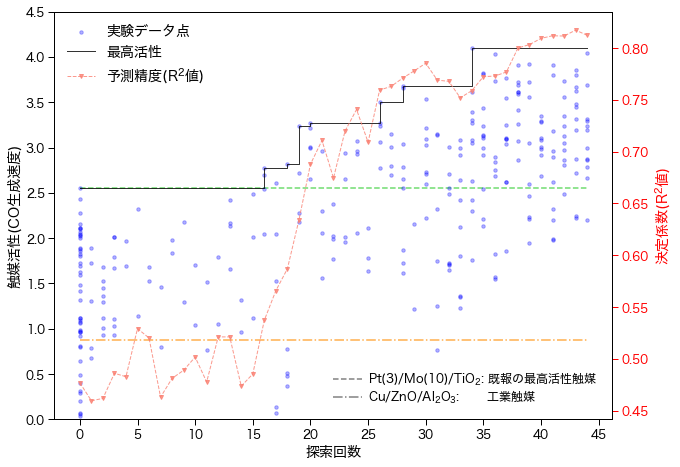

In [17]:
# Basic setups.
import japanize_matplotlib

plt.rcParams["mathtext.fontset"] = "stixsans"
date, Reaction = condition['date'], condition['Reaction']
data, desc  = converted['data'], converted['desc']
pgm_num, add_num, supp_num = condition['pgm_num'], condition['add_num'], condition['supp_num']

num_loop_max = data['Iteration'].max()
fig, ax1 = plt.subplots(facecolor='white', figsize=(10,7.5))
ax1.spines['top'].set_color('red')
ax2.spines['right'].set_color('red')
ax2 = ax1.twinx()

x, y = data['Iteration'], data[target_name]
ax1.scatter(x, y, zorder=2, s=12, marker='o', alpha=0.3, color='blue', label='実験データ点')

CV_prop2 = pd.read_csv(f'{PATH2}/{date}_{Reaction}_CV_prop2_loop{num_loop_max}.csv')
ax2.plot(CV_prop2['tes_r2'], marker="v", markersize=4, color='salmon', linestyle='dashed', linewidth=1, alpha=0.8, label='予測精度(R$^{2}$値)')

ax1.set_xlabel('Iteration', fontsize=14)
max_target_out, max_target = extract_max_min_target_cat(condition, converted)
ax1.step(np.arange(0, 45, 1), max_target[target_name], where='post', zorder=2, color='k', alpha=0.8, linewidth=1, label='最高活性')
ax1.set_xticks(np.arange(0, len(CV_prop2)+1, 5))
ax1.tick_params(direction='out', length=6, colors='k')
ax2.tick_params(direction="out", length=6, colors="red")

ax1.set_ylim(0, 4.5)
data, desc  = converted['data'], converted['desc']
ax1.hlines(2.554, 0, data['Iteration'].max(), color='limegreen', linestyle='dashed', zorder=1, alpha=0.7)
ax1.hlines(0.45, data['Iteration'].max()-22, data['Iteration'].max()-19.5, color='grey', linestyle='dashed')
ax1.text(data['Iteration'].max()-19, 0.41, "$Pt(3)/Mo(10)/TiO_{2}$: 既報の最高活性触媒", fontsize=12)

ax1.hlines(0.870, 0, data['Iteration'].max(), color='darkorange', linestyle='dashdot', zorder=1, alpha=0.7)
ax1.hlines(0.25, data['Iteration'].max()-22, data['Iteration'].max()-19.5, color='grey', linestyle='dashdot')
ax1.text(data['Iteration'].max()-19, 0.21, "$Cu/ZnO/Al_{2}O_{3}$:       工業触媒", fontsize=12)

ax1.set_xlabel('探索回数', fontsize=14)
ax1.set_ylabel('触媒活性(CO生成速度)', fontsize=14)
ax2.set_ylabel('決定係数(R$^{2}$値)', color='red', fontsize=14)

ax2.set_ylim(auto=True)


handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
ax1.legend(handler1 + handler2, label1 + label2, bbox_to_anchor=(0, 1), loc='upper left', borderaxespad=0.5, markerscale=1,  fontsize=14, frameon=False)
plt.savefig(f'{PATH}/{date}_{Reaction}_R2_and_Stairs_plot_loop{num_loop_max}_AIST.png', dpi=600, bbox_inches='tight')

### Basic EDA

In [48]:
condition = conditions.calc_condition()
Reaction, data_sheet_name = condition['Reaction'], condition['data_sheet_name']
pgm_model, add_model, supp_model = condition['pgm_model'], condition['add_model'], condition['supp_model']
target_name = condition['target_name']
pgm_num, add_num = condition['pgm_num'], condition['add_num']
converted = analysis.analysis_data_convert(condition, data_sheet_name, use_models=[pgm_model, add_model, supp_model], idx=None)
data, desc = converted['data'], converted['desc']
feat, target = converted['feat'], converted['target']
add_desc = converted['add_desc']
add_aw = converted['add_aw']
feat_cols = feat.columns

20220318 rwgs_250 all data


In [49]:
data_wt = converted['data']
data_wt = data_wt.drop(['CO Yield_%', 'Catal prep', 'Reaction', 'Note'], axis=1)
data_wt['Sum_wt%'] = data_wt.loc[:, ['Ad1_wt%', 'Ad2_wt%', 'Ad3_wt%', 'Ad4_wt%', 'Ad5_wt%']].sum(axis=1)

data_wt

No. Ad1  Ad1_wt% Ad2  Ad2_wt% Ad3  Ad3_wt% Ad4  Ad4_wt% Ad5  Ad5_wt%  \
0      1  Mo     10.0   H      0.0   H      0.0   H      0.0   H      0.0   
1      2   V     10.0   H      0.0   H      0.0   H      0.0   H      0.0   
2      3  Ce     10.0   H      0.0   H      0.0   H      0.0   H      0.0   
3      4  La     10.0   H      0.0   H      0.0   H      0.0   H      0.0   
4      5   Y     10.0   H      0.0   H      0.0   H      0.0   H      0.0   
..   ...  ..      ...  ..      ...  ..      ...  ..      ...  ..      ...   
295  296  Mo      0.6  Ba      2.0  Re      1.2   W      0.2   H      0.0   
296  297  Rb      1.0  Mo      0.5  Ba      1.0  Nb      0.2  Hf      0.2   
297  298  Mo      0.7  Ba      0.5   K      0.7   W      0.2   H      0.0   
298  299  Ce      0.2  Nb      0.2  Rb      1.2  Na      0.2  Mo      0.7   
299  300  Nb      0.2  Rb      1.0  Mo      0.5  Ba      1.2  Yb      0.2   

     CO formation rate_mmol min-1 gcat-1  Iteration  Sum_wt%  
0                               2.554000          0     10.0  
1                               2.063107          0     10.0  
2                               2.039933          0     10.0  
3                               1.481395          0     10.0  
4                               1.421278          0     10.0  
..                                   ...        ...      ...  
295                             3.287278         44      4.0  
296                             3.191742         44      2.9  
297                             2.870139         44      2.1  
298                             3.312710         44      2.5  
299                             2.780248         44      3.1  

[300 rows x 14 columns]

In [50]:
data_mol = converted['data']
for i in range(add_num):
    for j in range(len(data)):
        data_mol[f'Ad{i+1}_wt%'][j] =  (100*data_mol[f'Ad{i+1}_wt%'][j])/add_aw[data_mol[f'Ad{i+1}'][j]] # μmol (Cat. ammount: 10 mg)

data_mol = data_mol.rename(columns={'Ad1_wt%': 'Ad1_μmol', 'Ad2_wt%': 'Ad2_μmol', 'Ad3_wt%': 'Ad3_μmol', 'Ad4_wt%': 'Ad4_μmol', 'Ad5_wt%': 'Ad5_μmol'})
data_mol = data_mol.drop(['CO Yield_%', 'Catal prep', 'Reaction','Note'], axis=1)
data_mol['Highest_elem'] = data_mol.loc[:, ['Ad1_μmol', 'Ad2_μmol', 'Ad3_μmol', 'Ad4_μmol', 'Ad5_μmol']].idxmax(axis=1).str.strip('_μmol')
data_mol['Highest_μmol'] = data_mol.loc[:, ['Ad1_μmol', 'Ad2_μmol', 'Ad3_μmol', 'Ad4_μmol', 'Ad5_μmol']].max(axis=1)
for i in range(len(data_mol)):
    data_mol['Highest_elem'][i] = data_mol[data_mol['Highest_elem'][i]][i]
data_mol

No. Ad1   Ad1_μmol Ad2  Ad2_μmol Ad3  Ad3_μmol Ad4  Ad4_μmol Ad5  \
0      1  Mo  10.421009   H  0.000000   H  0.000000   H  0.000000   H   
1      2   V  19.630360   H  0.000000   H  0.000000   H  0.000000   H   
2      3  Ce   7.136944   H  0.000000   H  0.000000   H  0.000000   H   
3      4  La   7.199139   H  0.000000   H  0.000000   H  0.000000   H   
4      5   Y  11.247847   H  0.000000   H  0.000000   H  0.000000   H   
..   ...  ..        ...  ..       ...  ..       ...  ..       ...  ..   
295  296  Mo   0.625261  Ba  1.456378  Re  0.644444   W  0.108790   H   
296  297  Rb   1.170031  Mo  0.521050  Ba  0.728189  Nb  0.215270  Hf   
297  298  Mo   0.729471  Ba  0.364094   K  1.790359   W  0.108790   H   
298  299  Ce   0.142739  Nb  0.215270  Rb  1.404038  Na  0.869951  Mo   
299  300  Nb   0.215270  Rb  1.170031  Mo  0.521050  Ba  0.873827  Yb   

     Ad5_μmol  CO formation rate_mmol min-1 gcat-1  Iteration Highest_elem  \
0    0.000000                             2.554000          0           Mo   
1    0.000000                             2.063107          0            V   
2    0.000000                             2.039933          0           Ce   
3    0.000000                             1.481395          0           La   
4    0.000000                             1.421278          0            Y   
..        ...                                  ...        ...          ...   
295  0.000000                             3.287278         44           Ba   
296  0.112051                             3.191742         44           Rb   
297  0.000000                             2.870139         44            K   
298  0.729471                             3.312710         44           Rb   
299  0.115571                             2.780248         44           Rb   

     Highest_μmol  
0       10.421009  
1       19.630360  
2        7.136944  
3        7.199139  
4       11.247847  
..            ...  
295      1.456378  
296      1.170031  
297      1.790359  
298      1.404038  
299      1.170031  

[300 rows x 15 columns]

In [51]:
data_count = pd.DataFrame(index=np.arange(len(data_mol)), columns=add_desc.index)
for i in range(len(data_mol)):
    for j in range(add_num):
        data_count.loc[i, data_mol.loc[i, f'Ad{j+1}']] = 1 #data_mol.loc[i, f'Ad{j+1}_μmol']
data_count = data_count.fillna(0)
data_count = data_count.drop('H', axis=1)
data_count = pd.concat([data_count, data_mol[target_name]], axis=1)
data_count['Activity_level'] = 0

for i in range(len(data_count)):
    if data_count[target_name][i] > 0 and data_count[target_name][i] <= 0.5:
        data_count['Activity_level'][i] = 0
    elif data_count[target_name][i] > 0.5 and data_count[target_name][i] <= 1.0:
        data_count['Activity_level'][i] = 1
    elif data_count[target_name][i] > 1.0 and data_count[target_name][i] <= 1.5:
        data_count['Activity_level'][i] = 2
    elif data_count[target_name][i] > 1.5 and data_count[target_name][i] <= 2.0:
        data_count['Activity_level'][i] = 3
    elif data_count[target_name][i] > 2.0 and data_count[target_name][i] <= 2.5:
        data_count['Activity_level'][i] = 4
    elif data_count[target_name][i] > 2.5 and data_count[target_name][i] <= 3.0:
        data_count['Activity_level'][i] = 5
    elif data_count[target_name][i] > 3.0 and data_count[target_name][i] <= 3.5:
        data_count['Activity_level'][i] = 6
    elif data_count[target_name][i] > 3.5:
        data_count['Activity_level'][i] = 7
data_count



Li  Na  Mg  Al  Si  K  Ca  Sc  Ti  V  ...  Yb  Lu  Hf  Ta  W  Re  Pb  Bi  \
0     0   0   0   0   0  0   0   0   0  0  ...   0   0   0   0  0   0   0   0   
1     0   0   0   0   0  0   0   0   0  1  ...   0   0   0   0  0   0   0   0   
2     0   0   0   0   0  0   0   0   0  0  ...   0   0   0   0  0   0   0   0   
3     0   0   0   0   0  0   0   0   0  0  ...   0   0   0   0  0   0   0   0   
4     0   0   0   0   0  0   0   0   0  0  ...   0   0   0   0  0   0   0   0   
..   ..  ..  ..  ..  .. ..  ..  ..  .. ..  ...  ..  ..  ..  .. ..  ..  ..  ..   
295   0   0   0   0   0  0   0   0   0  0  ...   0   0   0   0  1   1   0   0   
296   0   0   0   0   0  0   0   0   0  0  ...   0   0   1   0  0   0   0   0   
297   0   0   0   0   0  1   0   0   0  0  ...   0   0   0   0  1   0   0   0   
298   0   1   0   0   0  0   0   0   0  0  ...   0   0   0   0  0   0   0   0   
299   0   0   0   0   0  0   0   0   0  0  ...   1   0   0   0  0   0   0   0   

     CO formation rate_mmol min-1 gcat-1  Activity_level  
0                               2.554000               5  
1                               2.063107               4  
2                               2.039933               4  
3                               1.481395               2  
4                               1.421278               2  
..                                   ...             ...  
295                             3.287278               6  
296                             3.191742               6  
297                             2.870139               5  
298                             3.312710               6  
299                             2.780248               5  

[300 rows x 55 columns]

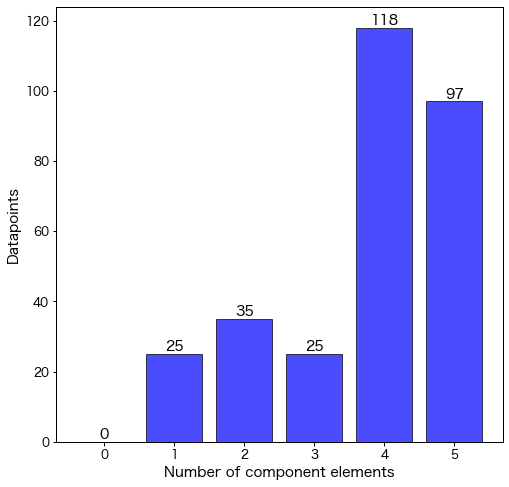

In [53]:
data_count['num_of_component'] = data_count.loc[:, add_desc.index[1:]].sum(axis=1)
comp_num = pd.DataFrame(index=np.arange(0, add_num+1, 1), columns=['datapoints']).fillna(0)

for i in range(len(data_count)):
    comp_num.iloc[data_count['num_of_component'][i]] += 1

fig, ax = plt.subplots(facecolor = 'white', figsize = (8, 8))
#plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.xlabel('Number of component elements', fontsize=14)
plt.ylabel('Datapoints', fontsize=14)
#plt.xticks(rotation=90)
plt.tick_params(labelsize=12)
plt.bar(comp_num.index, comp_num.loc[:, 'datapoints'], color='blue', alpha=0.7, edgecolor='black', align='center')

for x, y in zip(comp_num.index, comp_num.loc[:, 'datapoints']):
    plt.text(x, y, y, ha='center', va='bottom', fontsize=14)

plt.savefig(f'{PATH}/num_of_comp_bar.png', dpi=600 ,bbox_inches='tight')

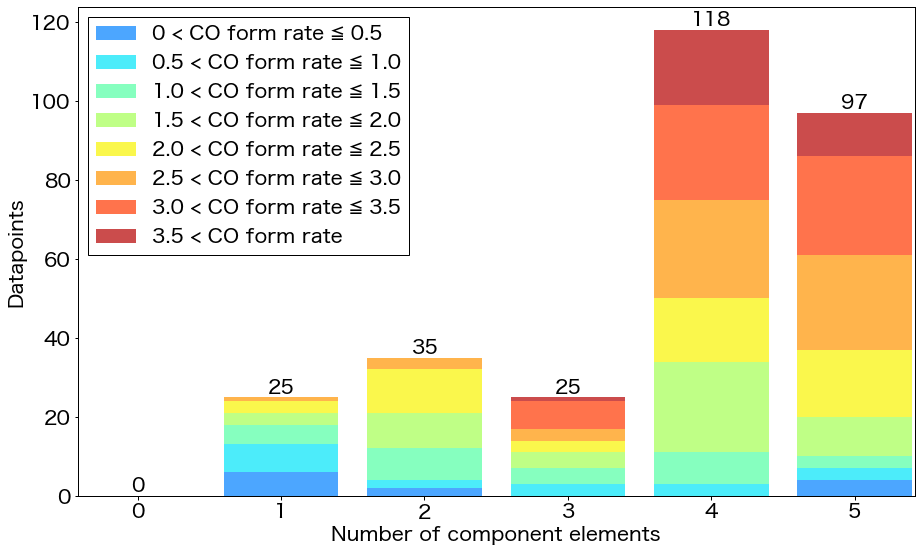

In [98]:
comp_num_v2 = pd.DataFrame(index=np.arange(0, add_num+1, 1),
                           columns=[
                               '0 < CO form rate ≦ 0.5',
                               '0.5 < CO form rate ≦ 1.0',
                               '1.0 < CO form rate ≦ 1.5',
                               '1.5 < CO form rate ≦ 2.0',
                               '2.0 < CO form rate ≦ 2.5',
                               '2.5 < CO form rate ≦ 3.0',
                               '3.0 < CO form rate ≦ 3.5',
                               '3.5 < CO form rate',
                               ]).fillna(0)
for i in range(len(data_count)):
    comp_num_v2.iloc[data_count['num_of_component'][i], data_count['Activity_level'][i]] += 1

fig, ax = plt.subplots(facecolor='white', figsize=(15, 9))
plt.xlabel('Number of component elements', fontsize=20)
plt.ylabel('Datapoints', fontsize=20)
plt.tick_params(labelsize=20)

#cmap_name = 'nipy_spectral'
#cmap_name = 'turbo'
cmap_name = 'jet'
cm = plt.get_cmap(cmap_name)
plt.ylabel('Datapoints', fontsize=20)
for i in range(len(comp_num_v2.columns)):
    z = i/10+0.25
    ax.bar(comp_num_v2.index, comp_num_v2.iloc[:,i], bottom=comp_num_v2.iloc[:, :i].sum(axis=1), align='center', color=cm(z), alpha=0.7)

comp_num_v2['Total datapoints'] = comp_num_v2.sum(axis=1)
for x, y in zip(comp_num_v2.index, comp_num_v2.loc[:, 'Total datapoints']):
    plt.text(x, y, y, ha='center', va='bottom', fontsize=20)

ax.legend(comp_num_v2.columns, fontsize=20)
plt.ylabel('Datapoints', fontsize=20)
plt.savefig(f'{PATH}/num_of_comp_bar_{cmap_name}.png', dpi=600 ,bbox_inches='tight')

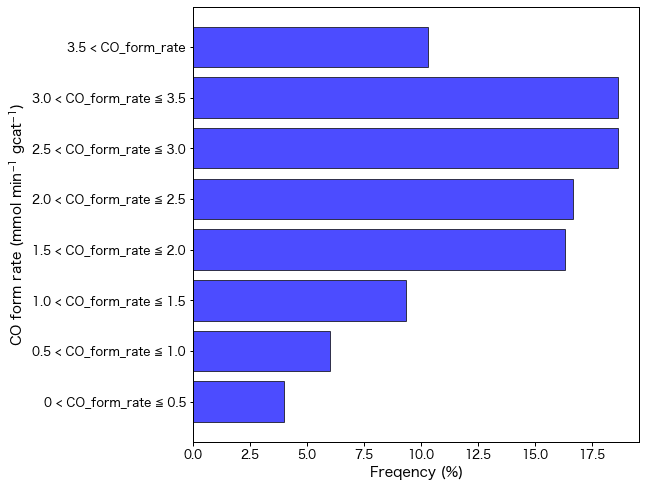

In [60]:
activity_freq = pd.DataFrame(index=[
                               '0 < CO_form_rate ≦ 0.5',
                               '0.5 < CO_form_rate ≦ 1.0',
                               '1.0 < CO_form_rate ≦ 1.5',
                               '1.5 < CO_form_rate ≦ 2.0',
                               '2.0 < CO_form_rate ≦ 2.5',
                               '2.5 < CO_form_rate ≦ 3.0',
                               '3.0 < CO_form_rate ≦ 3.5',
                               '3.5 < CO_form_rate',
                               ], columns=['Freqency']).fillna(0)
for i in range(len(activity_freq.index)):
    activity_freq.iloc[i] = comp_num_v2.sum(axis=0)[i] / comp_num_v2.sum(axis=0)[-1] * 100

fig, ax = plt.subplots(facecolor = 'white', figsize = (8, 8))
#plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.xlabel('Freqency (%)', fontsize=14)
plt.ylabel('CO form rate (mmol $min^{{-}1}$ $gcat^{{-}1}$)', fontsize=14)
#plt.xticks(rotation=90)
plt.tick_params(labelsize=12)
plt.barh(activity_freq.index, activity_freq.loc[:, 'Freqency'], color='blue', alpha=0.7, edgecolor='black', align='center')

plt.savefig(f'{PATH}/activity_freq_barh.png', dpi=600 ,bbox_inches='tight')

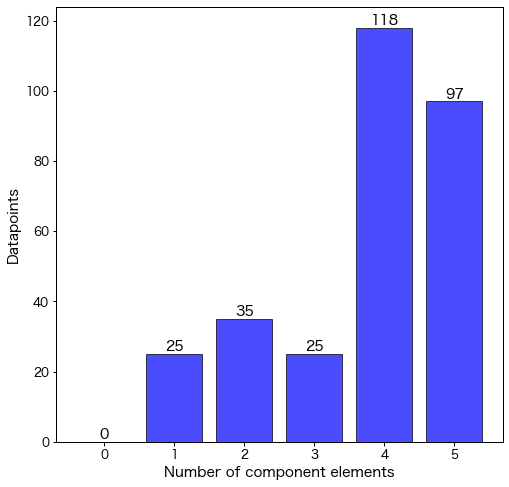

In [62]:
data_count['num_of_component'] = data_count.loc[:, add_desc.index[1:]].sum(axis=1)
comp_num = pd.DataFrame(index=np.arange(0, add_num+1, 1), columns=['datapoints']).fillna(0)

for i in range(len(data_count)):
    
    comp_num.iloc[data_count['num_of_component'][i]] += 1

fig, ax = plt.subplots(facecolor = 'white', figsize = (8, 8))
#plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.xlabel('Number of component elements', fontsize=14)
plt.ylabel('Datapoints', fontsize=14)
#plt.xticks(rotation=90)
plt.tick_params(labelsize=12)
plt.bar(comp_num.index, comp_num.loc[:, 'datapoints'], color='blue', alpha=0.7, edgecolor='black', align='center')

for x, y in zip(comp_num.index, comp_num.loc[:, 'datapoints']):
    plt.text(x, y, y, ha='center', va='bottom', fontsize=14)

plt.savefig(f'{PATH}/num_of_comp_bar.png', dpi=600 ,bbox_inches='tight')

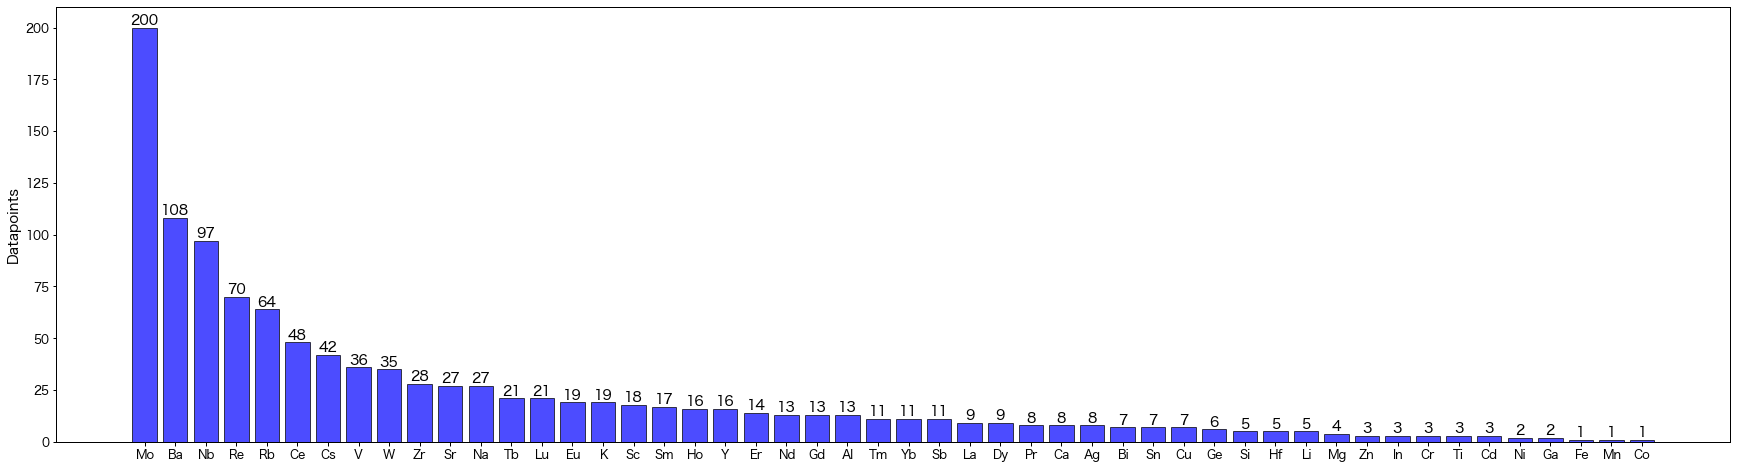

In [80]:
elem_num = pd.DataFrame(index=add_desc.index, columns=['Num_elem']).fillna(0)

for i in range(len(data)):
    for j in range(pgm_num):
        if data_mol.loc[i, f'PGM{j+1}_μmol'] > 0:
            elem_num.loc[data_mol.loc[i, f'PGM{j+1}']] += 1
        elif data_mol.loc[i, f'PGM{j+1}_μmol'] == 0:
            elem_num.loc[data_mol.loc[i, f'PGM{j+1}']] += 0
    for j in range(add_num):
        if data_mol.loc[i, f'Ad{j+1}_μmol'] > 0:
            elem_num.loc[data_mol.loc[i, f'Ad{j+1}']] += 1
        elif data_mol.loc[i, f'Ad{j+1}_μmol'] == 0:
            elem_num.loc[data_mol.loc[i, f'Ad{j+1}']] += 0

elem_num = elem_num[elem_num['Num_elem'] != 0].sort_values('Num_elem', ascending=False)

#plt.xlabel('Elements')
fig, ax = plt.subplots(facecolor = 'white', figsize = (30, 8))
#plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.ylabel('Datapoints', fontsize=14)
#plt.xticks(rotation=90)
plt.tick_params(labelsize=12)
plt.bar(elem_num.index, elem_num.loc[:, 'Num_elem'], color='blue', alpha=0.7, edgecolor='black', align='center')

for x, y in zip(elem_num.index, elem_num.loc[:, 'Num_elem']):
    plt.text(x, y, y, ha='center', va='bottom', fontsize=14)

plt.savefig(f'{PATH}/elements_bar_v2.png', dpi=600 ,bbox_inches='tight')

In [81]:
#elem_num = pd.DataFrame(index=add_desc.index, columns=['Num_elem']).fillna(0)

elem_index = elem_num.index
elem_index_num = elem_num.loc[:, 'Num_elem']

elem_num = pd.DataFrame(index=add_desc.index, columns=['Num_elem',0, 1, 2, 3, 4, 5, 6, 7]).fillna(0)

for i in range(len(data)):
    for j in range(pgm_num):
        if data_mol.loc[i, f'PGM{j+1}_μmol'] > 0:
            elem_num.loc[:, 'Num_elem'][data_mol.loc[i, f'PGM{j+1}']] += 1
            elem_num.loc[:, data_count.loc[:, 'Activity_level'][i]][data_mol.loc[i, f'PGM{j+1}']] += 1
        elif data_mol.loc[i, f'PGM{j+1}_μmol'] == 0:
            elem_num.loc[:, 'Num_elem'][data_mol.loc[i, f'PGM{j+1}']] += 0
            elem_num.loc[:, data_count.loc[:, 'Activity_level'][i]][data_mol.loc[i, f'PGM{j+1}']] += 0
    for j in range(add_num):
        if data_mol.loc[i, f'Ad{j+1}_μmol'] > 0:
            elem_num.loc[:, 'Num_elem'][data_mol.loc[i, f'Ad{j+1}']] += 1
            elem_num.loc[:, data_count.loc[:, 'Activity_level'][i]][data_mol.loc[i, f'Ad{j+1}']] += 1
        elif data_mol.loc[i, f'Ad{j+1}_μmol'] == 0:
            elem_num.loc[:, 'Num_elem'][data_mol.loc[i, f'Ad{j+1}']] += 0
            elem_num.loc[:, data_count.loc[:, 'Activity_level'][i]][data_mol.loc[i, f'Ad{j+1}']] += 0

elem_num = elem_num[elem_num['Num_elem'] != 0].sort_values('Num_elem', ascending=False)
elem_sum = elem_num.loc[:, 'Num_elem']
elem_num = elem_num.drop(['Num_elem'], axis=1)
elem_num = elem_num.rename(columns={
    0: '0 < CO_form_rate ≦ 0.5',
    1: '0.5 < CO_form_rate ≦ 1.0',
    2: '1.0 < CO_form_rate ≦ 1.5',
    3: '1.5 < CO_form_rate ≦ 2.0',
    4: '2.0 < CO_form_rate ≦ 2.5',
    5: '2.5 < CO_form_rate ≦ 3.0',
    6: '3.0 < CO_form_rate ≦ 3.5',
    7: '3.5 < CO_form_rate'
    }).T
elem_num


Symbol                    Mo  Ba  Nb  Re  Rb  Ce  Cs   V  W  Zr  ...  Zn  In  \
0 < CO_form_rate ≦ 0.5     4   1   0   2   0   1   1   0  0   0  ...   2   1   
0.5 < CO_form_rate ≦ 1.0   4   0   3   1   3   1   2   0  4   0  ...   0   0   
1.0 < CO_form_rate ≦ 1.5   8   1   7   5   0   1   3   1  2   3  ...   0   1   
1.5 < CO_form_rate ≦ 2.0  21  18  17  12   9   2   5  10  9   5  ...   1   1   
2.0 < CO_form_rate ≦ 2.5  32   7   6  15   9  10   8   9  8   8  ...   0   0   
2.5 < CO_form_rate ≦ 3.0  49  24  24  13  15   8  11   9  4   8  ...   0   0   
3.0 < CO_form_rate ≦ 3.5  52  37  26  15  17  12  10   4  5   4  ...   0   0   
3.5 < CO_form_rate        30  20  14   7  11  13   2   3  3   0  ...   0   0   

Symbol                    Cr  Ti  Cd  Ni  Ga  Fe  Mn  Co  
0 < CO_form_rate ≦ 0.5     1   0   0   0   1   0   0   0  
0.5 < CO_form_rate ≦ 1.0   0   0   0   0   1   1   0   0  
1.0 < CO_form_rate ≦ 1.5   0   0   0   2   0   0   1   0  
1.5 < CO_form_rate ≦ 2.0   2   1   2   0   0   0   0   1  
2.0 < CO_form_rate ≦ 2.5   0   0   0   0   0   0   0   0  
2.5 < CO_form_rate ≦ 3.0   0   1   1   0   0   0   0   0  
3.0 < CO_form_rate ≦ 3.5   0   0   0   0   0   0   0   0  
3.5 < CO_form_rate         0   1   0   0   0   0   0   0  

[8 rows x 50 columns]

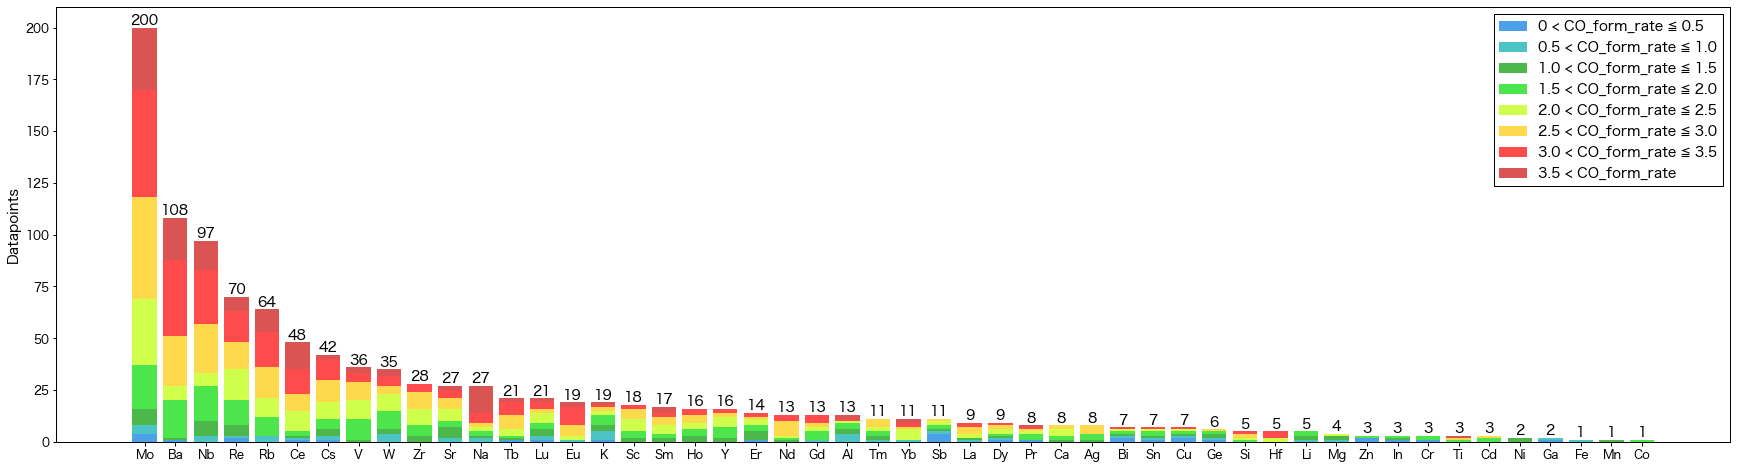

In [83]:
fig, ax = plt.subplots(facecolor = 'white', figsize = (30, 8))

cmap_name = 'nipy_spectral'
cm = plt.get_cmap(cmap_name)

plt.ylabel('Datapoints', fontsize=14)
for i in range(len(elem_num)):
    z = i/10+0.25
    ax.bar(elem_num.columns, elem_num.iloc[i], bottom=elem_num.iloc[:i].sum(), align='center', color=cm(z), alpha=0.7)
    """
    for j in range(len(elem_num.columns)):
        plt.text(x=j,
                 y=elem_num.iloc[:i, j].sum() + (elem_num.iloc[i, j] / 2),
                 s=elem_num.iloc[i, j],
                 ha='center',
                 va='bottom',
                 fontsize=5
                )
    """
for x, y in zip(elem_index, elem_index_num):
    plt.text(x, y, y, ha='center', va='bottom', fontsize=14)

ax.legend(elem_num.index, fontsize=14)
plt.savefig(f'{PATH}/elements_bar_{cmap_name}.png', dpi=600 ,bbox_inches='tight')

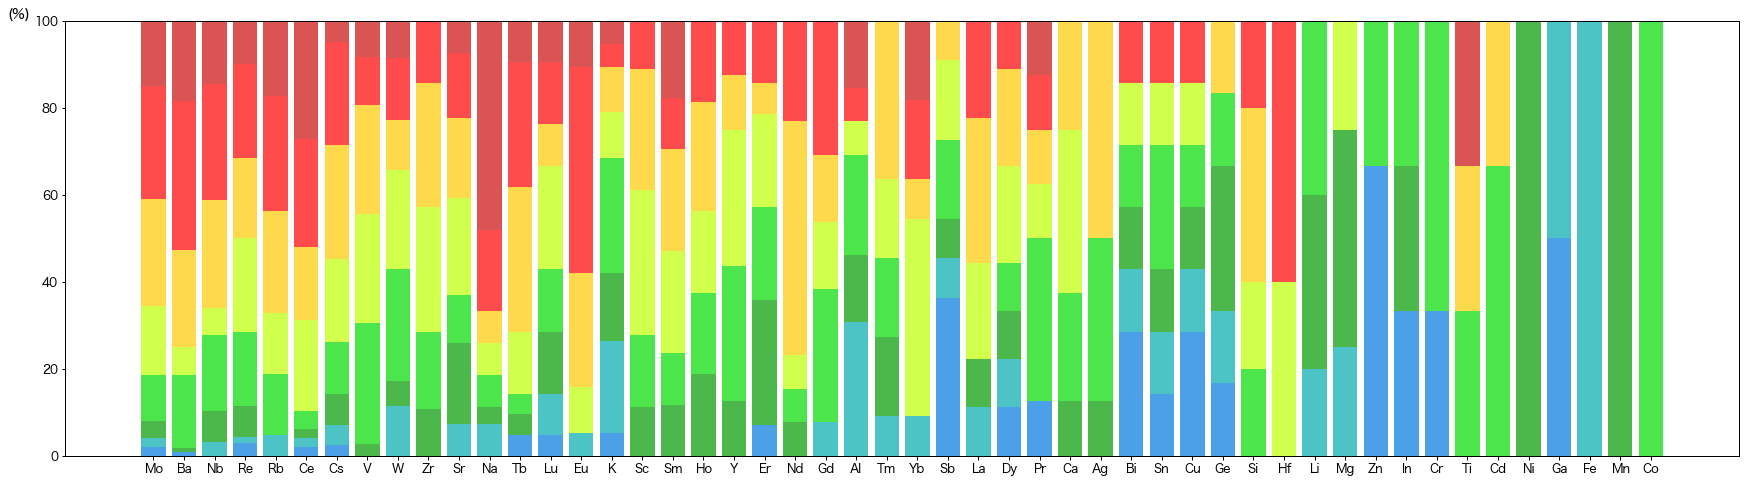

In [84]:
elem_num_band = elem_num.copy()

for i in range(len(elem_num_band.columns)):
    elem_num_band.loc[:, elem_num_band.columns[i]] = elem_num_band.loc[:, elem_num_band.columns[i]]*100/elem_num_band.loc[:, elem_num_band.columns[i]].sum()

fig, ax = plt.subplots(facecolor = 'white', figsize = (30, 8))

cmap_name = 'nipy_spectral'
cm = plt.get_cmap(cmap_name)

plt.ylabel('(%)', rotation=0, fontsize=14, loc='top')
for i in range(len(elem_num)):
    z = i/10+0.25
    ax.bar(elem_num_band.columns, elem_num_band.iloc[i], bottom=elem_num_band.iloc[:i].sum(), align='center', color=cm(z), alpha=0.7)
    """
    for j in range(len(elem_num.columns)):
        plt.text(x=j,
                 y=elem_num.iloc[:i, j].sum() + (elem_num.iloc[i, j] / 2),
                 s=elem_num.iloc[i, j],
                 ha='center',
                 va='bottom',
                 fontsize=5
                )
    """
    
#ax.legend(elem_num.index, fontsize=14)
plt.savefig(f'{PATH}/elements_band_{cmap_name}.png', dpi=600 ,bbox_inches='tight')

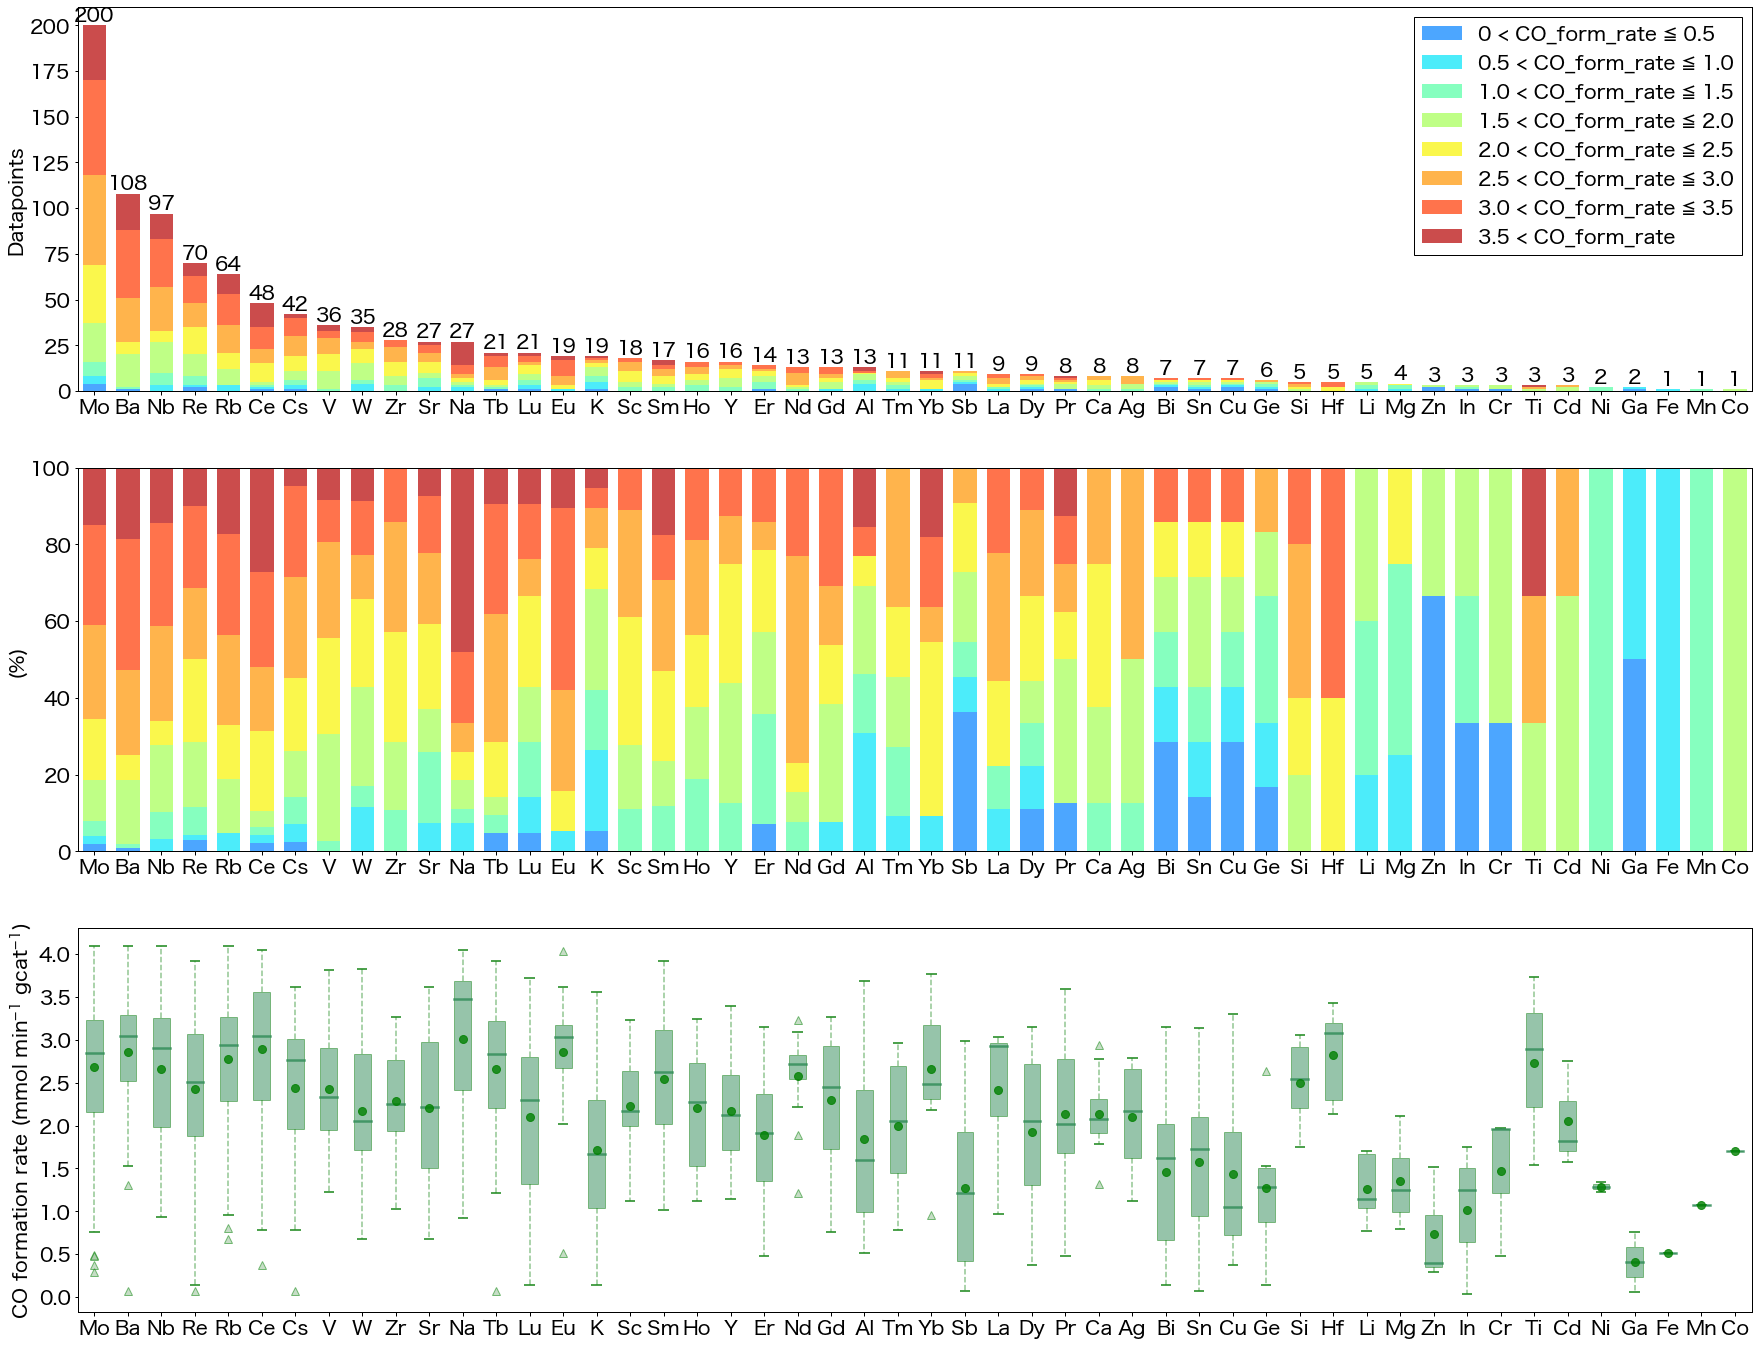

In [102]:
fig, ax = plt.subplots(3, 1, facecolor='white', figsize = (30, 24))

#cmap_name = 'nipy_spectral'
#cmap_name = 'turbo'
cmap_name = 'jet'
cm = plt.get_cmap(cmap_name)

white_width = 0.003

elem_num_band = elem_num.copy()
for i in range(len(elem_num_band.columns)):
    elem_num_band.loc[:, elem_num_band.columns[i]] = elem_num_band.loc[:, elem_num_band.columns[i]]*100/elem_num_band.loc[:, elem_num_band.columns[i]].sum()

ax[0].set_ylabel('Datapoints', fontsize=20)
for i in range(len(elem_num)):
    z = i/10+0.25
    ax[0].bar(elem_num.columns, elem_num.iloc[i], bottom=elem_num.iloc[:i].sum(), width=0.7, align='center', color=cm(z), alpha=0.7)
    mpl.rcParams['axes.xmargin'] = white_width

for x, y in zip(elem_index, elem_index_num):
    ax[0].text(x, y, y, ha='center', va='bottom', fontsize=20)
ax[0].legend(elem_num.index, fontsize=20)

ax[1].set_ylabel('(%)', fontsize=20)
for i in range(len(elem_num)):
    z = i/10+0.25
    ax[1].bar(elem_num_band.columns, elem_num_band.iloc[i], bottom=elem_num_band.iloc[:i].sum(), width=0.7, align='center', color=cm(z), alpha=0.7)
    mpl.rcParams['axes.xmargin'] = white_width

ax[2].set_ylabel('CO formation rate (mmol $min^{{-}1}$ $gcat^{{-}1}$)', fontsize=20)
data_wt_plot_all = pd.DataFrame()
for elem in range(len(elem_num.columns)):
    extract_add = elem_num.columns[elem]
    data_wt_ext = pd.DataFrame(columns=data_wt.columns)
    for i in range(add_num):
        data_wt_ext = pd.concat([data_wt_ext, data_wt[data_wt[f'Ad{i+1}']==extract_add]], axis=0)

    data_wt_ext = data_wt_ext.reset_index()

    data_wt_ext_plot = pd.DataFrame(index=data_wt_ext.index, columns=[f'{extract_add}_wt%', target_name]).fillna(0)
    for i in range(len(data_wt_ext)):
        for j in range(add_num):
            if data_wt_ext.iloc[i, :][f'Ad{j+1}'] == extract_add:
                data_wt_ext_plot[f'{extract_add}_wt%'][i] = data_wt_ext.iloc[i, :][f'Ad{j+1}_wt%']
        data_wt_ext_plot[target_name][i] = data_wt_ext[target_name][i]
    data_wt_plot_all = pd.concat([data_wt_plot_all, data_wt_ext_plot], axis=1)

bbox_props = dict(facecolor='seagreen', color='forestgreen', alpha=0.5, linestyle='dashed', linewidth=1)
median_props = dict(color='seagreen', alpha=0.8, linestyle='solid', linewidth=2.5)
cap_props = dict(color='forestgreen', alpha=0.8, linestyle='solid', linewidth=2)
line_props = dict(color='forestgreen', alpha=0.5, linestyle='dashed', linewidth=1.5)
mean_props = dict(markerfacecolor='green', markeredgecolor='green', marker='o', alpha=0.8, markersize=8)
flier_props = dict(markerfacecolor='darkseagreen', markeredgecolor='green', marker='^', alpha=0.5, markersize=8)

ax[2].boxplot([data_wt_plot_all.iloc[:, (2*i)+1].dropna() for i in range(len(elem_num.columns))], labels=elem_num.columns,
            notch=False, showmeans=True, patch_artist=True,
            flierprops=flier_props, medianprops=median_props, boxprops=bbox_props, meanprops=mean_props, capprops=cap_props, whiskerprops=line_props)

plt.setp(ax[0].get_xticklabels(), fontsize=20)
plt.setp(ax[0].get_yticklabels(), fontsize=20)
plt.setp(ax[1].get_xticklabels(), fontsize=20)
plt.setp(ax[1].get_yticklabels(), fontsize=20)
plt.setp(ax[2].get_xticklabels(), fontsize=20)
plt.setp(ax[2].get_yticklabels(), fontsize=20)

# mpl.rcParams['axes.autolimit_mode'] = 'round_numbers'
# mpl.rcParams['axes.xmargin'] = 0.02
# mpl.rcParams['axes.ymargin'] = 1

plt.savefig(f'{PATH}/elements_bar_band_box_{cmap_name}.png', dpi=600 ,bbox_inches='tight')


In [24]:
color_dict = {
    'Mo':'#54B5B5',
    'Nb':'#73C2C9',
    'Rb':'#702EB0',
    'Ba':'#00C900',
    'Re':'#267DAB',
    'Ce':'#FFFFC7',
    'Cs':'#57178F',
    'V':'#A6A6AB',
}

In [13]:
color_dict['Rb']

'702EB0'

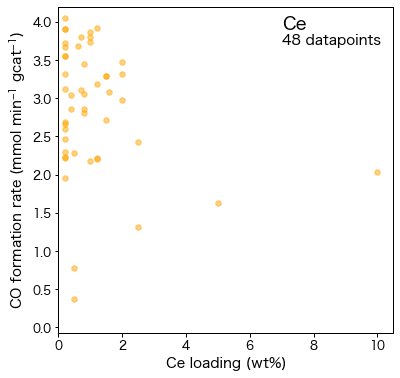

In [35]:
extract_add = 'Ce'
data_wt_ext = pd.DataFrame(columns=data_wt.columns)
for i in range(add_num):
    data_wt_ext = pd.concat([data_wt_ext, data_wt[data_wt[f'Ad{i+1}']==extract_add]], axis=0)

data_wt_ext = data_wt_ext.reset_index()

data_wt_ext_plot = pd.DataFrame(index=data_wt_ext.index, columns=[f'{extract_add}_wt%', target_name]).fillna(0)
for i in range(len(data_wt_ext)):
    for j in range(add_num):
        if data_wt_ext.iloc[i, :][f'Ad{j+1}'] == extract_add:
            data_wt_ext_plot[f'{extract_add}_wt%'][i] = data_wt_ext.iloc[i, :][f'Ad{j+1}_wt%']
    data_wt_ext_plot[target_name][i] = data_wt_ext[target_name][i]
data_wt_ext_plot

### Plot ###
fig, ax = plt.subplots(facecolor = 'white', figsize = (6, 6))
plt.xlabel(f'{extract_add} loading (wt%)', fontsize=14)
plt.ylabel('CO formation rate (mmol $min^{{-}1}$ $gcat^{{-}1}$)', fontsize=14)

plt.tick_params(labelsize=12)
cm = plt.get_cmap('Blues')
cm = plt.get_cmap('cool')

from sklearn import preprocessing
z = preprocessing.minmax_scale(data_wt_ext_plot[target_name])
ax.set_xlim(0, 10.5)
ax.set_ylim(data_wt[target_name].min()-0.1, data_wt[target_name].max()+0.1)
ax.text(10-3, data_wt[target_name].max()-0.2, extract_add, fontsize=18)
ax.text(10-3, data_wt[target_name].max()-0.4, f'{len(data_wt_ext_plot)} datapoints', fontsize=14)
ax.scatter(data_wt_ext_plot[f'{extract_add}_wt%'], data_wt_ext_plot[target_name], zorder=2, s=30, marker='o', alpha=0.5, color='orange')
plt.savefig(f'{PATH}/wt-activity_plot_{extract_add}.png', dpi=600 ,bbox_inches='tight')

In [ ]:
for elem in range(len(elem_num.columns)):
    extract_add = elem_num.columns[elem]
    data_wt_ext = pd.DataFrame(columns=data_wt.columns)
    for i in range(add_num):
        data_wt_ext = pd.concat([data_wt_ext, data_wt[data_wt[f'Ad{i+1}']==extract_add]], axis=0)

    data_wt_ext = data_wt_ext.reset_index()

    data_wt_ext_plot = pd.DataFrame(index=data_wt_ext.index, columns=[f'{extract_add}_wt%', target_name]).fillna(0)
    for i in range(len(data_wt_ext)):
        for j in range(add_num):
            if data_wt_ext.iloc[i, :][f'Ad{j+1}'] == extract_add:
                data_wt_ext_plot[f'{extract_add}_wt%'][i] = data_wt_ext.iloc[i, :][f'Ad{j+1}_wt%']
        data_wt_ext_plot[target_name][i] = data_wt_ext[target_name][i]
    data_wt_ext_plot

    ### Plot ###
    fig, ax = plt.subplots(facecolor = 'white', figsize = (6, 6))
    plt.xlabel(f'{extract_add} loading (wt%)', fontsize=14)
    plt.ylabel('CO formation rate (mmol $min^{{-}1}$ $gcat^{{-}1}$)', fontsize=14)

    plt.tick_params(labelsize=12)
    cm = plt.get_cmap('cool')

    z = preprocessing.minmax_scale(data_wt_ext_plot[target_name])
    
    ax.set_xlim(0, 10.5)
    ax.set_ylim(data_wt[target_name].min()-0.1, data_wt[target_name].max()+0.1)
    ax.text(10-2.75, data_wt[target_name].max()-0.2, extract_add, fontsize=18)
    ax.text(10-2.75, data_wt[target_name].max()-0.4, f'{len(data_wt_ext_plot)} datapoints', fontsize=14)
    ax.scatter(data_wt_ext_plot[f'{extract_add}_wt%'], data_wt_ext_plot[target_name], zorder=2, s=30, marker='o', alpha=0.7, color=cm(z))
    plt.savefig(f'{PATH}/wt-activity_plot_{extract_add}.png', dpi=600, bbox_inches='tight')

In [ ]:
for elem in range(len(elem_num.columns)):
    extract_add = elem_num.columns[elem]
    data_wt_ext = pd.DataFrame(columns=data_wt.columns)
    for i in range(add_num):
        data_wt_ext = pd.concat([data_wt_ext, data_wt[data_wt[f'Ad{i+1}']==extract_add]], axis=0)

    data_wt_ext = data_wt_ext.reset_index()

    data_wt_ext_plot = pd.DataFrame(index=data_wt_ext.index, columns=[f'{extract_add}_wt%', target_name]).fillna(0)
    for i in range(len(data_wt_ext)):
        for j in range(add_num):
            if data_wt_ext.iloc[i, :][f'Ad{j+1}'] == extract_add:
                data_wt_ext_plot[f'{extract_add}_wt%'][i] = data_wt_ext.iloc[i, :][f'Ad{j+1}_wt%']
        data_wt_ext_plot[target_name][i] = data_wt_ext[target_name][i]
    data_wt_ext_plot

    ### Plot ###
    fig, ax = plt.subplots(facecolor = 'white', figsize = (6, 6))
    plt.xlabel(f'{extract_add} loading (wt%)', fontsize=14)
    plt.ylabel('CO formation rate (mmol $min^{{-}1}$ $gcat^{{-}1}$)', fontsize=14)

    plt.tick_params(labelsize=12)
    cm = plt.get_cmap('cool')

    z = preprocessing.minmax_scale(data_wt_ext_plot[target_name])
    
    ax.set_xlim(0, 10.5)
    ax.set_ylim(data_wt[target_name].min()-0.1, data_wt[target_name].max()+0.1)
    ax.text(10-2.75, data_wt[target_name].max()-0.2, extract_add, fontsize=18)
    ax.text(10-2.75, data_wt[target_name].max()-0.4, f'{len(data_wt_ext_plot)} datapoints', fontsize=14)
    ax.scatter(data_wt_ext_plot[f'{extract_add}_wt%'], data_wt_ext_plot[target_name], zorder=2, s=30, marker='o', alpha=0.7, color=cm(z))
    plt.savefig(f'{PATH}/wt-activity_plot_{extract_add}.png', dpi=600, bbox_inches='tight')

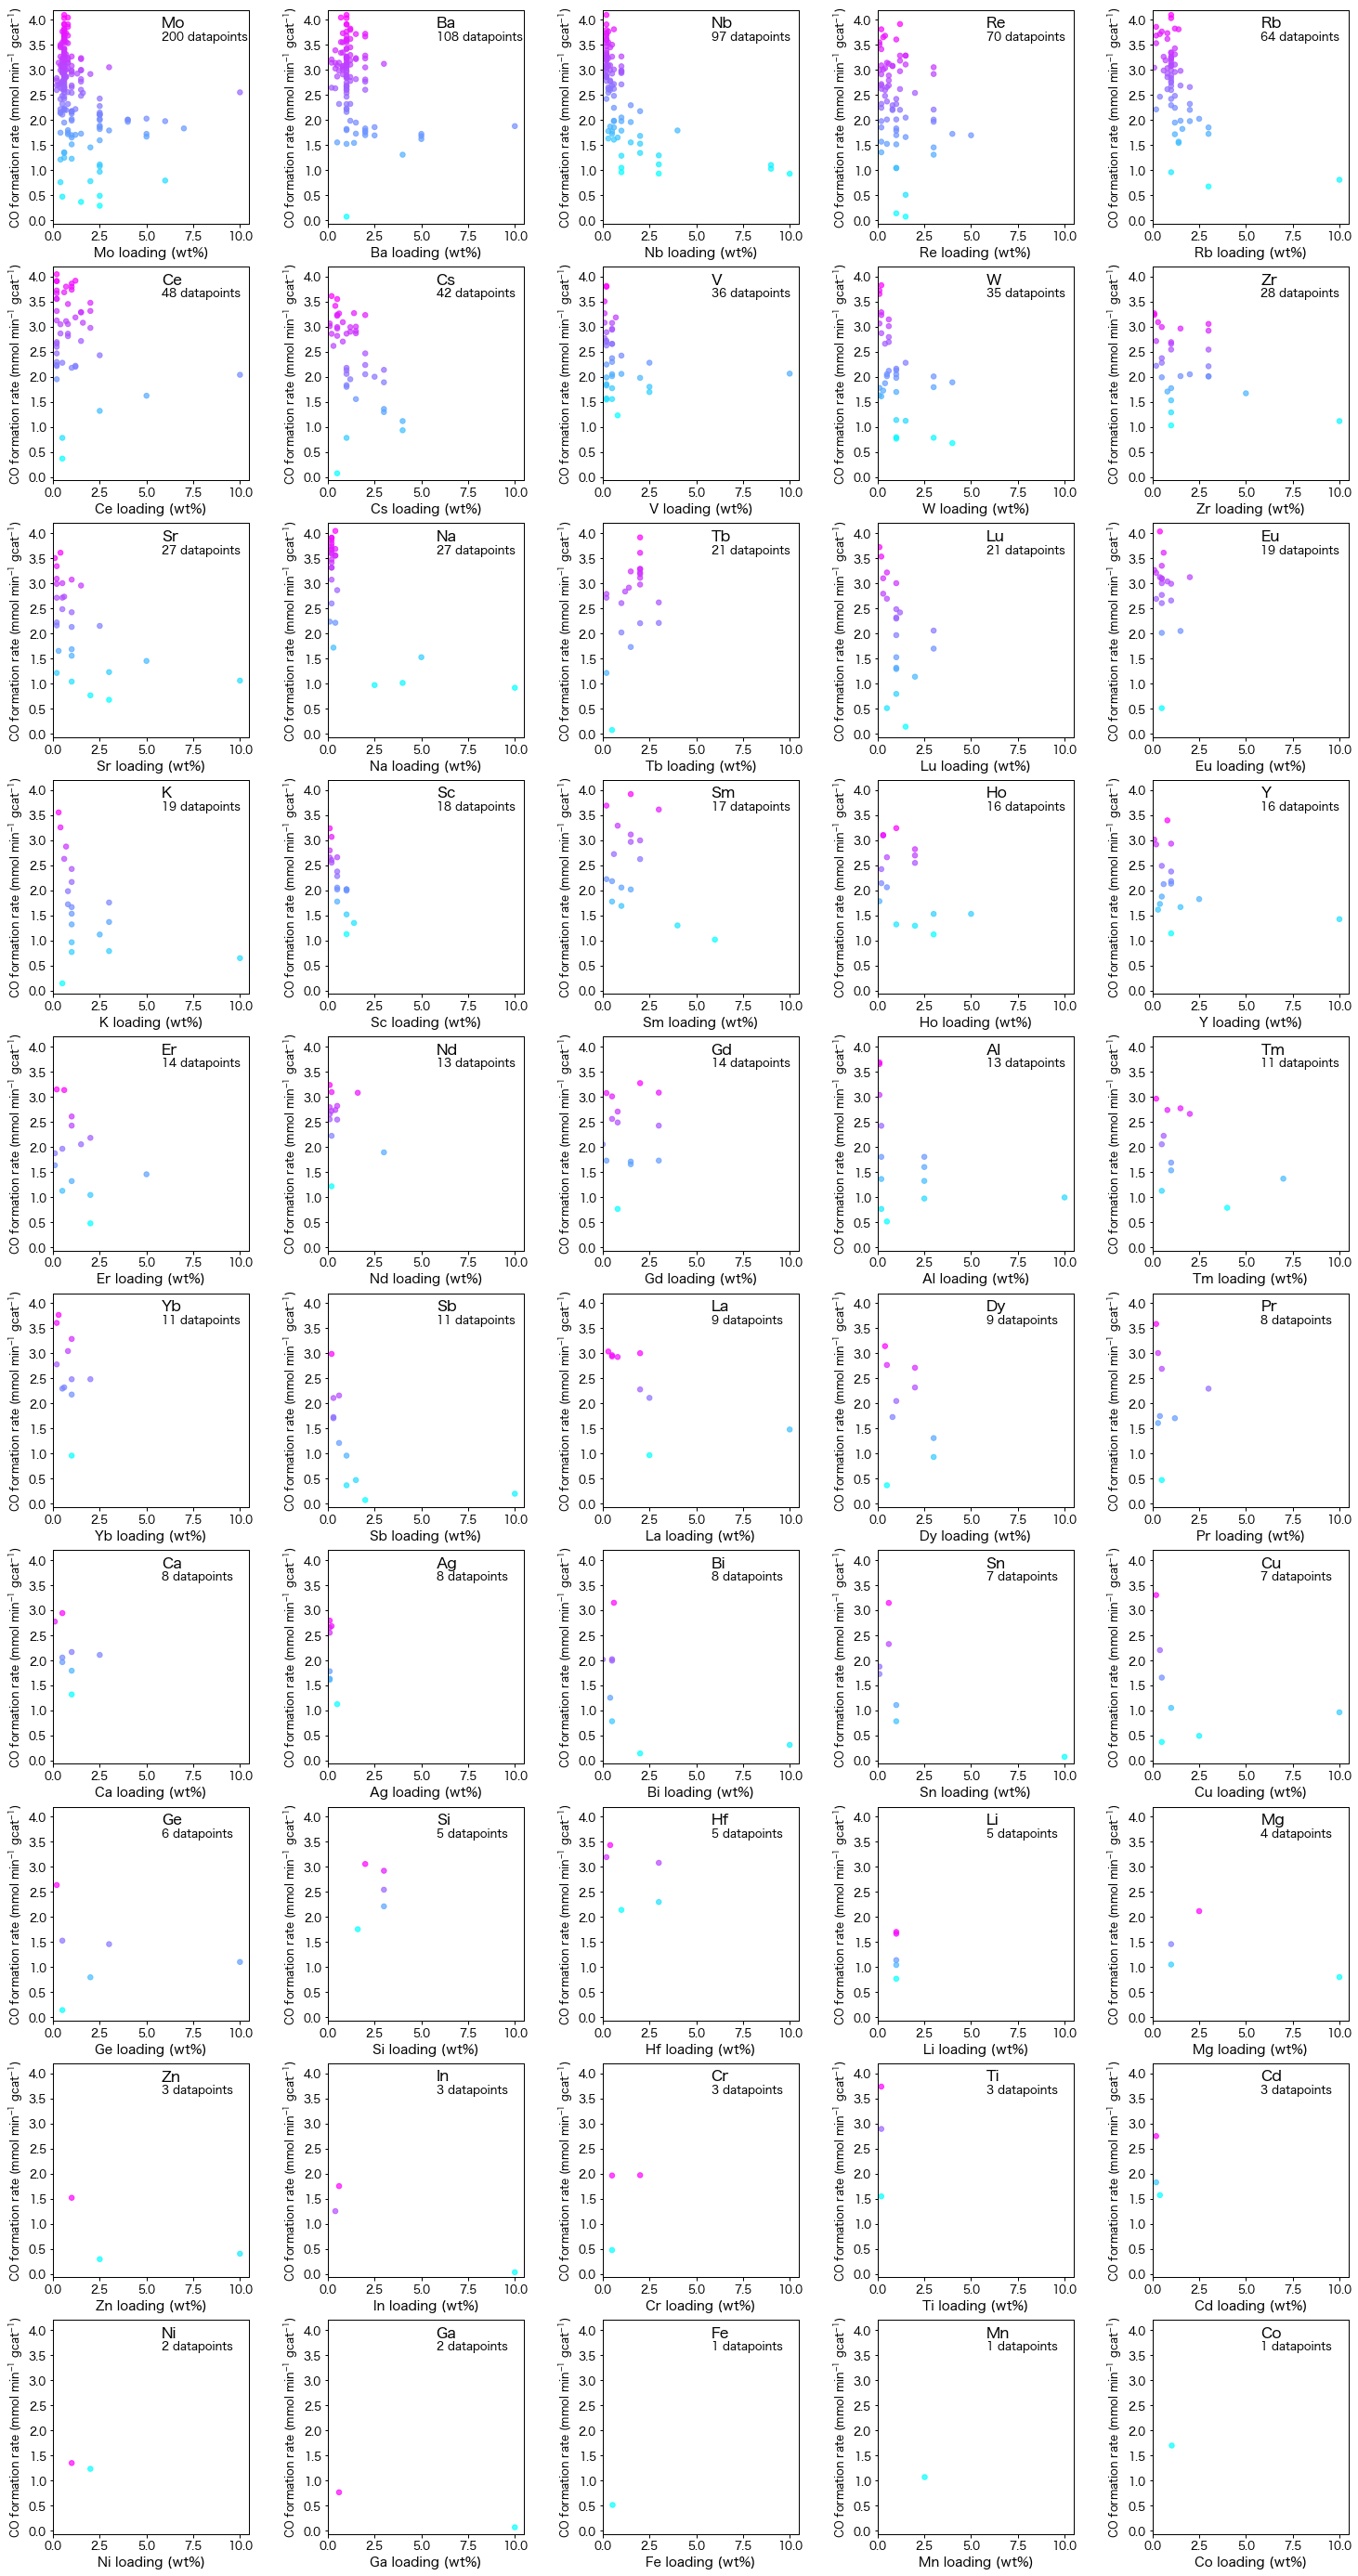

In [41]:
import math
n_cols = 5
n_idx = math.ceil(len(elem_num.columns)/n_cols)
fig, ax = plt.subplots(n_idx, n_cols, facecolor='white', figsize = (25, 50))
plt.subplots_adjust(wspace=0.4, hspace=0.2)

idx_num = np.arange(0, n_idx, 1)
idx_list = np.repeat(list(idx_num), n_cols)
col_list = np.array(list(np.arange(0, n_cols, 1))*len(idx_num))
elem_kinds = np.arange(0, len(elem_num.columns), 1)

cm = plt.get_cmap('cool')
z = preprocessing.minmax_scale(data_wt[target_name])

for elem, m, n in zip(elem_kinds, idx_list, col_list):
    extract_add = elem_num.columns[elem]
    data_wt_ext = pd.DataFrame(columns=data_wt.columns)
    for i in range(add_num):
        data_wt_ext = pd.concat([data_wt_ext, data_wt[data_wt[f'Ad{i+1}']==extract_add]], axis=0)

    data_wt_ext = data_wt_ext.reset_index()

    data_wt_ext_plot = pd.DataFrame(index=data_wt_ext.index, columns=[f'{extract_add}_wt%', target_name]).fillna(0)
    for i in range(len(data_wt_ext)):
        for j in range(add_num):
            if data_wt_ext.iloc[i, :][f'Ad{j+1}'] == extract_add:
                data_wt_ext_plot[f'{extract_add}_wt%'][i] = data_wt_ext.iloc[i, :][f'Ad{j+1}_wt%']
        data_wt_ext_plot[target_name][i] = data_wt_ext[target_name][i]

    ### Plot ###
    ax[m, n].set_xlabel(f'{extract_add} loading (wt%)', fontsize=14)
    ax[m, n].set_ylabel('CO formation rate (mmol $min^{{-}1}$ $gcat^{{-}1}$)', fontsize=12)

    #ax[m, n].set_tick_params(labelsize=12)
    z = preprocessing.minmax_scale(data_wt_ext_plot[target_name])
    ax[m, n].set_xlim(0, 10.5)
    ax[m ,n].set_ylim(data_wt[target_name].min()-0.1, data_wt[target_name].max()+0.1)
    ax[m, n].text(10-4.2, data_wt[target_name].max()-0.25, extract_add, fontsize=16)
    ax[m, n].text(10-4.2, data_wt[target_name].max()-0.5, f'{len(data_wt_ext_plot)} datapoints', fontsize=12)
    ax[m, n].scatter(data_wt_ext_plot[f'{extract_add}_wt%'], data_wt_ext_plot[target_name], zorder=2, s=30, marker='o', alpha=0.7, color=cm(z))
plt.savefig(f'{PATH}/wt-activity_plot_all.png', dpi=600, bbox_inches='tight')
plt.savefig(f'{PATH}/wt-activity_plot_all.pdf', dpi=600, bbox_inches='tight')

In [ ]:
from matplotlib import gridspec
import matplotlib as mpl

extract_adds_top10 = list(elem_num.columns[0:10])
for extract_adds in itertools.combinations(extract_adds_top10, 2):
    data_wt_ext_x = pd.DataFrame(columns=data_wt.columns)
    data_wt_ext_y = pd.DataFrame(columns=data_wt.columns)
    for i in range(add_num):
        data_wt_ext_x = pd.concat([data_wt_ext_x, data_wt[data_wt[f'Ad{i+1}']==extract_adds[0]]], axis=0)
        data_wt_ext_y = pd.concat([data_wt_ext_y, data_wt[data_wt[f'Ad{i+1}']==extract_adds[1]]], axis=0)
    data_wt_ext_x = data_wt_ext_x.reset_index()
    data_wt_ext_y = data_wt_ext_y.reset_index()
    data_wt_ext_xy = pd.concat([data_wt_ext_x, data_wt_ext_y], axis=0)
    data_wt_ext_xy = data_wt_ext_xy[data_wt_ext_xy.duplicated()].drop('index', axis=1).reset_index()

    data_wt_ext_plot2 = pd.DataFrame(index=data_wt_ext_xy.index, columns=[f'{extract_adds[0]}_wt%', f'{extract_adds[1]}_wt%', target_name]).fillna(0)
    for i in range(len(data_wt_ext_xy)):
        for j in range(add_num):
            if data_wt_ext_xy.iloc[i, :][f'Ad{j+1}'] == extract_adds[0]:
                data_wt_ext_plot2[f'{extract_adds[0]}_wt%'][i] = data_wt_ext_xy.iloc[i, :][f'Ad{j+1}_wt%']
            elif data_wt_ext_xy.iloc[i, :][f'Ad{j+1}'] == extract_adds[1]:
                data_wt_ext_plot2[f'{extract_adds[1]}_wt%'][i] = data_wt_ext_xy.iloc[i, :][f'Ad{j+1}_wt%']
        data_wt_ext_plot2[target_name][i] = data_wt_ext_xy[target_name][i]

    ### Plot ###
    fig = plt.figure(facecolor = 'white', figsize = (6, 6))
    spec = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[50, 1])

    ax1 = fig.add_subplot(spec[0])
    ax2 = fig.add_subplot(spec[1])

    ax1.set_xlabel(f'{extract_adds[0]} loading (wt%)', fontsize=14)
    ax1.set_ylabel(f'{extract_adds[1]} loading (wt%)', fontsize=14)

    plt.tick_params(labelsize=12)
    #cm = plt.get_cmap('Blues')
    cm = plt.get_cmap('cool')

    from sklearn import preprocessing
    z = preprocessing.minmax_scale(data_wt_ext_plot2[target_name])

    color_Mmax = data_wt_ext_plot2[target_name].max()
    color_Mmin = data_wt_ext_plot2[target_name].min()

    norm = mpl.colors.Normalize(vmin=color_Mmin, vmax=color_Mmax)
    cbar = mpl.colorbar.ColorbarBase(
        ax=ax2,
        cmap=plt.cm.cool,
        norm=norm,
        orientation="vertical",
        label="CO form rate (mmol $min^{{-}1}$ $gcat^{{-}1}$)",
    )

    ax1.scatter(data_wt_ext_plot2[f'{extract_adds[0]}_wt%'], data_wt_ext_plot2[f'{extract_adds[1]}_wt%'], zorder=2, s=30, marker='o', alpha=0.7, color=cm(z))
    plt.savefig(f'{PATH}/wt-activity_plot_{extract_adds[0]}-{extract_adds[1]}.png', dpi=600 ,bbox_inches='tight')

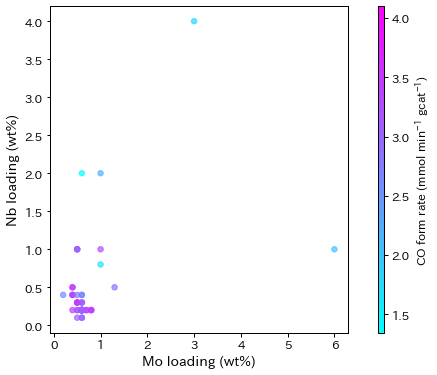

In [349]:
from matplotlib import gridspec
import matplotlib as mpl

extract_adds = ['Mo', 'Nb']
data_wt_ext_x = pd.DataFrame(columns=data_wt.columns)
data_wt_ext_y = pd.DataFrame(columns=data_wt.columns)
for i in range(add_num):
    data_wt_ext_x = pd.concat([data_wt_ext_x, data_wt[data_wt[f'Ad{i+1}']==extract_adds[0]]], axis=0)
    data_wt_ext_y = pd.concat([data_wt_ext_y, data_wt[data_wt[f'Ad{i+1}']==extract_adds[1]]], axis=0)
data_wt_ext_x = data_wt_ext_x.reset_index()
data_wt_ext_y = data_wt_ext_y.reset_index()
data_wt_ext_xy = pd.concat([data_wt_ext_x, data_wt_ext_y], axis=0)
data_wt_ext_xy = data_wt_ext_xy[data_wt_ext_xy.duplicated()].drop('index', axis=1).reset_index()

data_wt_ext_plot2 = pd.DataFrame(index=data_wt_ext_xy.index, columns=[f'{extract_adds[0]}_wt%', f'{extract_adds[1]}_wt%', target_name]).fillna(0)
for i in range(len(data_wt_ext_xy)):
    for j in range(add_num):
        if data_wt_ext_xy.iloc[i, :][f'Ad{j+1}'] == extract_adds[0]:
            data_wt_ext_plot2[f'{extract_adds[0]}_wt%'][i] = data_wt_ext_xy.iloc[i, :][f'Ad{j+1}_wt%']
        elif data_wt_ext_xy.iloc[i, :][f'Ad{j+1}'] == extract_adds[1]:
            data_wt_ext_plot2[f'{extract_adds[1]}_wt%'][i] = data_wt_ext_xy.iloc[i, :][f'Ad{j+1}_wt%']
    data_wt_ext_plot2[target_name][i] = data_wt_ext_xy[target_name][i]

### Plot ###
fig = plt.figure(facecolor = 'white', figsize = (6, 6))
spec = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[50, 1])

ax1 = fig.add_subplot(spec[0])
ax2 = fig.add_subplot(spec[1])

ax1.set_xlabel(f'{extract_adds[0]} loading (wt%)', fontsize=14)
ax1.set_ylabel(f'{extract_adds[1]} loading (wt%)', fontsize=14)

plt.tick_params(labelsize=12)
#cm = plt.get_cmap('Blues')
cm = plt.get_cmap('cool')

from sklearn import preprocessing
z = preprocessing.minmax_scale(data_wt_ext_plot2[target_name])

color_Mmax = data_wt_ext_plot2[target_name].max()
color_Mmin = data_wt_ext_plot2[target_name].min()

norm = mpl.colors.Normalize(vmin=color_Mmin, vmax=color_Mmax)
cbar = mpl.colorbar.ColorbarBase(
    ax=ax2,
    cmap=plt.cm.cool,
    norm=norm,
    orientation="vertical",
    label="CO form rate (mmol $min^{{-}1}$ $gcat^{{-}1}$)",
)

ax1.scatter(data_wt_ext_plot2[f'{extract_adds[0]}_wt%'], data_wt_ext_plot2[f'{extract_adds[1]}_wt%'], zorder=2, s=30, marker='o', alpha=0.7, color=cm(z))
plt.savefig(f'{PATH}/wt-activity_plot_{extract_adds[0]}-{extract_adds[1]}.png', dpi=600 ,bbox_inches='tight')

### Box plot

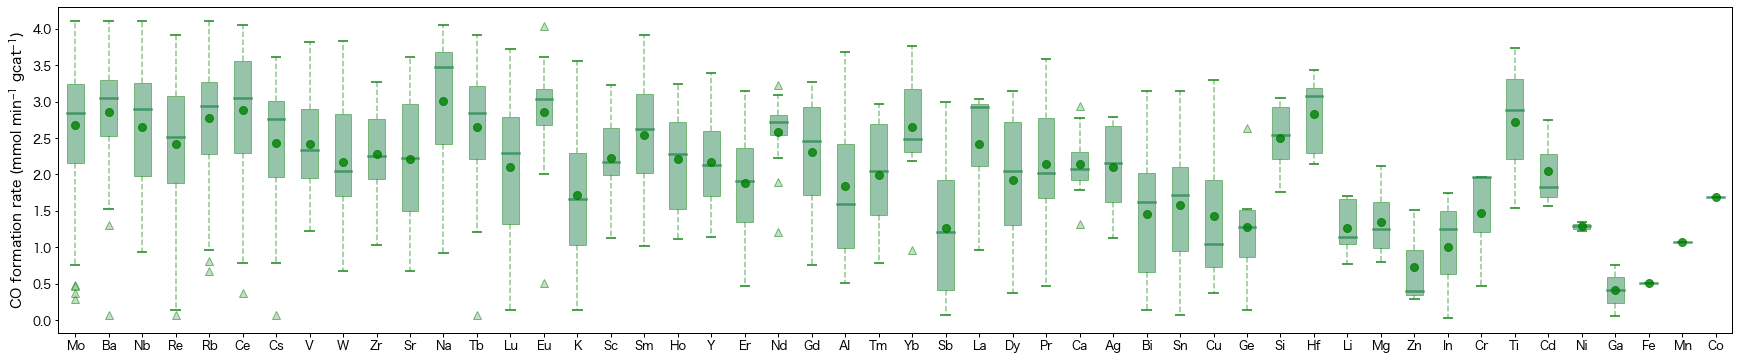

In [33]:
data_wt_plot_all = pd.DataFrame()
for elem in range(len(elem_num.columns)):
    extract_add = elem_num.columns[elem]
    data_wt_ext = pd.DataFrame(columns=data_wt.columns)
    for i in range(add_num):
        data_wt_ext = pd.concat([data_wt_ext, data_wt[data_wt[f'Ad{i+1}']==extract_add]], axis=0)

    data_wt_ext = data_wt_ext.reset_index()

    data_wt_ext_plot = pd.DataFrame(index=data_wt_ext.index, columns=[f'{extract_add}_wt%', target_name]).fillna(0)
    for i in range(len(data_wt_ext)):
        for j in range(add_num):
            if data_wt_ext.iloc[i, :][f'Ad{j+1}'] == extract_add:
                data_wt_ext_plot[f'{extract_add}_wt%'][i] = data_wt_ext.iloc[i, :][f'Ad{j+1}_wt%']
        data_wt_ext_plot[target_name][i] = data_wt_ext[target_name][i]
    data_wt_plot_all = pd.concat([data_wt_plot_all, data_wt_ext_plot], axis=1)

plt.figure(figsize=(30, 6), facecolor='white')

bbox_props = dict(facecolor='seagreen', color='forestgreen', alpha=0.5, linestyle='dashed', linewidth=1)
median_props = dict(color='seagreen', alpha=0.8, linestyle='solid', linewidth=2.5)
cap_props = dict(color='forestgreen', alpha=0.8, linestyle='solid', linewidth=2)
line_props = dict(color='forestgreen', alpha=0.5, linestyle='dashed', linewidth=1.5)
mean_props = dict(markerfacecolor='green', markeredgecolor='green', marker='o', alpha=0.8, markersize=8)
flier_props = dict(markerfacecolor='darkseagreen', markeredgecolor='green', marker='^', alpha=0.5, markersize=8)

plt.boxplot([data_wt_plot_all.iloc[:, (2*i)+1].dropna() for i in range(len(elem_num.columns))], labels=elem_num.columns,
            notch=False, showmeans=True, patch_artist=True,
            flierprops=flier_props, medianprops=median_props, boxprops=bbox_props, meanprops=mean_props, capprops=cap_props, whiskerprops=line_props)
plt.ylabel('CO formation rate (mmol $min^{{-}1}$ $gcat^{{-}1}$)', fontsize=14)
plt.savefig(f'{PATH}/box_plot.png', dpi=600, bbox_inches='tight')


### Violin plot

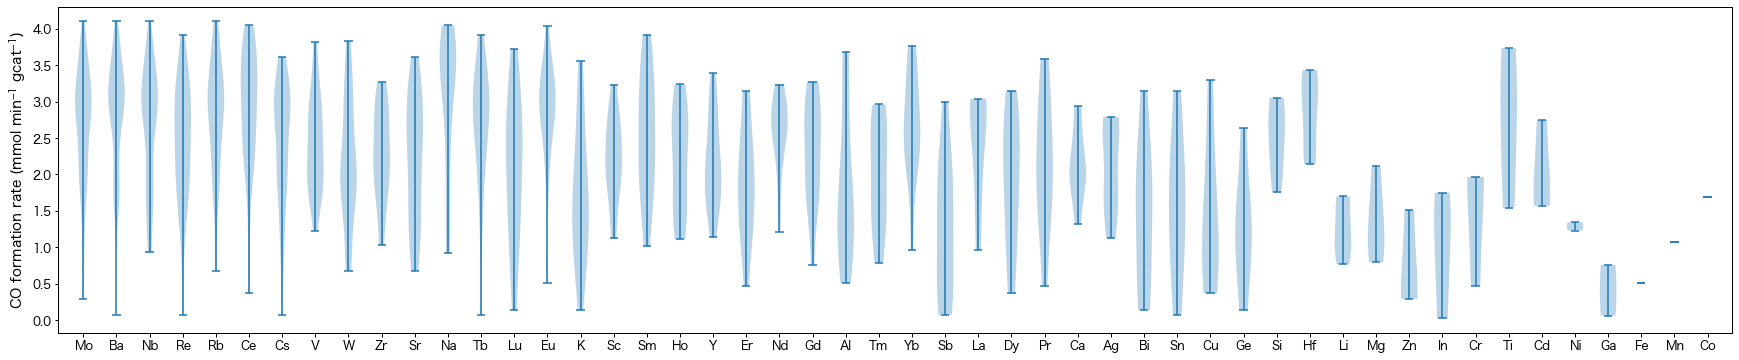

In [34]:
def set_axis_style(ax, labels):
    ax.xaxis.set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)

fig, ax = plt.subplots(facecolor = 'white', figsize = (30, 6))
ax.violinplot([data_wt_plot_all.iloc[:, (2*i)+1].dropna() for i in range(len(elem_num.columns))])
set_axis_style(ax, elem_num.columns)

ax.set_ylabel('CO formation rate (mmol $min^{{-}1}$ $gcat^{{-}1}$)', fontsize=14)
plt.savefig(f'{PATH}/violin_plot.png', dpi=600, bbox_inches='tight')

### Box + Violin

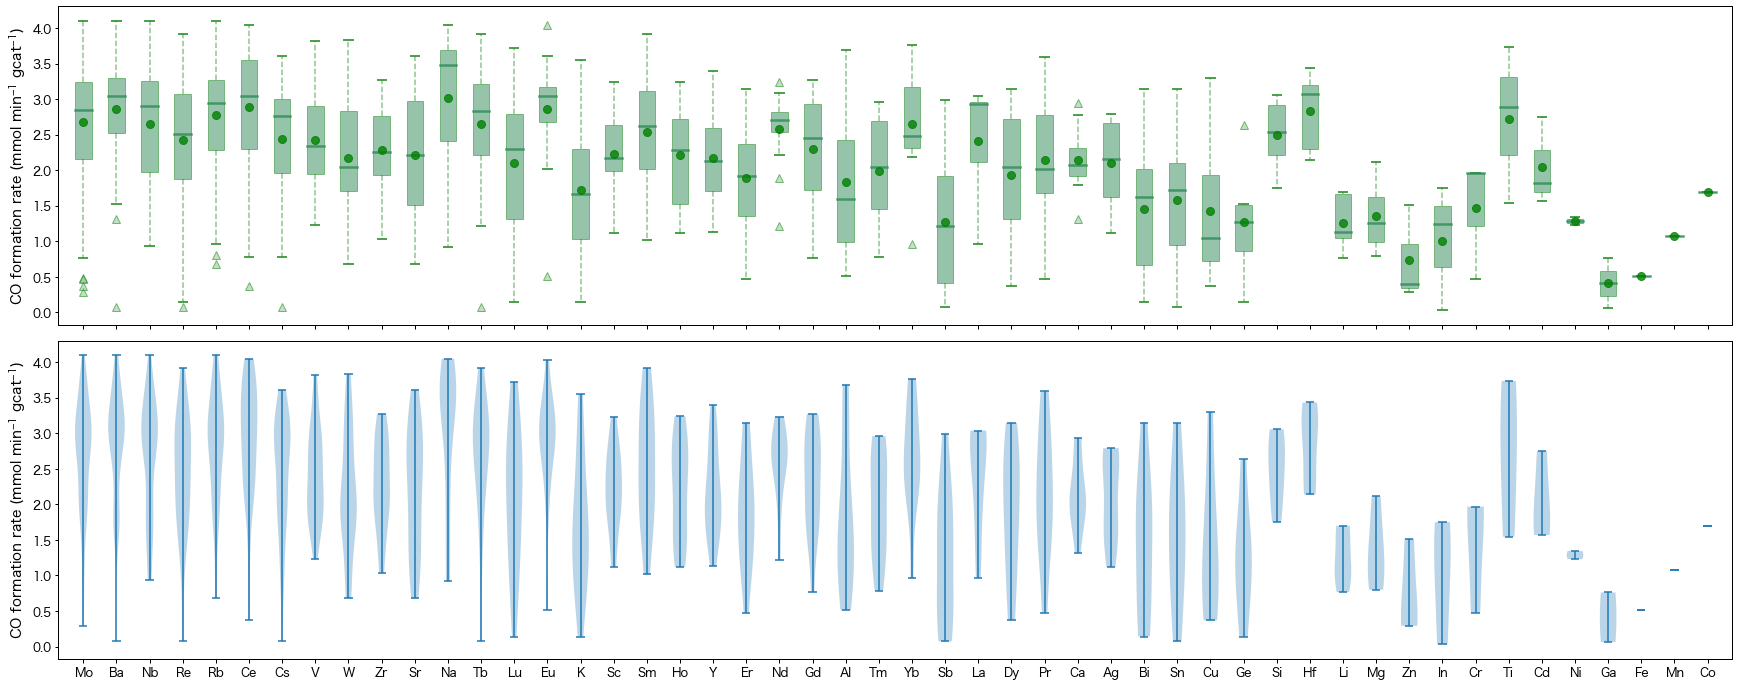

In [37]:
# For violin plot
def set_axis_style(ax, labels):
    ax.xaxis.set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)

# For Box plot
data_wt_plot_all = pd.DataFrame()
for elem in range(len(elem_num.columns)):
    extract_add = elem_num.columns[elem]
    data_wt_ext = pd.DataFrame(columns=data_wt.columns)
    for i in range(add_num):
        data_wt_ext = pd.concat([data_wt_ext, data_wt[data_wt[f'Ad{i+1}']==extract_add]], axis=0)

    data_wt_ext = data_wt_ext.reset_index()

    data_wt_ext_plot = pd.DataFrame(index=data_wt_ext.index, columns=[f'{extract_add}_wt%', target_name]).fillna(0)
    for i in range(len(data_wt_ext)):
        for j in range(add_num):
            if data_wt_ext.iloc[i, :][f'Ad{j+1}'] == extract_add:
                data_wt_ext_plot[f'{extract_add}_wt%'][i] = data_wt_ext.iloc[i, :][f'Ad{j+1}_wt%']
        data_wt_ext_plot[target_name][i] = data_wt_ext[target_name][i]
    data_wt_plot_all = pd.concat([data_wt_plot_all, data_wt_ext_plot], axis=1)

fig, ax = plt.subplots(2, 1, sharex=True, facecolor='white', figsize=(30, 12))
plt.subplots_adjust(hspace=0.05)

bbox_props = dict(facecolor='seagreen', color='forestgreen', alpha=0.5, linestyle='dashed', linewidth=1)
median_props = dict(color='seagreen', alpha=0.8, linestyle='solid', linewidth=2.5)
cap_props = dict(color='forestgreen', alpha=0.8, linestyle='solid', linewidth=2)
line_props = dict(color='forestgreen', alpha=0.5, linestyle='dashed', linewidth=1.5)
mean_props = dict(markerfacecolor='green', markeredgecolor='green', marker='o', alpha=0.8, markersize=8)
flier_props = dict(markerfacecolor='darkseagreen', markeredgecolor='green', marker='^', alpha=0.5, markersize=8)

ax[0].boxplot([data_wt_plot_all.iloc[:, (2*i)+1].dropna() for i in range(len(elem_num.columns))], labels=elem_num.columns,
            notch=False, showmeans=True, patch_artist=True,
            flierprops=flier_props, medianprops=median_props, boxprops=bbox_props, meanprops=mean_props, capprops=cap_props, whiskerprops=line_props)
ax[0].set_ylabel('CO formation rate (mmol $min^{{-}1}$ $gcat^{{-}1}$)', fontsize=14)

ax[1].violinplot([data_wt_plot_all.iloc[:, (2*i)+1].dropna() for i in range(len(elem_num.columns))])
set_axis_style(ax[1], elem_num.columns)

ax[1].set_ylabel('CO formation rate (mmol $min^{{-}1}$ $gcat^{{-}1}$)', fontsize=14)

plt.savefig(f'{PATH}/box+violin_plot.png', dpi=600, bbox_inches='tight')

In [46]:
condition = conditions.calc_condition()
Reaction, data_sheet_name = condition['Reaction'], condition['data_sheet_name']
pgm_model, add_model, supp_model = condition['pgm_model'], condition['add_model'], condition['supp_model']
pgm_num, add_num, supp_num = condition['pgm_num'], condition['add_num'], condition['supp_num']
target_name = condition['target_name']
converted = analysis.analysis_data_convert(condition, data_sheet_name, use_models=[pgm_model, add_model, supp_model], idx=None)
data, feat, target = converted['data'], converted['feat'], converted['target']
feat_cols = feat.columns

data_cols = conditions.data_columns(Reaction, condition)
elem_cols = data_cols['elem']
wt_cols = data_cols['wt']
data[wt_cols] = data[wt_cols].astype('float')
#pd.options.display.float_format = '{:.4g}'.format
data = data.drop(['No.', 'CO Yield_%', 'CO formation rate_mmol min-1 gcat-1', 'Iteration', 'Catal prep', 'Reaction', 'Note'], axis=1)

data_sort = pd.DataFrame(index=np.arange(0, len(data), 1), columns=np.arange(0, len(data.columns), 1))
for i in range(len(data)):
    data_sort_elem = data.loc[i][[data.loc[i][wt_cols].sort_values(ascending=False).index[Adi].replace('_wt%', '') for Adi in range(add_num)]].reset_index().T.drop('index', axis=0)
    data_sort_wt = data.loc[i][wt_cols].sort_values(ascending=False).reset_index().T.drop('index', axis=0)
    data_sort.iloc[i] = pd.concat([data_sort_elem, data_sort_wt], axis=1)
data_sort = data_sort.rename(columns={
    0: f'{elem_cols[0]}', 1: f'{elem_cols[1]}', 2: f'{elem_cols[2]}', 3: f'{elem_cols[3]}', 4: f'{elem_cols[4]}',
    5: f'{wt_cols[0]}', 6: f'{wt_cols[1]}', 7: f'{wt_cols[2]}', 8: f'{wt_cols[3]}', 9: f'{wt_cols[4]}'
    }).reindex(columns=data.columns)
data_sort['Catalyst'] = 'Pt(3)/'

for i in range(len(data)):
    for j in range(add_num):
        if data_sort[elem_cols[j]][i] != 'H' and j == 0:
            data_sort['Catalyst'][i] += data_sort[elem_cols[j]][i]
        elif data_sort[elem_cols[j]][i] != 'H' and j != 0:
            data_sort['Catalyst'][i] += '-' + data_sort[elem_cols[j]][i]
        else:
            pass
        if data_sort[wt_cols[j]][i] >= 1:
            data_sort[wt_cols[j]][i] = data_sort[wt_cols[j]][i].astype(int)
            data_sort['Catalyst'][i] += '(' + data_sort[wt_cols[j]][i].astype(str) + ')'
        elif data_sort[wt_cols[j]][i] < 1 and data_sort[wt_cols[j]][i] > 0:
            data_sort['Catalyst'][i] += '(' + data_sort[wt_cols[j]][i].astype(str) + ')'
        else:
            pass
data_sort['Catalyst'] += '/TiO2'

Table_S3 = converted['data']
Table_S3 = Table_S3.drop(elem_cols, axis=1).drop(wt_cols, axis=1).drop(['Catal prep', 'Reaction', 'Note'], axis=1).rename(columns = {'No.':'ID'})
Table_S3.loc[:, ['CO Yield_%', 	'CO formation rate_mmol min-1 gcat-1']] = Table_S3.loc[:, ['CO Yield_%', 	'CO formation rate_mmol min-1 gcat-1']].round(2)
Table_S3.insert(loc = 1, column= 'Catalyst', value= data_sort['Catalyst'])
Table_S3.insert(loc = 3, column= 'CO selectivity_%', value= 100)
Table_S3.to_csv(f'{PATH2}/Table_S3.csv')
Table_S3

20220318 rwgs_250 all data


ID                                          Catalyst  CO Yield_%  \
0      1                                 Pt(3)/Mo(10)/TiO2        3.07   
1      2                                  Pt(3)/V(10)/TiO2        2.48   
2      3                                 Pt(3)/Ce(10)/TiO2        2.45   
3      4                                 Pt(3)/La(10)/TiO2        1.78   
4      5                                  Pt(3)/Y(10)/TiO2        1.71   
..   ...                                               ...         ...   
295  296             Pt(3)/Ba(2)-Re(1)-Mo(0.6)-W(0.2)/TiO2        3.94   
296  297    Pt(3)/Rb(1)-Ba(1)-Mo(0.5)-Nb(0.2)-Hf(0.2)/TiO2        3.83   
297  298          Pt(3)/Mo(0.7)-K(0.7)-Ba(0.5)-W(0.2)/TiO2        3.44   
298  299  Pt(3)/Rb(1)-Mo(0.7)-Ce(0.2)-Nb(0.2)-Na(0.2)/TiO2        3.98   
299  300    Pt(3)/Ba(1)-Rb(1)-Mo(0.5)-Nb(0.2)-Yb(0.2)/TiO2        3.34   

     CO selectivity_%  CO formation rate_mmol min-1 gcat-1  Iteration  
0                 100                                 2.55          0  
1                 100                                 2.06          0  
2                 100                                 2.04          0  
3                 100                                 1.48          0  
4                 100                                 1.42          0  
..                ...                                  ...        ...  
295               100                                 3.29         44  
296               100                                 3.19         44  
297               100                                 2.87         44  
298               100                                 3.31         44  
299               100                                 2.78         44  

[300 rows x 6 columns]

In [47]:
vs_paper = pd.read_excel('data/data_vs_paper.xlsx')
vs_paper

No.                      Referance catalyst  H2/CO2  T (℃)  P (bar)  \
0     1  Pt(3)/Rb(1)-Nb(0.2)-Mo(0.6)-Ba(1)/TiO2     3.0    250      1.0   
1     2          Pt(3)/Rb(1)-Mo(0.6)-Ba(1)/TiO2     3.0    250      1.0   
2     3                      Pt(3)/Mo(0.6)/TiO2     3.0    250      1.0   
3     4                      Cu(10)/ZnO(5)/SiO2     3.0    250      1.0   
4     5                    Rh(5)-Li(10)/Zeolite     3.0    250      1.0   
5     6                            Rh(0.4)/SiO2     3.0    250      1.0   
6     7               Pt(0.05)-K(0.8)/Zeolite_L     1.0    250      1.0   
7     8                            Ni(2.4)/SiO2     4.0    250      1.0   
8     9                              Au(1)/TiO2     4.0    250      1.0   
9    10                              Pt(5)/TiO2     1.0    250     30.0   
10   11                       Pt(5)-NH2MPA/TiO2    14.3    250      1.0   
11   12                              Pt(1)/CeO2     1.0    250      1.0   
12   13                    H-SiO2@Ru(0.48)@SiO2     1.0    250      1.0   
13   14                           Au(2.76)/TiO2     4.0    250      1.0   
14   15                              Pt(2)/CeO2    12.5    250     30.0   
15   16                    Cu(0.5)-Ni(0.5)/SiO2     4.0    250     10.0   
16   17                              CuMgAl-LDH     4.0    250      1.0   
17   18                      Rh(0.0009)@S-1/WO3     3.0    250      1.0   
18   19                          Rh(0.05)/Fe3O4     4.0    250     10.0   
19   20                            Pt(0.8)/CeO2     3.0    250      1.0   
20   21                       Pt(3)/Mo(10)/TiO2     3.0    250      1.0   
21   22                            Ru(1.9)/MoO3     3.0    250      1.0   
22   23                          ncSi:H (Light)     1.0    170      1.9   
23   24                           ncSi:H (Dark)     1.0    170      1.9   
24   25               Pt(1)Mo(0.3)/SiO2 (Light)     2.0    200      7.1   
25   26                Pt(1)Mo(0.3)/SiO2 (Dark)     2.0    200      7.1   
26   27               Ni12P5(10.4)/SiO2 (Light)     5.0    240      1.2   
27   28                Ni12P5(10.4)/SiO2 (Dark)     5.0    240      1.2   
28   29                Pd(1)Cu(0.2)/WO3 (Light)     1.0    250      1.0   
29   30                 Pd(1)Cu(0.2)/WO3 (Dark)     1.0    250      1.0   
30   31                Pd(1)Ba(0.2)/WO3 (Light)     1.0    250      1.0   
31   32                 Pd(1)Ba(0.2)/WO3 (Dark)     1.0    250      1.0   
32   33                           In2O3 (Light)     1.0    250      1.0   
33   34                            In2O3 (Dark)     1.0    250      1.0   
34   35                  HzIn2O3-x(OH)y (Light)     1.0    250      1.0   
35   36                   HzIn2O3-x(OH)y (Dark)     1.0    250      1.0   

    GHSV (mL gcat-1 h-1) (only H2+CO2)  CO2 conversion (%)  Selectivity (%)  \
0                             480000.0                4.91            100.0   
1                             480000.0                4.25            100.0   
2                             480000.0                4.05            100.0   
3                              48000.0               29.80            100.0   
4                              43200.0                3.00            100.0   
5                             175000.0                0.90             93.8   
6                              27000.0                1.00            100.0   
7                              40000.0                3.20            100.0   
8                               7500.0               11.50            100.0   
9                                240.0               13.00             87.0   
10                              5400.0                4.00             97.5   
11                             30000.0                1.50            100.0   
12                             16050.0                8.40             95.1   
13                             27000.0                0.60            100.0   
14                                 NaN     

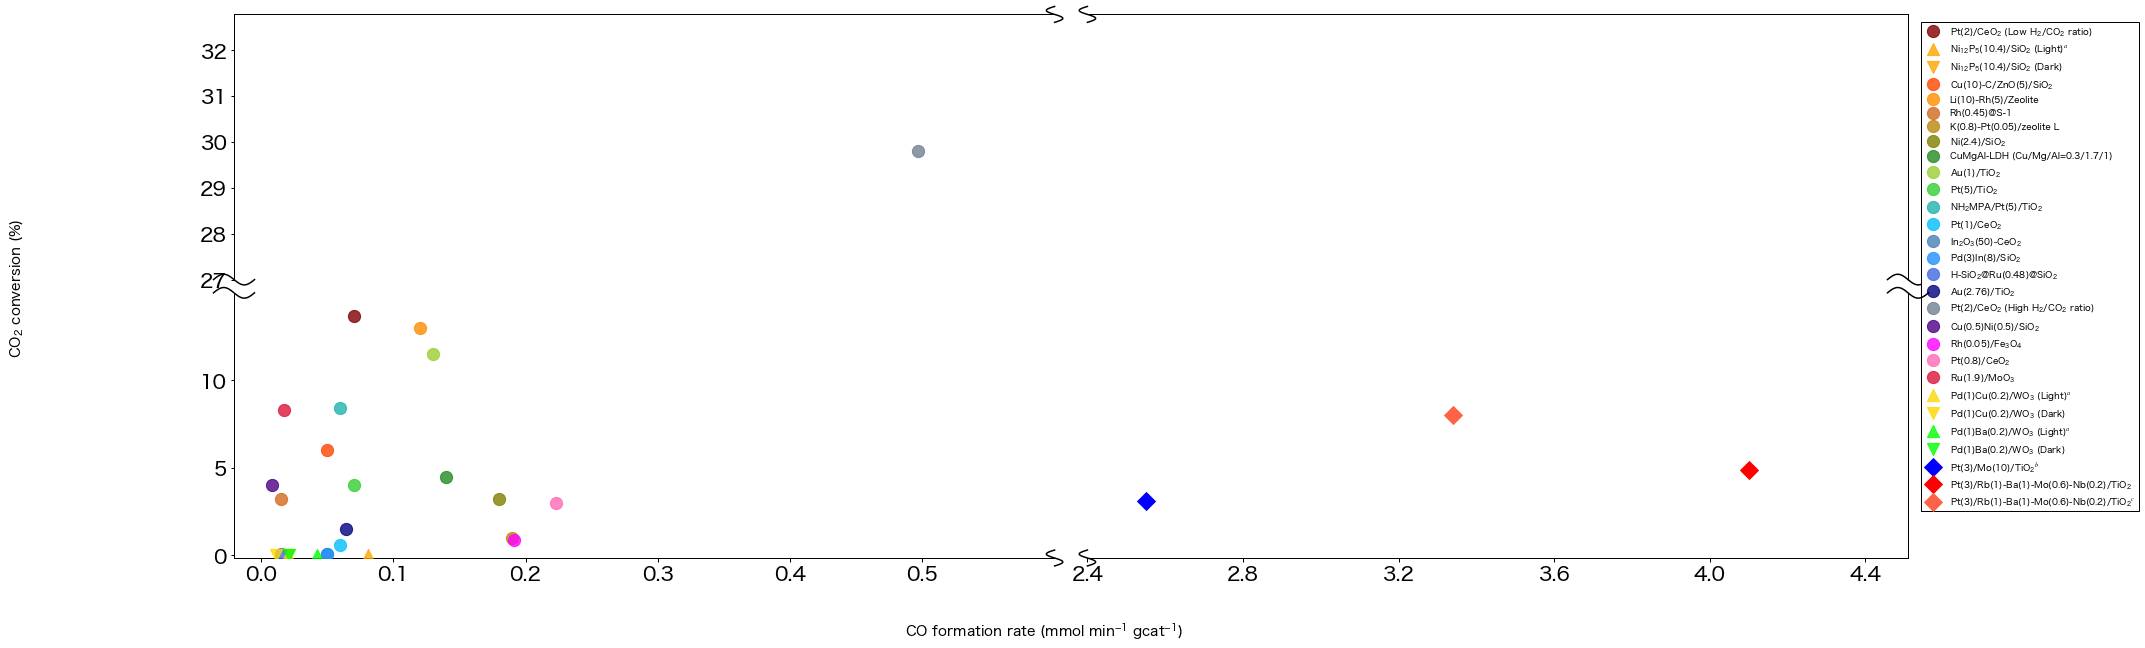

In [6]:
vs_paper = pd.read_excel('data/data_vs_previous_reports_v2.xlsx', sheet_name='data_tableS3_2')
idx = vs_paper['select']==1
vs_paper = vs_paper[idx].reset_index()


fig, axes = plt.subplots(2, 2, facecolor='white', sharex='col', sharey='row', figsize = (30, 10), zorder=1)
fig.subplots_adjust(hspace=0.05, wspace=0.04)

axes[1, 0].set_xlim([-vs_paper['CO formation rate (mmol gcat-1 min-1)'].max()*0.005, 0.6])
axes[1, 1].set_xlim([2.4, vs_paper['CO formation rate (mmol gcat-1 min-1)'].max()*1.1])
axes[1, 0].set_ylim([-vs_paper['CO2 conversion (%)'].max()*0.005, 15])
axes[0, 0].set_ylim([27, vs_paper['CO2 conversion (%)'].max()*1.1])

axes[1, 0].set_xticks(np.arange(round(-vs_paper['CO formation rate (mmol gcat-1 min-1)'].max()*0.005, 1), 0.6, 0.1))
axes[1, 1].set_xticks(np.arange(2.4, round(vs_paper['CO formation rate (mmol gcat-1 min-1)'].max()*1.1, 1), 0.4))
axes[1, 0].set_yticks(np.arange(round(-vs_paper['CO2 conversion (%)'].max()*0.005, 0), 15, 5))
axes[0, 0].set_yticks(np.arange(27, round(vs_paper['CO2 conversion (%)'].max()*1.1, 0), 1))

axes[0, 0].spines.bottom.set_visible(False)
axes[0, 1].spines.bottom.set_visible(False)
axes[1, 0].spines.top.set_visible(False)
axes[1, 1].spines.top.set_visible(False)
axes[0, 0].spines.right.set_visible(False)
axes[1, 0].spines.right.set_visible(False)
axes[0, 1].spines.left.set_visible(False)
axes[1, 1].spines.left.set_visible(False)

axes[0, 0].xaxis.tick_top()
axes[0, 1].xaxis.tick_top()
axes[1, 0].xaxis.tick_bottom()
axes[1, 1].xaxis.tick_bottom()
axes[0, 1].yaxis.tick_right()
axes[1, 1].yaxis.tick_right()

axes[0, 0].tick_params(labeltop=False, top=False)
axes[0, 1].tick_params(labeltop=False, top=False, left=False, right=False)
axes[1, 1].tick_params(labeltop=False, top=False, left=False, right=False)

dx = 0.025  # proportion of vertical to horizontal extent of the slanted line
x_h1 = np.linspace(-dx, +dx, 100)
x_h2 = np.linspace(1 - dx, 1 + dx, 100)
y_h1 = np.sin(np.linspace(0, 2*np.pi, 100))/50
y_h2 = np.sin(np.linspace(0, 2*np.pi, 100))/50+1

dy = 0.03
x_v1 = np.linspace(-dy, +dy, 100)
x_v2 = np.linspace(1 - dy, 1 + dy, 100)
y_v1 = np.sin(np.linspace(0, 2*np.pi, 100))/100
y_v2 = np.sin(np.linspace(0, 2*np.pi, 100))/100+1

kwargs = dict(transform=axes[0,0].transAxes, color='k', clip_on=False)
axes[0, 0].plot(x_h1, y_h1, **kwargs)
kwargs = dict(transform=axes[1,0].transAxes, color='k', clip_on=False)
axes[1, 0].plot(x_h1, y_h2, **kwargs)

kwargs = dict(transform=axes[0,1].transAxes, color='k', clip_on=False)
axes[0, 1].plot(x_h2, y_h1, **kwargs)
kwargs = dict(transform=axes[1,1].transAxes, color='k', clip_on=False)
axes[1, 1].plot(x_h2, y_h2, **kwargs)

kwargs = dict(transform=axes[0,0].transAxes, color='k', clip_on=False)
axes[0, 1].plot(y_v2, x_v2, **kwargs)
kwargs = dict(transform=axes[1,0].transAxes, color='k', clip_on=False)
axes[1, 0].plot(y_v2, x_v1, **kwargs)

kwargs = dict(transform=axes[1,1].transAxes, color='k', clip_on=False)
axes[1, 1].plot(y_v1, x_v1, **kwargs)
kwargs = dict(transform=axes[0,1].transAxes, color='k', clip_on=False)
axes[0, 1].plot(y_v1, x_v2, **kwargs)
axes[0, 1].tick_params(labelsize=7)
fig.supxlabel('CO formation rate (mmol $min^{{-}1}$ $gcat^{{-}1}$)', fontsize=14)
fig.supylabel('$CO_{2}$ conversion (%)', fontsize=14)

axes[0, 0].tick_params(axis='y', labelsize=20)
axes[1, 0].tick_params(axis='x', labelsize=20)
axes[1, 0].tick_params(axis='y', labelsize=20)
axes[1, 1].tick_params(axis='x', labelsize=20)

"""
for i in range(len(vs_paper.index)):
    if vs_paper['CO formation rate (mmol gcat-1 min-1)'][i] <= 0.6 and  vs_paper['CO2 conversion (%)'][i] >= 27:
            axes[0, 0].scatter(
                vs_paper['CO formation rate (mmol gcat-1 min-1)'][i], vs_paper['CO2 conversion (%)'][i],
                zorder=4, s=30, marker='o', alpha=0.7, color=cm(z_small[i]), label=vs_paper['Referance catalyst'][i])
    elif vs_paper['CO formation rate (mmol gcat-1 min-1)'][i] >= 2.4 and  vs_paper['CO2 conversion (%)'][i] >= 27:
            axes[0, 1].scatter(
                vs_paper['CO formation rate (mmol gcat-1 min-1)'][i], vs_paper['CO2 conversion (%)'][i],
                zorder=4, s=30, marker='o', alpha=0.7, color=cm(z_all[i]), label=vs_paper['Referance catalyst'][i])
    elif vs_paper['CO formation rate (mmol gcat-1 min-1)'][i] <= 0.6 and  vs_paper['CO2 conversion (%)'][i] <=15:
            axes[1, 0].scatter(
                vs_paper['CO formation rate (mmol gcat-1 min-1)'][i], vs_paper['CO2 conversion (%)'][i],
                zorder=4, s=30, marker='o', alpha=0.7, color=cm(z_small[i]), label=vs_paper['Referance catalyst'][i])
    elif vs_paper['CO formation rate (mmol gcat-1 min-1)'][i] >= 2.4 and  vs_paper['CO2 conversion (%)'][i] <= 15:
            axes[1, 1].scatter(
                vs_paper['CO formation rate (mmol gcat-1 min-1)'][i], vs_paper['CO2 conversion (%)'][i],
                zorder=4, s=30, marker='o', alpha=0.7, color=cm(z_all[i]), label=vs_paper['Referance catalyst'][i])
"""

for i in range(len(vs_paper.index)):
    axes[0, 0].scatter(
        vs_paper['CO formation rate (mmol gcat-1 min-1)'][i], vs_paper['CO2 conversion (%)'][i],
        zorder=4, s=vs_paper['size'][i], marker=vs_paper['marker'][i], alpha=vs_paper['alpha'][i], color=vs_paper['color'][i], label=vs_paper['Referance catalyst'][i])
    axes[0, 1].scatter(
        vs_paper['CO formation rate (mmol gcat-1 min-1)'][i], vs_paper['CO2 conversion (%)'][i],
        zorder=4, s=vs_paper['size'][i], marker=vs_paper['marker'][i], alpha=vs_paper['alpha'][i], color=vs_paper['color'][i], label=vs_paper['Referance catalyst'][i])
    axes[1, 0].scatter(
        vs_paper['CO formation rate (mmol gcat-1 min-1)'][i], vs_paper['CO2 conversion (%)'][i],
        zorder=4, s=vs_paper['size'][i], marker=vs_paper['marker'][i], alpha=vs_paper['alpha'][i], color=vs_paper['color'][i], label=vs_paper['Referance catalyst'][i])
    axes[1, 1].scatter(
        vs_paper['CO formation rate (mmol gcat-1 min-1)'][i], vs_paper['CO2 conversion (%)'][i],
        zorder=4, s=vs_paper['size'][i], marker=vs_paper['marker'][i], alpha=vs_paper['alpha'][i], color=vs_paper['color'][i], label=vs_paper['Referance catalyst'][i])

axes[1, 0].legend(markerscale=1, bbox_to_anchor=(2.05, 1.0, 0.3, 0.2), loc='center left', fontsize='9')
plt.savefig(f'{PATH}/vs_paper_form_vs_conv_v6.png', dpi=600, bbox_inches='tight')

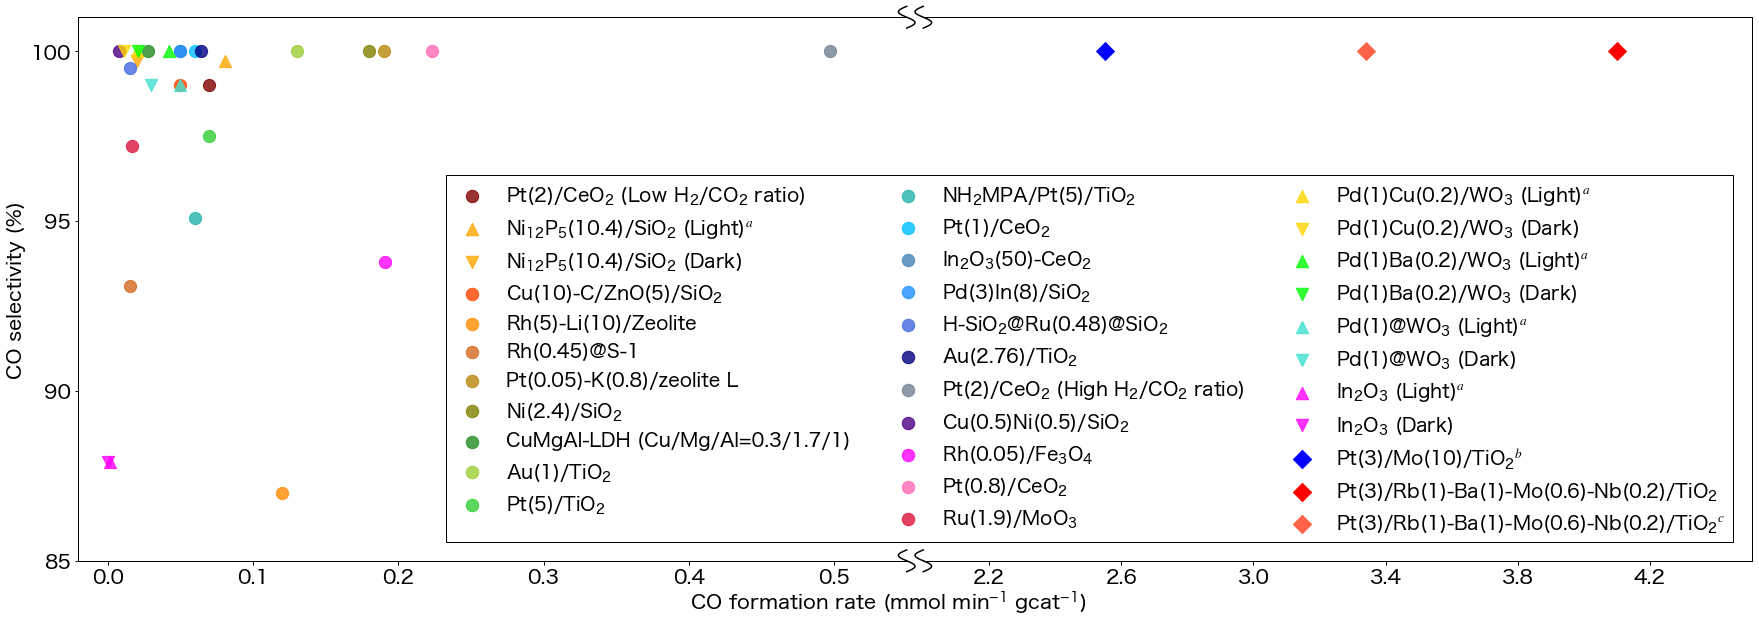

In [4]:
vs_paper = pd.read_excel('data/data_vs_previous_reports_v2.xlsx', sheet_name='data_tableS3')
idx = vs_paper['select']==1
vs_paper = vs_paper[idx].reset_index()

fig, axes = plt.subplots(1, 2, facecolor='white', sharex='col', sharey='row', figsize = (30, 10), zorder=1)
fig.subplots_adjust(wspace=0.02)

axes[0].set_xlim([-vs_paper['CO formation rate (mmol gcat-1 min-1)'].max()*0.005, 0.55])
axes[1].set_xlim([2.0, vs_paper['CO formation rate (mmol gcat-1 min-1)'].max()*1.1])
axes[0].set_xticks(np.arange(round(-vs_paper['CO formation rate (mmol gcat-1 min-1)'].max()*0.005, 1), 0.6, 0.1))
axes[1].set_xticks(np.arange(2.2, round(vs_paper['CO formation rate (mmol gcat-1 min-1)'].max()*1.1, 1), 0.4))

axes[0].set_ylim([85, 101])
axes[0].set_yticks(np.arange(85, 105, 5))
axes[0].spines.right.set_visible(False)
axes[1].spines.left.set_visible(False)

axes[0].tick_params(labeltop=False)
axes[1].tick_params(labeltop=False, left=False)

axes[0].tick_params(axis='x', labelsize=20)
axes[1].tick_params(axis='x', labelsize=20)
axes[0].tick_params(axis='y', labelsize=20)

dy = 0.02
x_v1 = np.linspace(-dy, +dy, 100)
x_v2 = np.linspace(1 - dy, 1 + dy, 100)
y_v1 = np.sin(np.linspace(0, 2*np.pi, 100))/100
y_v2 = np.sin(np.linspace(0, 2*np.pi, 100))/100+1


kwargs = dict(transform=axes[0].transAxes, color='k', clip_on=False)
axes[0].plot(y_v2, x_v2, **kwargs)
kwargs = dict(transform=axes[0].transAxes, color='k', clip_on=False)
axes[0].plot(y_v2, x_v1, **kwargs)

kwargs = dict(transform=axes[1].transAxes, color='k', clip_on=False)
axes[1].plot(y_v1, x_v1, **kwargs)
kwargs = dict(transform=axes[1].transAxes, color='k', clip_on=False)
axes[1].plot(y_v1, x_v2, **kwargs)

fig.supxlabel('CO formation rate (mmol $min^{{-}1}$ $gcat^{{-}1}$)', y=0.05, fontsize=20)
#fig.supylabel('$CO_{2}$ selectivity (%)', fontsize=14)
axes[0].set_ylabel('CO selectivity (%)', fontsize=20)

for i in range(len(vs_paper.index)):
    axes[0].scatter(
        vs_paper['CO formation rate (mmol gcat-1 min-1)'][i], vs_paper['Selectivity (%)'][i],
        zorder=4, s=vs_paper['size'][i], marker=vs_paper['marker'][i], alpha=vs_paper['alpha'][i], color=vs_paper['color'][i], label=vs_paper['Referance catalyst'][i])
    axes[1].scatter(
        vs_paper['CO formation rate (mmol gcat-1 min-1)'][i], vs_paper['Selectivity (%)'][i],
        zorder=4, s=vs_paper['size'][i], marker=vs_paper['marker'][i], alpha=vs_paper['alpha'][i], color=vs_paper['color'][i], label=vs_paper['Referance catalyst'][i])

axes[1].legend(
    markerscale=1.02, bbox_to_anchor=(1, 0), loc='lower right', ncol=3, borderaxespad=1, frameon=True, fontsize=19
    )
plt.savefig(f'{PATH}/vs_paper_form_vs_selec_v5.png', dpi=600, bbox_inches='tight')


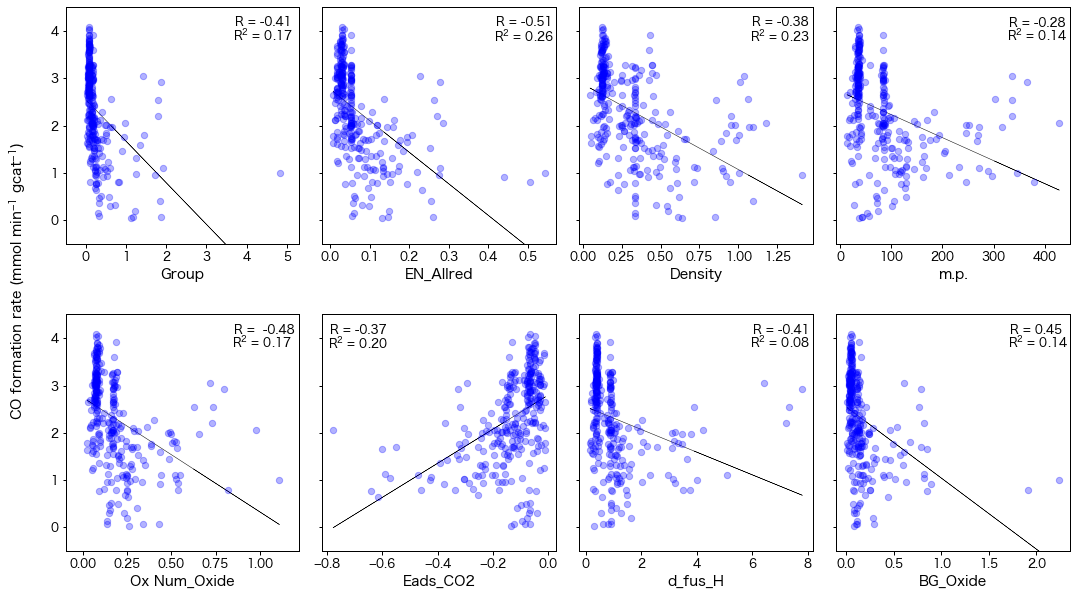

In [6]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

use_add_desc = [ # 'AW' is not used as Descriptor.
    'Group',
    'EN_Allred',
    'Density',
    'm.p.',
    'Ox Num_Oxide',
    'Eads_CO2',
    'd_fus_H',
    'BG_Oxide',
    ]

feat_target = pd.concat([feat, target], axis=1)
feat_target_corr = feat_target.corr()
feat_target_corr['CO formation rate_mmol min-1 gcat-1'] = round(feat_target_corr['CO formation rate_mmol min-1 gcat-1'], 2)
feat_target_corr['R2 value'] = round(feat_target_corr['CO formation rate_mmol min-1 gcat-1']**2, 2)


fig, axes = plt.subplots(2, 4, facecolor='white', sharey='row', figsize = (18, 10), zorder=1)
fig.subplots_adjust(hspace=0.3, wspace=0.1)
fig.supylabel('CO formation rate (mmol $min^{{-}1}$ $gcat^{{-}1}$)', x=0.08, fontsize=14)

axes[0, 0].scatter(feat[use_add_desc[0]], target, zorder=4, s=40, marker='o', alpha=0.3, color='blue')
axes[0, 0].set_xlabel(use_add_desc[0], fontsize=14)
axes[0, 0].set_xlim(-0.5, feat[use_add_desc[0]].max()*1.1)
axes[0, 0].set_ylim(-0.5, target.max()*1.1)
corr = feat_target_corr['CO formation rate_mmol min-1 gcat-1'][0]
axes[0, 0].text(feat[use_add_desc[0]].max()-feat[use_add_desc[0]].max()*0.23, 4.1, f'R = {corr}', fontsize=12)
model_line = model.fit(np.array(feat[use_add_desc[0]]).reshape(-1,1), np.array(target).reshape(-1,1))
r2_line = model.score(np.array(feat[use_add_desc[0]]).reshape(-1,1), np.array(target).reshape(-1,1))
axes[0, 0].text(feat[use_add_desc[0]].max()-feat[use_add_desc[0]].max()*0.24, 3.8, '$ R^{2} $ = ' + str(round(r2_line, 2)), fontsize=12)
target_pred = model_line.predict(np.array(feat[use_add_desc[0]]).reshape(-1,1))
axes[0, 0].plot(np.array(feat[use_add_desc[0]]).reshape(-1,1), target_pred, color='k', linewidth=0.5)

axes[0, 1].scatter(feat[use_add_desc[1]], target, zorder=4, s=40, marker='o', alpha=0.3, color='blue')
axes[0, 1].set_xlabel(use_add_desc[1], fontsize=14)
corr = feat_target_corr['CO formation rate_mmol min-1 gcat-1'][1]
axes[0, 1].text(feat[use_add_desc[1]].max()-feat[use_add_desc[1]].max()*0.23, 4.1, f'R = {corr}', fontsize=12)
model_line = model.fit(np.array(feat[use_add_desc[1]]).reshape(-1,1), np.array(target).reshape(-1,1))
r2_line = model.score(np.array(feat[use_add_desc[1]]).reshape(-1,1), np.array(target).reshape(-1,1))
axes[0, 1].text(feat[use_add_desc[1]].max()-feat[use_add_desc[1]].max()*0.24, 3.8, '$ R^{2} $ = ' + str(round(r2_line, 2)), fontsize=12)
target_pred = model_line.predict(np.array(feat[use_add_desc[1]]).reshape(-1,1))
axes[0, 1].plot(np.array(feat[use_add_desc[1]]).reshape(-1,1), target_pred, color='k', linewidth=0.5)

axes[0, 2].scatter(feat[use_add_desc[2]], target, zorder=4, s=40, marker='o', alpha=0.3, color='blue')
axes[0, 2].set_xlabel(use_add_desc[2], fontsize=14)
corr = feat_target_corr['CO formation rate_mmol min-1 gcat-1'][2]
axes[0, 2].text(feat[use_add_desc[2]].max()-feat[use_add_desc[2]].max()*0.23, 4.1, f'R = {corr}', fontsize=12)
model_line = model.fit(np.array(feat[use_add_desc[2]]).reshape(-1,1), np.array(target).reshape(-1,1))
r2_line = model.score(np.array(feat[use_add_desc[2]]).reshape(-1,1), np.array(target).reshape(-1,1))
axes[0, 2].text(feat[use_add_desc[2]].max()-feat[use_add_desc[2]].max()*0.24, 3.8, '$ R^{2} $ = ' + str(round(r2_line, 2)), fontsize=12)
target_pred = model_line.predict(np.array(feat[use_add_desc[2]]).reshape(-1,1))
axes[0, 2].plot(np.array(feat[use_add_desc[2]]).reshape(-1,1), target_pred, color='k', linewidth=0.5)

axes[0, 3].scatter(feat[use_add_desc[3]], target, zorder=4, s=40, marker='o', alpha=0.3, color='blue')
axes[0, 3].set_xlabel(use_add_desc[3], fontsize=14)
corr = feat_target_corr['CO formation rate_mmol min-1 gcat-1'][3]
axes[0, 3].text(feat[use_add_desc[3]].max()-feat[use_add_desc[3]].max()*0.23, 4.1, f'R = {corr}', fontsize=12)
model_line = model.fit(np.array(feat[use_add_desc[3]]).reshape(-1,1), np.array(target).reshape(-1,1))
r2_line = model.score(np.array(feat[use_add_desc[3]]).reshape(-1,1), np.array(target).reshape(-1,1))
axes[0, 3].text(feat[use_add_desc[3]].max()-feat[use_add_desc[3]].max()*0.24, 3.8, '$ R^{2} $ = ' + str(round(r2_line, 2)), fontsize=12)
target_pred = model_line.predict(np.array(feat[use_add_desc[3]]).reshape(-1,1))
axes[0, 3].plot(np.array(feat[use_add_desc[3]]).reshape(-1,1), target_pred, color='k', linewidth=0.5)

axes[1, 0].scatter(feat[use_add_desc[4]], target, zorder=4, s=40, marker='o', alpha=0.3, color='blue')
axes[1, 0].set_xlabel(use_add_desc[4], fontsize=14)
axes[1, 0].set_xlim(-0.1, feat[use_add_desc[4]].max()*1.1)
axes[1, 0].set_ylim(-0.5, target.max()*1.1)
corr = feat_target_corr['CO formation rate_mmol min-1 gcat-1'][4]
axes[1, 0].text(feat[use_add_desc[4]].max()-feat[use_add_desc[4]].max()*0.23, 4.1, f'R =  {corr}', fontsize=12)
model_line = model.fit(np.array(feat[use_add_desc[4]]).reshape(-1,1), np.array(target).reshape(-1,1))
r2_line = model.score(np.array(feat[use_add_desc[4]]).reshape(-1,1), np.array(target).reshape(-1,1))
axes[1, 0].text(feat[use_add_desc[4]].max()-feat[use_add_desc[4]].max()*0.24, 3.8, '$ R^{2} $ = ' + str(round(r2_line, 2)), fontsize=12)
target_pred = model_line.predict(np.array(feat[use_add_desc[4]]).reshape(-1,1))
axes[1, 0].plot(np.array(feat[use_add_desc[4]]).reshape(-1,1), target_pred, color='k', linewidth=0.5)

axes[1, 1].scatter(feat[use_add_desc[5]], target, zorder=4, s=40, marker='o', alpha=0.3, color='blue')
axes[1, 1].set_xlabel(use_add_desc[5], fontsize=14)
corr = feat_target_corr['CO formation rate_mmol min-1 gcat-1'][5]
axes[1, 1].text(feat[use_add_desc[5]].min()-0.01, 4.1, f'R = {corr}', fontsize=12)
model_line = model.fit(np.array(feat[use_add_desc[5]]).reshape(-1,1), np.array(target).reshape(-1,1))
r2_line = model.score(np.array(feat[use_add_desc[5]]).reshape(-1,1), np.array(target).reshape(-1,1))
axes[1, 1].text(feat[use_add_desc[5]].min()-0.02, 3.8, '$ R^{2} $ = ' + str(round(r2_line, 2))+'0', fontsize=12)
target_pred = model_line.predict(np.array(feat[use_add_desc[5]]).reshape(-1,1))
axes[1, 1].plot(np.array(feat[use_add_desc[5]]).reshape(-1,1), target_pred, color='k', linewidth=0.5)

axes[1, 2].scatter(feat[use_add_desc[6]], target, zorder=4, s=40, marker='o', alpha=0.3, color='blue')
axes[1, 2].set_xlabel(use_add_desc[6], fontsize=14)
corr = feat_target_corr['CO formation rate_mmol min-1 gcat-1'][6]
axes[1, 2].text(feat[use_add_desc[6]].max()-feat[use_add_desc[6]].max()*0.23, 4.1, f'R = {corr}', fontsize=12)
model_line = model.fit(np.array(feat[use_add_desc[6]]).reshape(-1,1), np.array(target).reshape(-1,1))
r2_line = model.score(np.array(feat[use_add_desc[6]]).reshape(-1,1), np.array(target).reshape(-1,1))
axes[1, 2].text(feat[use_add_desc[6]].max()-feat[use_add_desc[6]].max()*0.24, 3.8, '$ R^{2} $ = ' + str(round(r2_line, 2)), fontsize=12)
target_pred = model_line.predict(np.array(feat[use_add_desc[6]]).reshape(-1,1))
axes[1, 2].plot(np.array(feat[use_add_desc[6]]).reshape(-1,1), target_pred, color='k', linewidth=0.5)

axes[1, 3].scatter(feat[use_add_desc[7]], target, zorder=4, s=40, marker='o', alpha=0.3, color='blue')
axes[1, 3].set_xlabel(use_add_desc[7], fontsize=14)
corr = feat_target_corr['CO formation rate_mmol min-1 gcat-1'][7]
axes[1, 3].text(feat[use_add_desc[7]].max()-feat[use_add_desc[7]].max()*0.23, 4.1, f'R = {corr}', fontsize=12)
model_line = model.fit(np.array(feat[use_add_desc[7]]).reshape(-1,1), np.array(target).reshape(-1,1))
r2_line = model.score(np.array(feat[use_add_desc[7]]).reshape(-1,1), np.array(target).reshape(-1,1))
axes[1, 3].text(feat[use_add_desc[7]].max()-feat[use_add_desc[7]].max()*0.24, 3.8, '$ R^{2} $ = ' + str(round(r2_line, 2)), fontsize=12)
target_pred = model_line.predict(np.array(feat[use_add_desc[7]]).reshape(-1,1))
axes[1, 3].plot(np.array(feat[use_add_desc[7]]).reshape(-1,1), target_pred, color='k', linewidth=0.5)

plt.savefig(f'{PATH}/feat_sum_vs_target_v3.png', dpi=600, bbox_inches='tight')


In [32]:
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # 最初の軸を一番上にする
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: x[0], y[0]を2倍にする
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # Axes patchを(x,y) = (0.5,0.5)にし、半径を0.5にする
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon(
                    (0.5, 0.5), num_vars,
                    radius=.5, edgecolor="k"
                    )
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(
                    axes=self,
                    spine_type='circle',
                    path=Path.unit_regular_polygon(num_vars)
                    )
                # unit_regular_polygon: 中心(0,0)、半径1の多角形を生成
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                #set_transform:任意の倍率に縮小拡大,任意の座標に中心を移動
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

def cat_desc(d, ax, color='r'):
    #labels = list(desc.columns)
    #labels = ['Group', 'electro\nnegativity     ', 'm. p.', 'delta\n fus H ', 'density']
    labels = ['Group', 'EN_Allred', 'm.p.', 'd_fus_H', 'Density', 'BG_Oxide', 'Ox Num\nOxide', 'Eads_CO2']

    ax.plot(theta, d, color=color)
    ax.fill(theta, d, facecolor=color, alpha=0.2)
    #ax.text(x=0, y=d.max()*1.8, s=cat, ha='center', va='top', size=12)
    ax.text(x=0, y=2.3, s=cat, ha='center', va='top', size=12)
    ax.tick_params(pad=13.0)
    #ax.set_rgrids([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2], labels=[])
    #ax.set_rgrids(np.arange(0, d.max(), d.max()/7), labels=[])
    ax.set_rlim([d.min(), d.max()])
    #ax.set_rlim([0, 1.2])
    ax.set_varlabels(labels)


20220318 rwgs_250 all data
pgm_num = 0 add_num = 5 supp_num = 0 CalT_num = 0


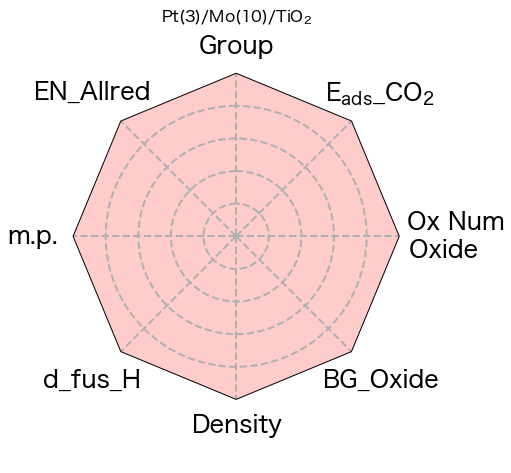

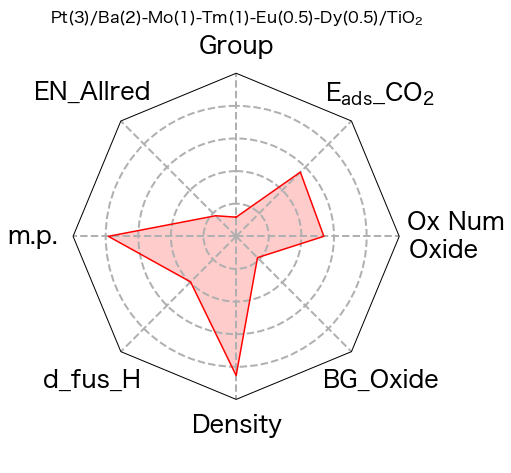

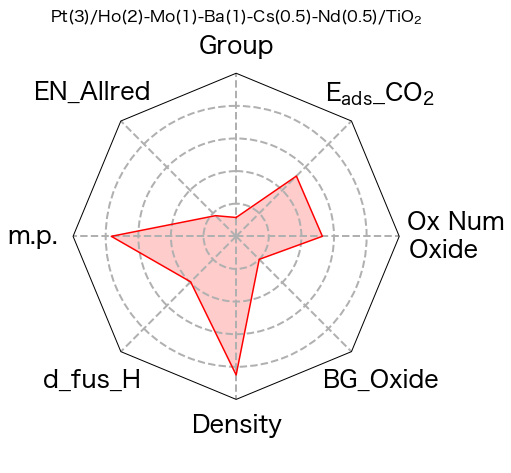

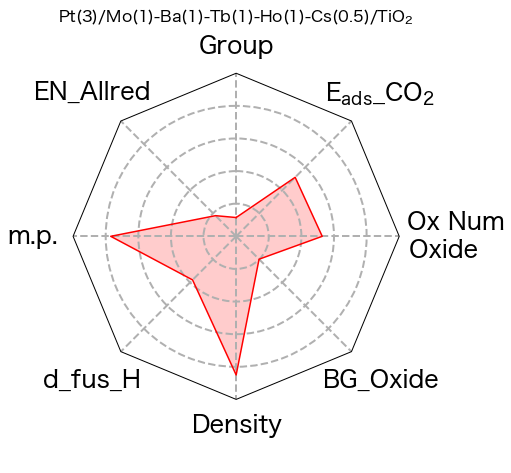

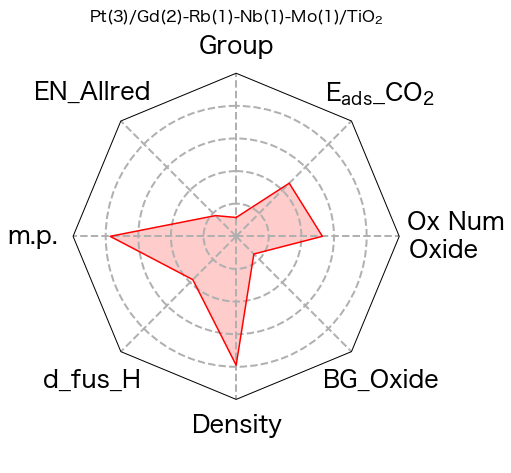

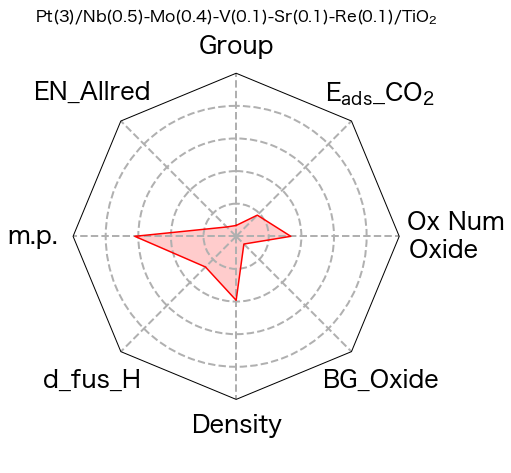

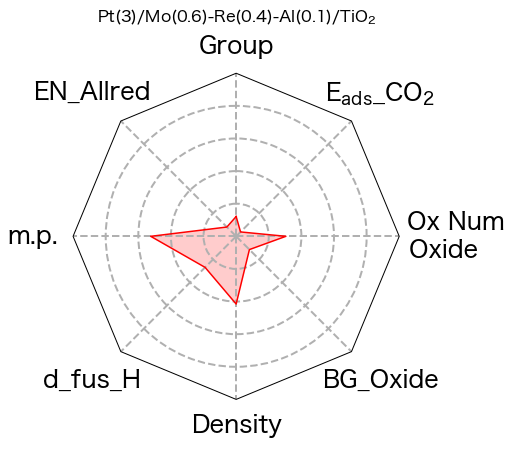

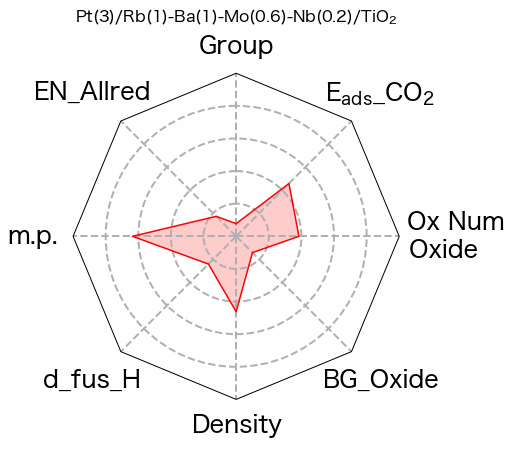

In [109]:
def cat_desc(d, ax, color='r'):
    #labels = list(desc.columns)
    #labels = ['Group', 'electro\nnegativity     ', 'm. p.', 'delta\n fus H ', 'density']
    labels = ['\nGroup', 'EN_Allred', 'm.p.', 'd_fus_H', 'Density\n', 'BG_Oxide', '    Ox Num\n Oxide', '$E_{ads}$_$CO_{2}$']

    ax.plot(theta, d, color=color)
    ax.fill(theta, d, facecolor=color, alpha=0.2)
    ax.text(x=0, y=0.35, s=cat, ha='center', va='top', size=16)
    #ax.text(x=0, y=2.3, s=cat, ha='center', va='top', size=12)
    ax.tick_params(pad=30.0, labelsize=24)
    ax.set_rgrids([0, 0.05, 0.10, 0.15, 0.20], labels=[])
    #ax.set_rlim([d.min(), d.max()])
    ax.set_rlim([0, 0.25])
    ax.set_varlabels(labels)


folder = 'redar_chart'
path = f'{PATH}/' + folder + '/'
os.makedirs(path, exist_ok = True)

condition = conditions.calc_condition()
Reaction, data_sheet_name = condition['Reaction'], condition['data_sheet_name']
pgm_model, add_model, supp_model = condition['pgm_model'], condition['add_model'], condition['supp_model']
target_name = condition['target_name']
converted = analysis.analysis_data_convert(condition, data_sheet_name, use_models=[pgm_model, add_model, supp_model], idx=None)
max_target_out, max_target = extract_max_min_target_cat(condition, converted)
add_desc = converted['add_desc']

feat = converted['feat']
feat['Eads_CO2'] = feat['Eads_CO2'].abs()

for i in range(len(feat)):
	feat.iloc[i] = feat.iloc[i] / feat.iloc[0]

feat_norm = (feat - feat.min())/(feat.max() - feat.min())
feat_norm.iloc[0] = feat.iloc[0]
feat_norm = pd.concat([feat_norm, Table_S3['Catalyst']], axis=1)

theta = radar_factory(len(add_desc.columns), frame='polygon')

radar_plot_list = list(max_target_out['No.'].astype(int))

chart_cat_list = [
    'Pt(3)/Mo(10)/TiO$_{2}$',
    'Pt(3)/Ba(2)-Mo(1)-Tm(1)-Eu(0.5)-Dy(0.5)/$TiO_{2}$',
    'Pt(3)/Ho(2)-Mo(1)-Ba(1)-Cs(0.5)-Nd(0.5)/$TiO_{2}$',
    'Pt(3)/Mo(1)-Ba(1)-Tb(1)-Ho(1)-Cs(0.5)/$TiO_{2}$',
    'Pt(3)/Gd(2)-Rb(1)-Nb(1)-Mo(1)/$TiO_{2}$',
    'Pt(3)/Nb(0.5)-Mo(0.4)-V(0.1)-Sr(0.1)-Re(0.1)/$TiO_{2}$',
    'Pt(3)/Mo(0.6)-Re(0.4)-Al(0.1)/$TiO_{2}$',
    'Pt(3)/Rb(1)-Ba(1)-Mo(0.6)-Nb(0.2)/$TiO_{2}$'
    ]

for i in range(0, len(radar_plot_list)):
    
    #print(radar_plot_list[i])
    if len(chart_cat_list) == 0:
        cat = feat_norm['Catalyst'][radar_plot_list[i]-1]
    else:
        cat = chart_cat_list[i]
    d = feat_norm.loc[radar_plot_list[i]-1, add_desc.columns]
    #d_norm = (d - d.min())/(d.max() - d.min())
    #d_norm = d * 1//d.max()
    
    if d.max() < 0.1:
        d = d * 2
    else:
        pass
       
    fig, ax = plt.subplots(figsize=(6,6), facecolor='white', subplot_kw=dict(projection='radar'))
    cat_desc(d, ax, color='r')
    plt.savefig(path + f'No{radar_plot_list[i]}_desc8.png', bbox_inches='tight', dpi=600)

In [14]:
feat = converted['feat']
feat['Eads_CO2'] = feat['Eads_CO2'].abs()

for i in range(len(feat)):
	feat.iloc[i] = feat.iloc[i] / feat.iloc[0]

feat_norm = (feat - feat.min())/(feat.max() - feat.min())
feat_norm.iloc[0] = feat.iloc[0]
feat_norm = pd.concat([feat_norm, Table_S3['Catalyst']], axis=1)

feat_norm

Group  EN_Allred      m.p.   d_fus_H   Density  BG_Oxide  \
0    1.000000   1.000000  1.000000  1.000000  1.000000  1.000000   
1    0.199072   0.279805  1.000000  0.531735  0.829556  0.202316   
2    0.038868   0.070841  0.175947  0.031789  0.319613  0.056234   
3    0.039257   0.071517  0.198549  0.039185  0.289938  0.121188   
4    0.064614   0.118936  0.470957  0.148275  0.334007  0.203078   
..        ...        ...       ...       ...       ...       ...   
295  0.018863   0.026653  0.135622  0.083301  0.164254  0.024971   
296  0.009363   0.021709  0.078954  0.028937  0.060909  0.018778   
297  0.009928   0.024280  0.079085  0.032869  0.056325  0.020961   
298  0.011196   0.028433  0.082294  0.033025  0.062141  0.021811   
299  0.009759   0.022977  0.078758  0.027468  0.059693  0.018208   

     Ox Num_Oxide  Eads_CO2                                          Catalyst  
0        1.000000  1.000000                                 Pt(3)/Mo(10)/TiO2  
1        0.880380  0.775426                                  Pt(3)/V(10)/TiO2  
2        0.241661  0.216274                                 Pt(3)/Ce(10)/TiO2  
3        0.177881  0.289599                                 Pt(3)/La(10)/TiO2  
4        0.289339  0.359941                                  Pt(3)/Y(10)/TiO2  
..            ...       ...                                               ...  
295      0.088234  0.054339             Pt(3)/Ba(2)-Re(1)-Mo(0.6)-W(0.2)/TiO2  
296      0.046472  0.061350    Pt(3)/Rb(1)-Ba(1)-Mo(0.5)-Nb(0.2)-Hf(0.2)/TiO2  
297      0.048958  0.059138          Pt(3)/Mo(0.7)-K(0.7)-Ba(0.5)-W(0.2)/TiO2  
298      0.055840  0.051770  Pt(3)/Rb(1)-Mo(0.7)-Ce(0.2)-Nb(0.2)-Na(0.2)/TiO2  
299      0.048214  0.066608    Pt(3)/Ba(1)-Rb(1)-Mo(0.5)-Nb(0.2)-Yb(0.2)/TiO2  

[300 rows x 9 columns]

In [75]:
folder = 'waterfall'
path = f'{PATH}/' + folder + '/'
os.makedirs(path, exist_ok = True)

In [79]:
Table_S3['Catalyst'][0]

'Pt(3)/Mo(10)/TiO2'

In [ ]:
data = converted['data']
target_name, ML_model = condition['target_name'], condition['ML_model']
model = ExtraTreesRegressor(n_estimators=100, random_state=1107, n_jobs=4)
model.fit(feat, target)

#explainer = shap.TreeExplainer(model, feat)
#shap_values = explainer.shap_values(feat)

explainer = shap.Explainer(model, feat)
shap_values = explainer(feat)
plt.figure(facecolor='white', figsize =(8,6))
Cat_No = 180
print('No.', data['No.'][Cat_No-1])
print(
    data['Ad1'][Cat_No-1],data['Ad1_wt%'][Cat_No-1],data['Ad2'][Cat_No-1],data['Ad2_wt%'][Cat_No-1],data['Ad3'][Cat_No-1],data['Ad3_wt%'][Cat_No-1],
    data['Ad4'][Cat_No-1],data['Ad4_wt%'][Cat_No-1],data['Ad5'][Cat_No-1],data['Ad5_wt%'][Cat_No-1]
    )
print('CO form rate (mmol min-1 gcat-1):', round(data[target_name][Cat_No-1], 2))
shap.plots.waterfall(shap_values[Cat_No-1], max_display=13, show=True, filename=f'{path}'+'/'+f'{waterfall}.png')

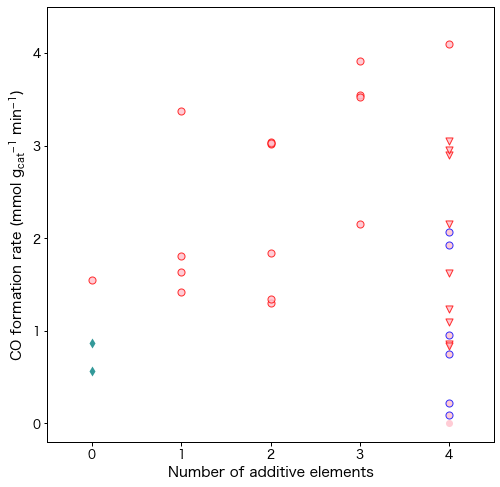

In [120]:
table_S5 = pd.read_excel('data/Table_S5.xlsx')
table_S5.loc[:, ['PGM1', 'Ad1', 'Ad2', 'Ad3', 'Ad4']] = table_S5.loc[:, ['PGM1', 'Ad1', 'Ad2', 'Ad3', 'Ad4']].fillna('H')
table_S5.loc[:, ['PGM1_wt%', 'Ad1_wt%', 'Ad2_wt%', 'Ad3_wt%', 'Ad4_wt%']] = table_S5.loc[:, ['PGM1_wt%', 'Ad1_wt%', 'Ad2_wt%', 'Ad3_wt%', 'Ad4_wt%']].fillna(0)

comm_cat = table_S5.tail(2)
table_S5 = table_S5[:-2]

other_PGM_list = ['Re', 'Ru', 'Rh', 'Ir', 'Pd', 'Ag'] # w/o 'Pt'
other_supp_list = ['SiO2', 'Al2O3', 'ZrO2(JRC5)', 'CeO2(JRC2)', 'MgO', 'Nb2O5', 'TiO2(ST01)', 'TiO2(STR100N)', 'Carbon'] # w/o 'TiO2(P25)'

fig, ax = plt.subplots(facecolor='white', figsize=(8, 8))

ax.set_xlim(-0.5, 4.5)
ax.set_ylim(-0.2, 4.5)
#ax.axes.yaxis.set_ticks([])

ax.set_xlabel('Number of additive elements', fontsize=14)
ax.set_ylabel('CO formation rate (mmol $g_{cat}$$^{{-}1}$ $min^{{-}1}$)', fontsize=14)

size = 50

for i in range(len(table_S5.index)):
    if table_S5['PGM1_wt%'][i] == 0:
        ax.scatter(table_S5['Num_of_Add'][i], table_S5['CO form. rate (mmol g-1 h-1)'][i], marker="o", s=size, c='pink', edgecolors='k', linewidths=0, alpha=0.8, zorder=1, label='')
    elif table_S5['PGM1_wt%'][i] != 0 and table_S5['PGM1'][i] == 'Pt' and table_S5['Support_name'][i] == 'TiO2(P-25)':
        ax.scatter(table_S5['Num_of_Add'][i], table_S5['CO form. rate (mmol g-1 h-1)'][i], marker="o", s=size, c='pink', edgecolors='red', linewidths=1, alpha=0.8, zorder=1, label='')
    elif table_S5['PGM1_wt%'][i] != 0 and table_S5['PGM1'][i] != 'Pt' and table_S5['Support_name'][i] == 'TiO2(P-25)':
        ax.scatter(table_S5['Num_of_Add'][i], table_S5['CO form. rate (mmol g-1 h-1)'][i], marker="o", s=size, c='pink', edgecolors='blue', linewidths=1, alpha=0.8, zorder=1, label='')
    elif table_S5['PGM1_wt%'][i] != 0 and table_S5['PGM1'][i] == 'Pt' and table_S5['Support_name'][i] != 'TiO2(P-25)':
        ax.scatter(table_S5['Num_of_Add'][i], table_S5['CO form. rate (mmol g-1 h-1)'][i], marker="v", s=size, c='pink', edgecolors='red', linewidths=1, alpha=0.8, zorder=1, label='')

ax.scatter(comm_cat['Num_of_Add'], comm_cat['CO form. rate (mmol g-1 h-1)'], marker="d", s=size, c='teal', edgecolors='k', linewidths=0, alpha=0.8, zorder=1, label='')

plt.savefig(f'{PATH}/control_plot.png', dpi=600 ,bbox_inches='tight')


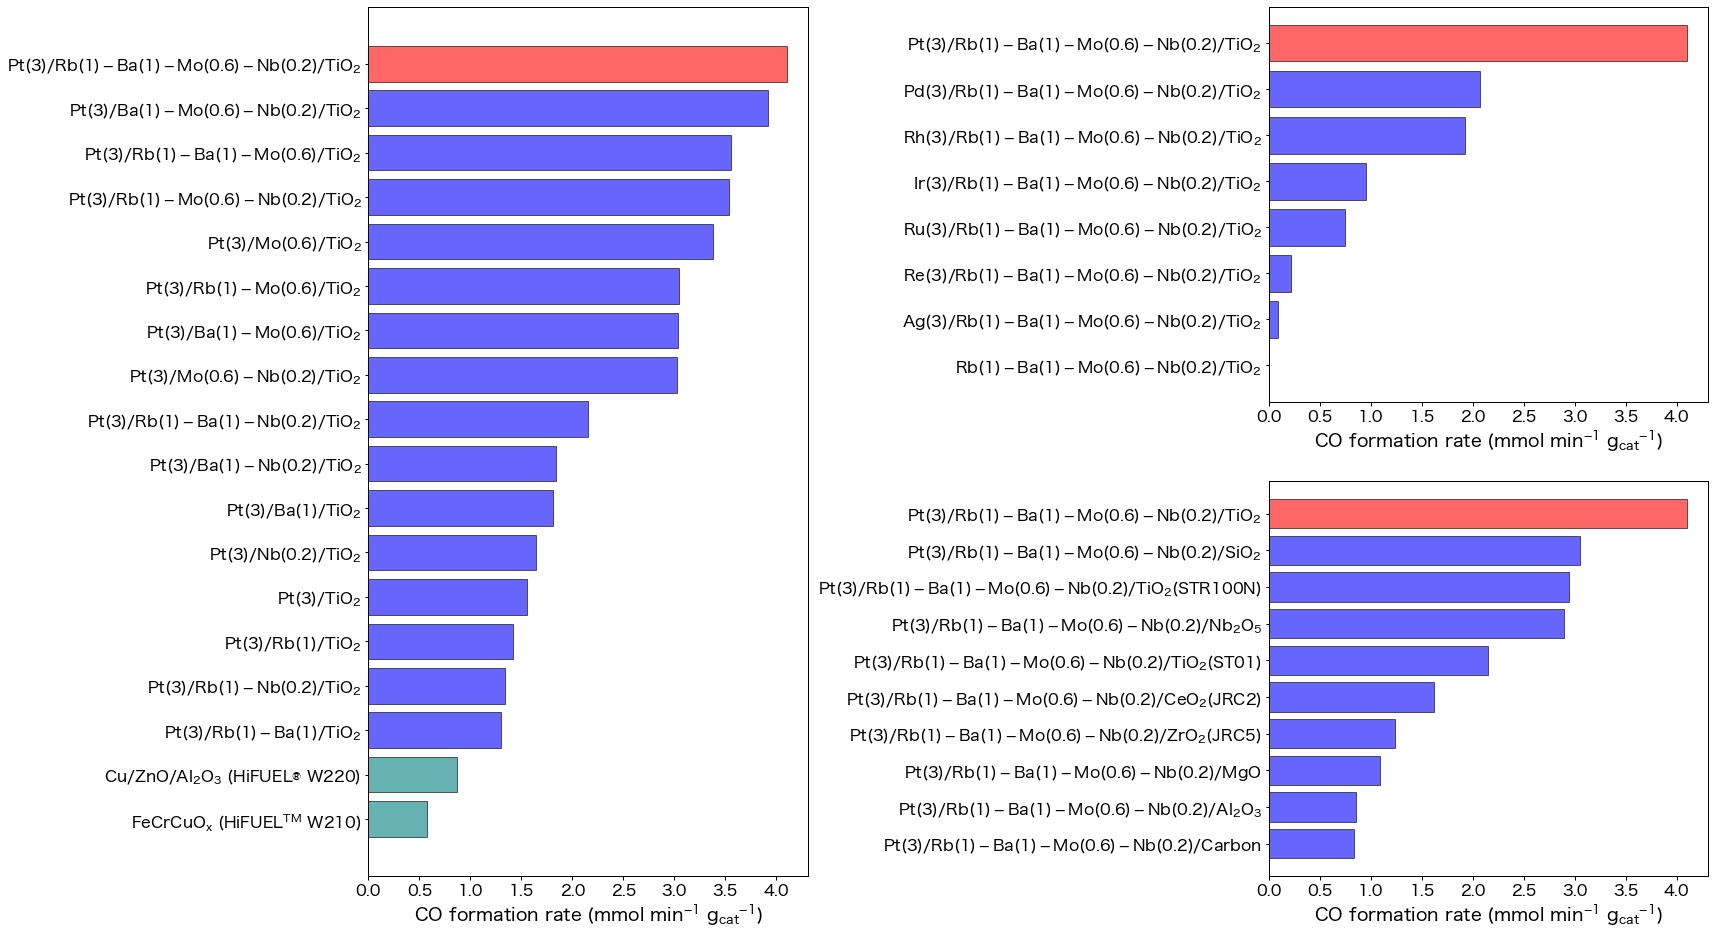

In [213]:
table_S5 = pd.read_excel('data/Table_S5.xlsx')
table_S5.loc[:, ['PGM1', 'Ad1', 'Ad2', 'Ad3', 'Ad4']] = table_S5.loc[:, ['PGM1', 'Ad1', 'Ad2', 'Ad3', 'Ad4']].fillna('H')
table_S5.loc[:, ['PGM1_wt%', 'Ad1_wt%', 'Ad2_wt%', 'Ad3_wt%', 'Ad4_wt%']] = table_S5.loc[:, ['PGM1_wt%', 'Ad1_wt%', 'Ad2_wt%', 'Ad3_wt%', 'Ad4_wt%']].fillna(0)

table_S5_add = table_S5.drop([0, 1, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])
table_S5_add = table_S5_add.sort_values('CO form. rate (mmol g-1 h-1)', ascending=True)

table_S5_pgm = table_S5.drop([0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,  32, 33])
table_S5_pgm = table_S5_pgm.sort_values('CO form. rate (mmol g-1 h-1)', ascending=True)

table_S5_supp = table_S5.drop([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 26, 27, 28, 29, 30, 31, 32, 33])
table_S5_supp = table_S5_supp.sort_values('CO form. rate (mmol g-1 h-1)', ascending=True)

top_cat = table_S5.loc[0]

comm_cat = table_S5.loc[[32,33]]
comm_cat = comm_cat.sort_values('CO form. rate (mmol g-1 h-1)', ascending=True)


fig = plt.figure(facecolor='white', figsize = (24, 16))
plt.subplots_adjust(wspace=1.05)
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[:, 0:1])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])

#plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
#plt.xlabel('Freqency (%)', fontsize=14)
ax1.set_xlabel('CO formation rate (mmol $min^{{-}1}$ $g_{cat}$$^{{-}1}$)', fontsize=18)
ax2.set_xlabel('CO formation rate (mmol $min^{{-}1}$ $g_{cat}$$^{{-}1}$)', fontsize=18)
ax3.set_xlabel('CO formation rate (mmol $min^{{-}1}$ $g_{cat}$$^{{-}1}$)', fontsize=18)

alpha_value = 0.6
#plt.xticks(rotation=9
ax1.barh(comm_cat['Catalyst'], comm_cat['CO form. rate (mmol g-1 h-1)'], color='teal', alpha=alpha_value, edgecolor='black', align='center')
ax1.barh(table_S5_add['Catalyst'], table_S5_add['CO form. rate (mmol g-1 h-1)'], color='blue', alpha=alpha_value, edgecolor='black', align='center')
ax1.barh(top_cat['Catalyst'], top_cat['CO form. rate (mmol g-1 h-1)'], color='red', alpha=alpha_value, edgecolor='black', align='center')
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
#ax2.barh(comm_cat['Catalyst'], comm_cat['CO form. rate (mmol g-1 h-1)'], color='teal', alpha=alpha_value, edgecolor='black', align='center')
ax2.barh(table_S5_pgm['Catalyst'], table_S5_pgm['CO form. rate (mmol g-1 h-1)'], color='blue', alpha=alpha_value, edgecolor='black', align='center')
ax2.barh(top_cat['Catalyst'], top_cat['CO form. rate (mmol g-1 h-1)'], color='red', alpha=alpha_value, edgecolor='black', align='center')
ax2.tick_params(axis='x', labelsize=16)
ax2.tick_params(axis='y', labelsize=16)

#ax3.barh(comm_cat['Catalyst'], comm_cat['CO form. rate (mmol g-1 h-1)'], color='teal', alpha=alpha_value, edgecolor='black', align='center')
ax3.barh(table_S5_supp['Catalyst'], table_S5_supp['CO form. rate (mmol g-1 h-1)'], color='blue', alpha=alpha_value, edgecolor='black', align='center')
ax3.barh(top_cat['Catalyst'], top_cat['CO form. rate (mmol g-1 h-1)'], color='red', alpha=alpha_value, edgecolor='black', align='center')
ax3.tick_params(axis='x', labelsize=16)
ax3.tick_params(axis='y', labelsize=16)

plt.savefig(f'{PATH}/control_plot_barh_v3.png', dpi=600 ,bbox_inches='tight')